In [1]:
import pandas as pd
import numpy as np
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from scipy.stats import boxcox
from os import listdir

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import shap
shap.initjs()

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot

data1 = pd.read_csv("input/data/data.csv")
data1['Sales'] = data1['Quantity']*data1['UnitPrice']
data1.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34


In [5]:
data1.shape

(541909, 9)

### Hidden missing descriptions

"nan"-Strings?

In [6]:
data1.loc[data1.Description.isnull()==False, "lowercase_descriptions"] = data1.loc[
    data1.Description.isnull()==False,"Description"
].apply(lambda l: l.lower())

data1.lowercase_descriptions.dropna().apply(
    lambda l: np.where("nan" in l, True, False)
).value_counts()

False    539724
True        731
Name: lowercase_descriptions, dtype: int64

data.lowercase_descriptions.dropna().apply(
    lambda l: np.where("" == l, True, False)
).value_counts()

Drop them all:

In [7]:
data1 = data1.loc[(data1.CustomerID.isnull()==False) & (data1.lowercase_descriptions.isnull()==False)].copy()

Cancelled transactions starts with a "C", we droped them all:

In [8]:
data1["IsCancelled"]=np.where(data1.InvoiceNo.apply(lambda l: l[0]=="C"), True, False)
data1.IsCancelled.value_counts() / data1.shape[0] * 100

False    97.81112
True      2.18888
Name: IsCancelled, dtype: float64

In [9]:
data1 = data1.loc[data1.IsCancelled==False].copy()
data1 = data1.drop("IsCancelled", axis=1)

In [10]:
data1["StockCode"]

0         85123A
1          71053
2         84406B
3         84029G
4         84029E
           ...  
541904     22613
541905     22899
541906     23254
541907     23255
541908     22138
Name: StockCode, Length: 397924, dtype: object

In [11]:
data1.dtypes

InvoiceNo                  object
StockCode                  object
Description                object
Quantity                    int64
InvoiceDate                object
UnitPrice                 float64
CustomerID                float64
Country                    object
Sales                     float64
lowercase_descriptions     object
dtype: object

In [12]:
data1.StockCode.nunique()

3665

In [13]:
data1["CustomerID"] = data1["CustomerID"].astype('int64')

### Most common stockcodes?

Text(0, 0.5, 'Frequency')

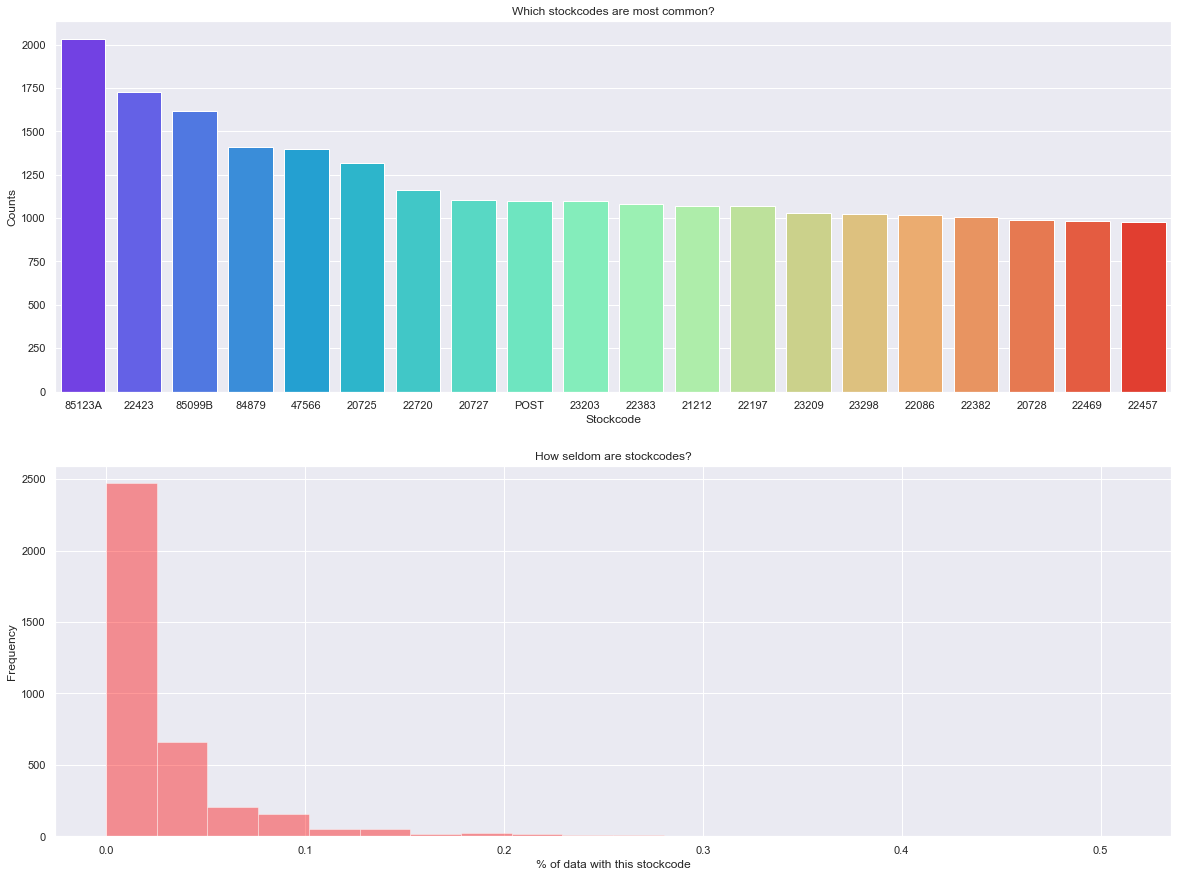

In [14]:
stockcode_counts = data1.StockCode.value_counts().sort_values(ascending=False)
fig, ax = plt.subplots(2,1,figsize=(20,15))
sns.barplot(stockcode_counts.iloc[0:20].index,
            stockcode_counts.iloc[0:20].values,
            ax = ax[0], palette="rainbow")
ax[0].set_ylabel("Counts")
ax[0].set_xlabel("Stockcode")
ax[0].set_title("Which stockcodes are most common?");
sns.distplot(np.round(stockcode_counts/data1.shape[0]*100,2),
             kde=False,
             bins=20,
             ax=ax[1], color="red")

ax[1].set_title("How seldom are stockcodes?")
ax[1].set_xlabel("% of data with this stockcode")
ax[1].set_ylabel("Frequency")


Let's count the number of numeric chars in and the length of the stockcode:

In [15]:
def count_numeric_chars(l):
    return sum(1 for c in l if c.isdigit())

data1["StockCodeLength"] = data1.StockCode.apply(lambda l: len(l))
data1["nNumericStockCode"] = data1.StockCode.apply(lambda l: count_numeric_chars(l))

In [16]:
data1.loc[data1.nNumericStockCode < 5].lowercase_descriptions.value_counts()

postage                       1099
manual                         290
carriage                       133
dotcom postage                  16
bank charges                    12
pads to match all cushions       4
Name: lowercase_descriptions, dtype: int64

In [17]:
data1 = data1.loc[(data1.nNumericStockCode == 5) & (data1.StockCodeLength==5)].copy()
data1.StockCode.nunique()

2785

In [18]:
data1.StockCode

1         71053
5         22752
6         21730
7         22633
8         22632
          ...  
541904    22613
541905    22899
541906    23254
541907    23255
541908    22138
Name: StockCode, Length: 363119, dtype: object

In [19]:
data1.Description.nunique()

2985

In [20]:
data1.StockCode.nunique()

2785

In [21]:
data1.CustomerID.nunique()

4315

In [22]:
data1 = data1.drop(["nNumericStockCode", "StockCodeLength"], axis=1)

### Description:

Most common descriptions?

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 [Text(0, 0, 'REGENCY CAKESTAND 3 TIER'),
  Text(1, 0, 'ASSORTED COLOUR BIRD ORNAMENT'),
  Text(2, 0, 'PARTY BUNTING'),
  Text(3, 0, 'LUNCH BAG RED RETROSPOT'),
  Text(4, 0, 'SET OF 3 CAKE TINS PANTRY DESIGN '),
  Text(5, 0, 'LUNCH BAG  BLACK SKULL.'),
  Text(6, 0, 'PACK OF 72 RETROSPOT CAKE CASES'),
  Text(7, 0, "PAPER CHAIN KIT 50'S CHRISTMAS "),
  Text(8, 0, 'SPOTTY BUNTING'),
  Text(9, 0, 'LUNCH BAG SPACEBOY DESIGN '),
  Text(10, 0, 'LUNCH BAG CARS BLUE'),
  Text(11, 0, 'HEART OF WICKER SMALL'),
  Text(12, 0, 'NATURAL SLATE HEART CHALKBOARD '),
  Text(13, 0, 'LUNCH BAG PINK POLKADOT'),
  Text(14, 0, 'REX CASH+CARRY JUMBO SHOPPER'),
  Text(15, 0, 'LUNCH BAG SUKI DESIGN '),
  Text(16, 0, 'ALARM CLOCK BAKELIKE RED '),
  Text(17, 0, 'LUNCH BAG APPLE DESIGN'),
  Text(18, 0, 'SET OF 4 PANTRY JELLY MOULDS'),
  Text(19, 0, 'JUMBO BAG PINK POLKADOT'),
  T

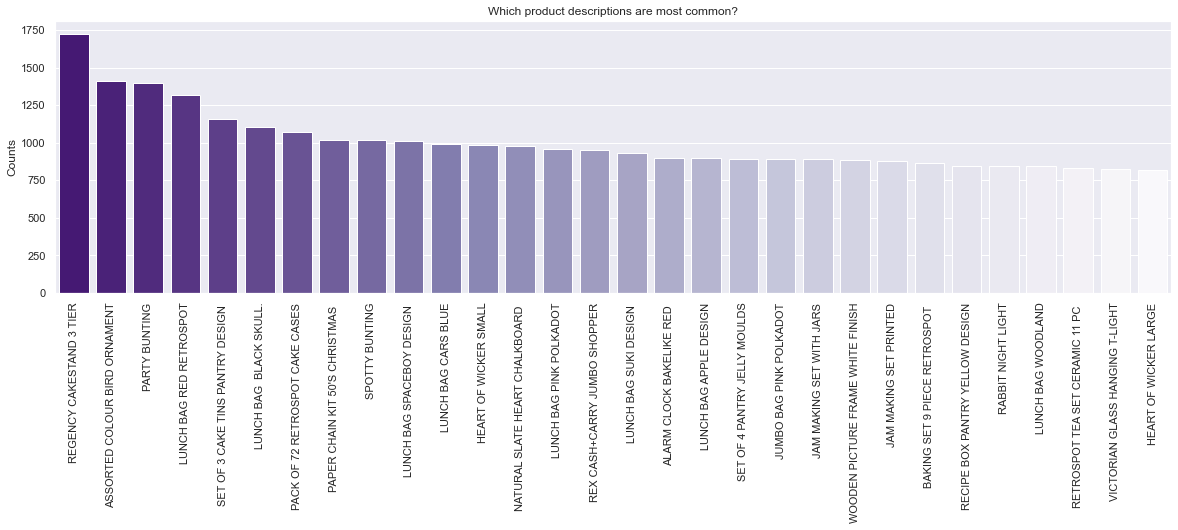

In [23]:
description_counts = data1.Description.value_counts().sort_values(ascending=False).iloc[0:30]
plt.figure(figsize=(20,5))
sns.barplot(description_counts.index, description_counts.values, palette="Purples_r")
plt.ylabel("Counts")
plt.title("Which product descriptions are most common?");
plt.xticks(rotation=90)

In [24]:
data1.loc[data1.CustomerID == '17841'].Description

Series([], Name: Description, dtype: object)

Some descriptions correspond to a similar product type.
We often have color information about the product as well. 

In [25]:
def count_lower_chars(l):
    return sum(1 for c in l if c.islower())

In [26]:
data1["DescriptionLength"] = data1.Description.apply(lambda l: len(l))
data1["LowCharsInDescription"] = data1.Description.apply(lambda l: count_lower_chars(l))

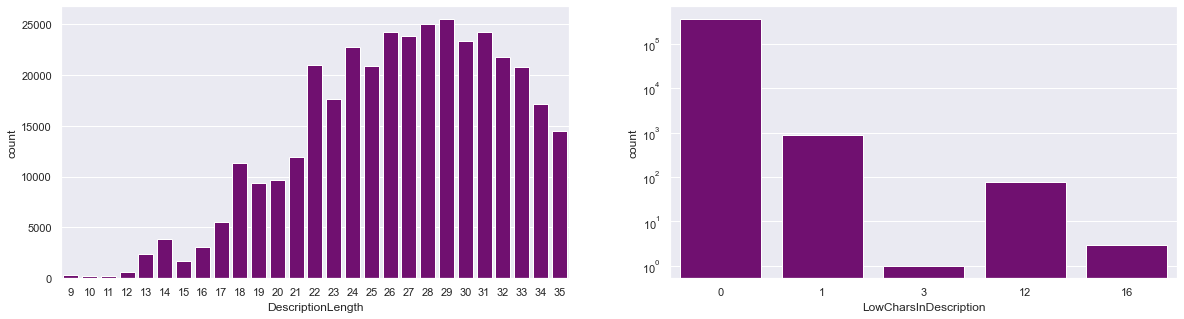

In [27]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.countplot(data1.DescriptionLength, ax=ax[0], color="Purple")
sns.countplot(data1.LowCharsInDescription, ax=ax[1], color="Purple")
ax[1].set_yscale("log")

In [28]:
data1.groupby("StockCode").Description.nunique().sort_values(ascending=False).iloc[0:10]

StockCode
23196    4
23236    4
23535    3
23126    3
23203    3
23209    3
23413    3
23396    3
23231    3
23240    3
Name: Description, dtype: int64

We have stockcodes with multiple descriptions. Browsing through the cases we can see that stockcodes are sometimes named a bit differently due to missing or changed words or typing errors.

In [29]:
data1.groupby(["StockCode","CustomerID"]).Quantity.sum()

StockCode  CustomerID
10002      12451         12
           12510         24
           12583         48
           12637         12
           12673          1
                         ..
90204      17976          1
90208      12748          1
           14911          6
           17360          2
           17596          1
Name: Quantity, Length: 243710, dtype: int64

### Customers:

In [30]:
data1.CustomerID.nunique()

4315

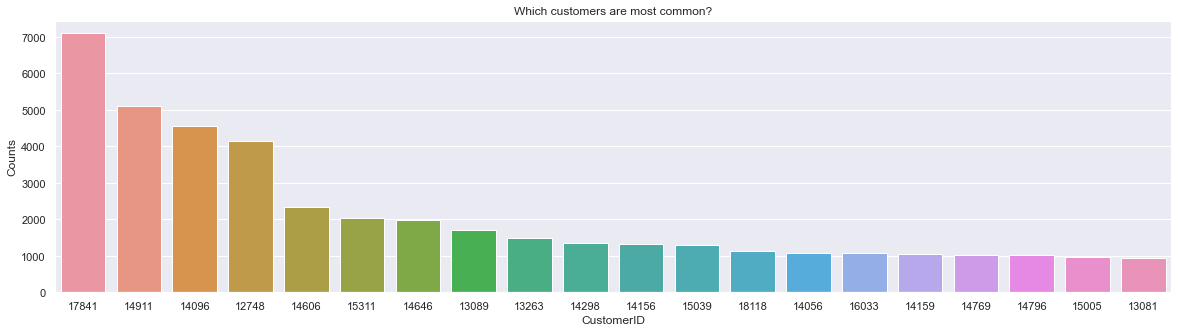

In [31]:
customer_counts = data1.CustomerID.value_counts().sort_values(ascending=False).iloc[0:20] 
plt.figure(figsize=(20,5))
sns.barplot(customer_counts.index, customer_counts.values, order=customer_counts.index)
plt.ylabel("Counts")
plt.xlabel("CustomerID")
plt.title("Which customers are most common?");
#plt.xticks(rotation=90);

### UnitPrice & Quantity

In [32]:
data1.UnitPrice.describe()

count    363119.000000
mean          2.886098
std           4.361971
min           0.000000
25%           1.250000
50%           1.700000
75%           3.750000
max         649.500000
Name: UnitPrice, dtype: float64

In [33]:
data1.shape

(363119, 12)

Let's focus transactions with prices that fall into this range as we don't want to make predictions for very seldom products with high prices.

In [34]:
data1 = data1.loc[(data1.UnitPrice > 0.1) & (data1.UnitPrice < 20)].copy()

In [35]:
data1 = data1.loc[data1.Quantity < 55].copy()

In [36]:
data1.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales,lowercase_descriptions,DescriptionLength,LowCharsInDescription
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom,20.34,white metal lantern,19,0
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,12/1/2010 8:26,7.65,17850,United Kingdom,15.30,set 7 babushka nesting boxes,28,0
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,12/1/2010 8:26,4.25,17850,United Kingdom,25.50,glass star frosted t-light holder,33,0
7,536366,22633,HAND WARMER UNION JACK,6,12/1/2010 8:28,1.85,17850,United Kingdom,11.10,hand warmer union jack,22,0
8,536366,22632,HAND WARMER RED POLKA DOT,6,12/1/2010 8:28,1.85,17850,United Kingdom,11.10,hand warmer red polka dot,25,0


In [37]:
data1.shape

(352019, 12)

### Preprocessing

In [38]:
data1 = data1.drop(["DescriptionLength","LowCharsInDescription","lowercase_descriptions"],axis =1)

In [39]:
#Data cleaning using Texthero:
from texthero import preprocessing
import texthero as hero

custom_pipeline = [preprocessing.fillna,
                   preprocessing.lowercase,
                   preprocessing.remove_whitespace,
                   preprocessing.remove_diacritics,
                   preprocessing.remove_brackets
                  ]
data1['Description'] = hero.clean(data1['Description'], custom_pipeline)
#df['Description'] = [n.replace('{','') for n in df['Description']]

data1.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales
1,536365,71053,white metal lantern,6,12/1/2010 8:26,3.39,17850,United Kingdom,20.34
5,536365,22752,set 7 babushka nesting boxes,2,12/1/2010 8:26,7.65,17850,United Kingdom,15.30
6,536365,21730,glass star frosted t-light holder,6,12/1/2010 8:26,4.25,17850,United Kingdom,25.50
7,536366,22633,hand warmer union jack,6,12/1/2010 8:28,1.85,17850,United Kingdom,11.10
8,536366,22632,hand warmer red polka dot,6,12/1/2010 8:28,1.85,17850,United Kingdom,11.10


### Daily sales


Extract temporal features out of the InvoiceDate.

In [40]:
data1["InvoiceDate"] = pd.to_datetime(data1.InvoiceDate, cache=True)

data1["Year"] = data1.InvoiceDate.dt.year
data1["Quarter"] = data1.InvoiceDate.dt.quarter
data1["Month"] = data1.InvoiceDate.dt.month
data1["Week"] = data1.InvoiceDate.dt.week
data1["Weekday"] = data1.InvoiceDate.dt.weekday
data1["Day"] = data1.InvoiceDate.dt.day
data1["Dayofyear"] = data1.InvoiceDate.dt.dayofyear
data1["Date"] = pd.to_datetime(data1[['Year', 'Month', 'Day']])


In [41]:
data1.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales,Year,Quarter,Month,Week,Weekday,Day,Dayofyear,Date
1,536365,71053,white metal lantern,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010,4,12,48,2,1,335,2010-12-01
5,536365,22752,set 7 babushka nesting boxes,2,2010-12-01 08:26:00,7.65,17850,United Kingdom,15.30,2010,4,12,48,2,1,335,2010-12-01
6,536365,21730,glass star frosted t-light holder,6,2010-12-01 08:26:00,4.25,17850,United Kingdom,25.50,2010,4,12,48,2,1,335,2010-12-01
7,536366,22633,hand warmer union jack,6,2010-12-01 08:28:00,1.85,17850,United Kingdom,11.10,2010,4,12,48,2,1,335,2010-12-01
8,536366,22632,hand warmer red polka dot,6,2010-12-01 08:28:00,1.85,17850,United Kingdom,11.10,2010,4,12,48,2,1,335,2010-12-01


In [42]:
data1.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID              int64
Country                object
Sales                 float64
Year                    int64
Quarter                 int64
Month                   int64
Week                    int64
Weekday                 int64
Day                     int64
Dayofyear               int64
Date           datetime64[ns]
dtype: object

In [43]:
pd.unique(data1.Weekday)
#0 = Mon
#1 = Tue
#2 = Wed
#3 = Thu
#4 = Fri
#6 = Sun
#There is no Saturday

array([2, 3, 4, 6, 0, 1], dtype=int64)

In [44]:
data1["is_weekend"] = data1["Weekday"].isin([5, 6]).astype(np.int8)

In [45]:
data1.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales,Year,Quarter,Month,Week,Weekday,Day,Dayofyear,Date,is_weekend
1,536365,71053,white metal lantern,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010,4,12,48,2,1,335,2010-12-01,0
5,536365,22752,set 7 babushka nesting boxes,2,2010-12-01 08:26:00,7.65,17850,United Kingdom,15.30,2010,4,12,48,2,1,335,2010-12-01,0
6,536365,21730,glass star frosted t-light holder,6,2010-12-01 08:26:00,4.25,17850,United Kingdom,25.50,2010,4,12,48,2,1,335,2010-12-01,0
7,536366,22633,hand warmer union jack,6,2010-12-01 08:28:00,1.85,17850,United Kingdom,11.10,2010,4,12,48,2,1,335,2010-12-01,0
8,536366,22632,hand warmer red polka dot,6,2010-12-01 08:28:00,1.85,17850,United Kingdom,11.10,2010,4,12,48,2,1,335,2010-12-01,0


In [46]:
(data1.loc[data1.Weekday==6]).nunique()

InvoiceNo      2119
StockCode      2566
Description    2636
Quantity         47
InvoiceDate    1980
UnitPrice       108
CustomerID     1203
Country          19
Sales           855
Year              2
Quarter           4
Month            12
Week             49
Weekday           1
Day              31
Dayofyear        50
Date             50
is_weekend        1
dtype: int64

In [47]:
(data1.loc[data1.Weekday==6]).shape

(56376, 18)

In [48]:
data1.loc[data1.Weekday==6].Quantity.sum()
#11.40 % on Sun

335005

In [49]:
data1.loc[data1.Weekday==6].Quantity.sum()

335005

### New Products:

In [50]:
NPI = pd.DataFrame(data1.groupby(['StockCode']).agg({'Date': 'first','Year': 'first', 'Month': 'first','Week': 'first',"Day": 'first', 'Weekday': 'first',
                                                                'is_weekend' : 'first',    'Quantity': 'sum', 'UnitPrice': 'mean','Sales':'sum','Description':"first"}))
NPI = NPI.reset_index()
NPI

,StockCode,Date,Year,Month,Week,Day,Weekday,is_weekend,Quantity,UnitPrice,Sales,Description
0,10002,2010-12-01,2010,12,48,1,2,0,461,0.850000,391.85,inflatable political globe
1,10080,2011-02-27,2011,2,8,27,6,1,291,0.411905,114.41,groovy cactus inflatable
2,10120,2010-12-03,2010,12,48,3,4,0,193,0.210000,40.53,doggy rubber
3,10125,2010-12-01,2010,12,48,1,2,0,756,0.784407,556.60,mini funky design tapes
4,10133,2010-12-01,2010,12,48,1,2,0,1814,0.529322,874.11,colouring pencils brown tube
...,...,...,...,...,...,...,...,...,...,...,...,...
2747,90191,2011-02-20,2011,2,7,20,6,1,22,8.550000,113.90,silver lariat 40cm
2748,90192,2011-02-14,2011,2,7,14,0,0,23,4.950000,113.85,jade drop earrings w filigree
2749,90194,2010-12-16,2010,12,50,16,3,0,12,4.250000,51.00,silver lariat black stone earrings
2750,90204,2010-12-02,2010,12,48,2,3,0,17,3.350000,56.95,pair of enamel butterfly hairclip


In [51]:
new_products = NPI.StockCode[(NPI.Date >= '2011-09-01')]
new_products = set(new_products)
print(len(new_products))
print(new_products)

233
{'23598', '23466', '23452', '23413', '23415', '23442', '23500', '23435', '23562', '23580', '23430', '23521', '23511', '23540', '23408', '23303', '23534', '23564', '23423', '23064', '23536', '23404', '23553', '23692', '23113', '23533', '23523', '23411', '23483', '23660', '23541', '84016', '23463', '23569', '23420', '23486', '23501', '23427', '23475', '23472', '23661', '23380', '23456', '23504', '23392', '23116', '23565', '23469', '23531', '23478', '23471', '23474', '23489', '23528', '23402', '90087', '23505', '23381', '23419', '23579', '23418', '23429', '23058', '23455', '23378', '23525', '23530', '90071', '23694', '23520', '23535', '90089', '23512', '23484', '23454', '23508', '23114', '23516', '23538', '23388', '23630', '23691', '23697', '23460', '22125', '23382', '23561', '23495', '23566', '23400', '23507', '23417', '90054', '90069', '23479', '23482', '23376', '23509', '23575', '21277', '23366', '23377', '23552', '23493', '23462', '23556', '23503', '23496', '23448', '23510', '2339

In [52]:
#new_products are after date '2011-09-01':
data1[(data1.StockCode.isin(new_products)) & (data1.Date <'2011-09-01')]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales,Year,Quarter,Month,Week,Weekday,Day,Dayofyear,Date,is_weekend


In [53]:
new_data = NPI[NPI.StockCode.isin(new_products)]
print(new_data.shape)
new_data.head()

(233, 12)


,StockCode,Date,Year,Month,Week,Day,Weekday,is_weekend,Quantity,UnitPrice,Sales,Description
66,20678,2011-09-23,2011,9,38,23,4,0,4,1.650000,6.60,large black diamante hairslide
191,20935,2011-09-23,2011,9,38,23,4,0,6,2.950000,17.70,round cactus candle
389,21277,2011-09-29,2011,9,39,29,3,0,4,15.475000,68.85,french style embossed heart cabinet
941,22125,2011-11-23,2011,11,47,23,2,0,4,5.950000,23.80,union jack hot water bottle
1800,23058,2011-09-14,2011,9,37,14,2,0,486,1.112955,421.02,christmas hanging snowflake


In [54]:
val_products = NPI.StockCode[(~(NPI.StockCode.isin(new_products))) & (NPI.Date >= '2011-08-01')]
val_products = set(val_products)
print(len(val_products))
print(val_products)

38
{'23327', '23351', '23355', '23433', '23332', '23352', '23333', '23325', '23437', '23329', '23356', '23350', '23374', '23439', '23438', '23189', '23360', '23349', '23431', '23373', '35650', '23334', '23354', '23432', '23359', '23330', '22340', '23328', '23358', '23436', '23331', '23445', '23348', '23326', '23375', '23357', '23324', '23353'}


In [55]:
data1[data1.StockCode.isin(val_products) & (data1.Date < '2011-08-01')]
#data1[data1.StockCode.isin(new_products)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales,Year,Quarter,Month,Week,Weekday,Day,Dayofyear,Date,is_weekend


#### Daily Data:

In [56]:
daily_data = pd.DataFrame(data1.groupby(['Date','StockCode']).agg({'Year': 'first', 'Month': 'first','Week': 'first',"Day": 'first', 'Weekday': 'first',
                                                                'is_weekend' : 'first',    'Quantity': 'sum', 'UnitPrice': 'mean','Sales':'sum','Description':"first"}))

In [57]:
daily_data = daily_data.reset_index()
daily_data.head()

,Date,StockCode,Year,Month,Week,Day,Weekday,is_weekend,Quantity,UnitPrice,Sales,Description
0,2010-12-01,10002,2010,12,48,1,2,0,60,0.85,51.00,inflatable political globe
1,2010-12-01,10125,2010,12,48,1,2,0,2,0.85,1.70,mini funky design tapes
2,2010-12-01,10133,2010,12,48,1,2,0,5,0.85,4.25,colouring pencils brown tube
3,2010-12-01,16014,2010,12,48,1,2,0,10,0.42,4.20,small chinese style scissor
4,2010-12-01,16016,2010,12,48,1,2,0,10,0.85,8.50,large chinese style scissor


In [59]:
daily_data.loc[:, ["Quantity", "Sales"]].describe()

,Quantity,Sales
count,196191.000000,196191.000000
mean,14.968852,28.187982
std,18.811419,43.918628
min,1.000000,0.120000
25%,3.000000,6.950000
50%,9.000000,15.300000
75%,20.000000,30.710000
max,411.000000,1266.300000


In [60]:
low_quantity = daily_data.Quantity.quantile(0.01)
high_quantity = daily_data.Quantity.quantile(0.99)
print((low_quantity, high_quantity))

(1.0, 89.0)


In [61]:
low_Sales = daily_data.Sales.quantile(0.01)
high_Sales = daily_data.Sales.quantile(0.99)
print((low_Sales, high_Sales))

(0.78, 204.0)


In [62]:
samples = daily_data.shape[0]

In [63]:
#Remove these just from the plot not from the data

daily_data = daily_data.loc[
    (daily_data.Quantity >= low_quantity) & (daily_data.Quantity <= high_quantity)]
daily_data = daily_data.loc[
    (daily_data.Sales >= low_Sales) & (daily_data.Sales <= high_Sales)]

In [64]:
#How much entries have we lost?
samples - daily_data.shape[0]

5243

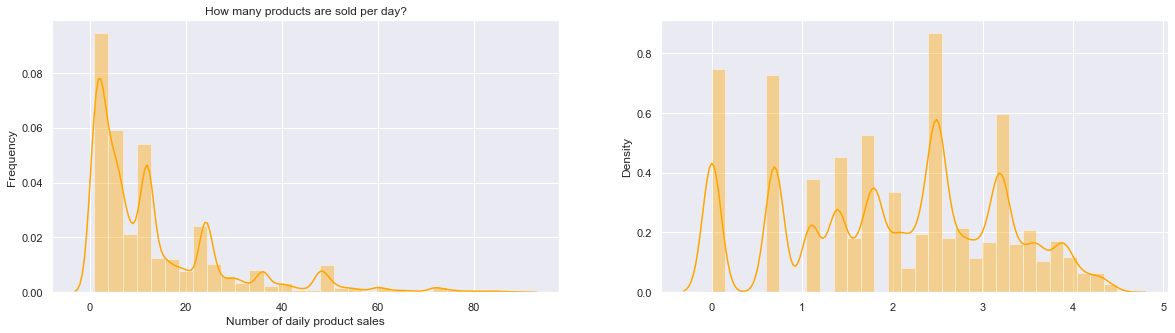

In [65]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.distplot(daily_data.Quantity.values, kde=True, ax=ax[0], color="Orange", bins=30);
sns.distplot(np.log(daily_data.Quantity.values), kde=True, ax=ax[1], color="Orange", bins=30);
ax[0].set_xlabel("Number of daily product sales");
ax[0].set_ylabel("Frequency");
ax[0].set_title("How many products are sold per day?");

#### New product split:

In [67]:
print(pd.DataFrame(daily_data.loc[daily_data.StockCode.isin(new_products)].groupby("StockCode")).shape)
New_data1 = pd.DataFrame(daily_data.loc[daily_data.StockCode.isin(new_products)])

New_data1

(232, 2)


,Date,StockCode,Year,Month,Week,Day,Weekday,is_weekend,Quantity,UnitPrice,Sales,Description
120864,2011-09-01,23376,2011,9,35,1,3,0,48,0.390,18.72,pack of 12 vintage christmas tissue
120865,2011-09-01,23378,2011,9,35,1,3,0,48,0.390,18.72,pack of 12 50's christmas tissues
120878,2011-09-01,23551,2011,9,35,1,3,0,12,0.390,4.68,pack of 12 paisley park tissues
122173,2011-09-04,23377,2011,9,35,4,6,1,12,0.390,4.68,pack of 12 dolly girl tissues
122174,2011-09-04,23393,2011,9,35,4,6,1,10,3.750,37.50,home sweet home cushion cover
...,...,...,...,...,...,...,...,...,...,...,...,...
196160,2011-12-09,23570,2011,12,49,9,4,0,24,1.250,30.00,traditional pick up sticks game
196161,2011-12-09,23571,2011,12,49,9,4,0,12,1.650,19.80,traditional naughts & crosses
196162,2011-12-09,23581,2011,12,49,9,4,0,50,1.935,92.40,jumbo bag paisley park
196163,2011-12-09,23598,2011,12,49,9,4,0,6,2.950,17.70,paper bunting vintage party


In [68]:
# it doesn't contain val_products
old_products = NPI.StockCode[(~NPI.StockCode.isin(new_products)) & (~NPI.StockCode.isin(val_products))]
old_products = set(old_products)
print(len(old_products)) 

2481


In [69]:
old_data = data1[data1.StockCode.isin(old_products) ]#& (data1.Date < '2011-08-01')
print(old_data.shape)
old_data

(330913, 18)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales,Year,Quarter,Month,Week,Weekday,Day,Dayofyear,Date,is_weekend
1,536365,71053,white metal lantern,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010,4,12,48,2,1,335,2010-12-01,0
5,536365,22752,set 7 babushka nesting boxes,2,2010-12-01 08:26:00,7.65,17850,United Kingdom,15.30,2010,4,12,48,2,1,335,2010-12-01,0
6,536365,21730,glass star frosted t-light holder,6,2010-12-01 08:26:00,4.25,17850,United Kingdom,25.50,2010,4,12,48,2,1,335,2010-12-01,0
7,536366,22633,hand warmer union jack,6,2010-12-01 08:28:00,1.85,17850,United Kingdom,11.10,2010,4,12,48,2,1,335,2010-12-01,0
8,536366,22632,hand warmer red polka dot,6,2010-12-01 08:28:00,1.85,17850,United Kingdom,11.10,2010,4,12,48,2,1,335,2010-12-01,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
541904,581587,22613,pack of 20 spaceboy napkins,12,2011-12-09 12:50:00,0.85,12680,France,10.20,2011,4,12,49,4,9,343,2011-12-09,0
541905,581587,22899,children's apron dolly girl,6,2011-12-09 12:50:00,2.10,12680,France,12.60,2011,4,12,49,4,9,343,2011-12-09,0
541906,581587,23254,childrens cutlery dolly girl,4,2011-12-09 12:50:00,4.15,12680,France,16.60,2011,4,12,49,4,9,343,2011-12-09,0
541907,581587,23255,childrens cutlery circus parade,4,2011-12-09 12:50:00,4.15,12680,France,16.60,2011,4,12,49,4,9,343,2011-12-09,0


In [70]:
print(pd.DataFrame(daily_data.loc[daily_data.StockCode.isin(old_products)].groupby("StockCode")).shape)
Old_data1 = pd.DataFrame(daily_data.loc[daily_data.StockCode.isin(old_products)]) # & (daily_data.Date < '2011-08-01') 

Old_data1

(2479, 2)


,Date,StockCode,Year,Month,Week,Day,Weekday,is_weekend,Quantity,UnitPrice,Sales,Description
0,2010-12-01,10002,2010,12,48,1,2,0,60,0.85,51.00,inflatable political globe
1,2010-12-01,10125,2010,12,48,1,2,0,2,0.85,1.70,mini funky design tapes
2,2010-12-01,10133,2010,12,48,1,2,0,5,0.85,4.25,colouring pencils brown tube
3,2010-12-01,16014,2010,12,48,1,2,0,10,0.42,4.20,small chinese style scissor
4,2010-12-01,16016,2010,12,48,1,2,0,10,0.85,8.50,large chinese style scissor
...,...,...,...,...,...,...,...,...,...,...,...,...
196186,2011-12-09,85038,2011,12,49,9,4,0,84,1.85,155.40,6 chocolate love heart t-lights
196187,2011-12-09,85053,2011,12,49,9,4,0,2,2.10,4.20,french enamel candleholder
196188,2011-12-09,85066,2011,12,49,9,4,0,4,12.75,51.00,cream sweetheart mini chest
196189,2011-12-09,85152,2011,12,49,9,4,0,48,1.85,88.80,hand over the chocolate sign


In [71]:
val_data = data1[data1.StockCode.isin(val_products)]# & (data1.Date < '2011-09-01')
print(val_data.shape)
val_data

(6187, 18)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales,Year,Quarter,Month,Week,Weekday,Day,Dayofyear,Date,is_weekend
285702,561917,35650,vintage bead pink jewel stand,1,2011-08-01 11:57:00,4.95,16904,United Kingdom,4.95,2011,3,8,31,0,1,213,2011-08-01,0
287087,562049,23360,set 8 candles vintage doiley,12,2011-08-02 11:33:00,1.95,14133,United Kingdom,23.40,2011,3,8,31,1,2,214,2011-08-02,0
287135,562085,23359,set of 12 t-lights vintage doiley,12,2011-08-02 12:27:00,1.95,15228,United Kingdom,23.40,2011,3,8,31,1,2,214,2011-08-02,0
287136,562085,23360,set 8 candles vintage doiley,12,2011-08-02 12:27:00,1.95,15228,United Kingdom,23.40,2011,3,8,31,1,2,214,2011-08-02,0
287286,562101,23373,vintage christmas paper gift bag,10,2011-08-02 14:04:00,0.82,13850,United Kingdom,8.20,2011,3,8,31,1,2,214,2011-08-02,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
541813,581579,23353,6 gift tags vintage christmas,12,2011-12-09 12:19:00,0.83,17581,United Kingdom,9.96,2011,4,12,49,4,9,343,2011-12-09,0
541814,581579,23350,roll wrap vintage spot,25,2011-12-09 12:19:00,1.25,17581,United Kingdom,31.25,2011,4,12,49,4,9,343,2011-12-09,0
541836,581580,23334,ivory wicker heart small,4,2011-12-09 12:20:00,0.63,12748,United Kingdom,2.52,2011,4,12,49,4,9,343,2011-12-09,0
541878,581585,23356,love hot water bottle,3,2011-12-09 12:31:00,5.95,15804,United Kingdom,17.85,2011,4,12,49,4,9,343,2011-12-09,0


In [72]:
print(pd.DataFrame(daily_data.loc[daily_data.StockCode.isin(val_products)].groupby("StockCode")).shape)
Val_data1 = pd.DataFrame(daily_data.loc[daily_data.StockCode.isin(val_products)])# & (daily_data.Date < '2011-09-01') 

Val_data1

(38, 2)


,Date,StockCode,Year,Month,Week,Day,Weekday,is_weekend,Quantity,UnitPrice,Sales,Description
105967,2011-08-01,35650,2011,8,31,1,0,0,1,4.95,4.95,vintage bead pink jewel stand
106561,2011-08-02,23353,2011,8,31,2,1,0,12,0.83,9.96,6 gift tags vintage christmas
106562,2011-08-02,23354,2011,8,31,2,1,0,12,0.83,9.96,6 gift tags 50's christmas
106563,2011-08-02,23359,2011,8,31,2,1,0,12,1.95,23.40,set of 12 t-lights vintage doiley
106564,2011-08-02,23360,2011,8,31,2,1,0,24,1.95,46.80,set 8 candles vintage doiley
...,...,...,...,...,...,...,...,...,...,...,...,...
196124,2011-12-09,23358,2011,12,49,9,4,0,18,1.25,22.50,hot stuff hot water bottle
196137,2011-12-09,23437,2011,12,49,9,4,0,12,1.25,15.00,50's christmas gift bag large
196138,2011-12-09,23438,2011,12,49,9,4,0,12,1.25,15.00,red spot gift bag large
196139,2011-12-09,23439,2011,12,49,9,4,0,36,2.10,75.60,hand warmer red love heart


In [73]:
len(old_products)+len(val_products)+len(new_products)==len(set(data1.StockCode))

True

In [75]:
(Old_data1.shape[0]) + (New_data1.shape[0]) + (Val_data1.shape[0]) == daily_data.shape[0]

True

### Vectorize Description:

In [76]:
#ROBERTA:
from sentence_transformers import SentenceTransformer, util
roberta_model = SentenceTransformer('stsb-roberta-base-v2')
roberta_model.max_seq_length = 200

In [87]:
#separate old, validation and new products:
old_desc = set(list(Old_data1['Description']))
old_desc = list(old_desc)
print(len(old_desc))

2596


In [88]:
val_desc = set(list(Val_data1['Description']))
val_desc = list(val_desc)
print(len(val_desc))

45


In [79]:
new_desc = set(list(New_data1['Description']))
new_desc = list(new_desc)
print(len(new_desc))

273


##### Get the embeddings of the new products descriptions:

In [80]:
roberta_new = roberta_model.encode(new_desc)
roberta_new.shape

(273, 768)

In [89]:
roberta_old = roberta_model.encode(old_desc)
roberta_old.shape

(2596, 768)

#### UMAP:

In [90]:
import umap
import umap.plot
UMAP_roberta = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(roberta_old)

In [91]:
UMAP_roberta

array([[-0.9026602 ,  2.834294  ],
       [ 5.5937433 ,  2.064947  ],
       [ 2.1608305 ,  2.957959  ],
       ...,
       [-0.10565881,  1.5769434 ],
       [-0.05074519,  3.7351868 ],
       [ 0.26204008,  2.2431974 ]], dtype=float32)

In [92]:
import hdbscan
clusterer = hdbscan.HDBSCAN(min_cluster_size=18,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(UMAP_roberta)

In [93]:
len(set(clusterer.labels_))

37

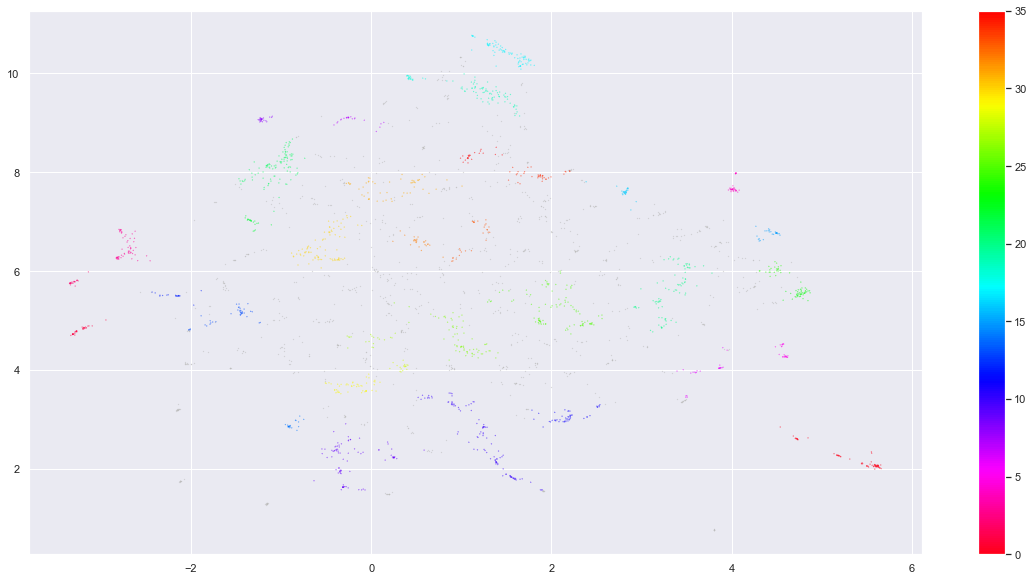

In [94]:
import matplotlib.pyplot as plt

# Prepare data
result = pd.DataFrame(UMAP_roberta, columns=['x', 'y'])
result['labels'] = clusterer.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()

#### Old products clusters df:

In [95]:
desc_df = pd.DataFrame(old_desc, columns=["Desc"])
desc_df['Topic'] = clusterer.labels_
desc_per_topic = desc_df.groupby(['Topic'], as_index = False).agg({'Desc': ' '.join})
desc_df

,Desc,Topic
0,mrs robot soft toy,14
1,garden metal sign,0
2,madras notebook large,11
3,abstract circle journal,11
4,pink diamante pen in gift box,-1
...,...,...
2591,childrens cutlery circus parade,9
2592,pink love heart shape cup,-1
2593,feltcraft girl nicole kit,9
2594,red retrospot peg bag,29


In [96]:
data_df = pd.DataFrame(Old_data1, columns=['Date','StockCode','Year','Month','Week','Day','Weekday','is_weekend','Quantity','Description'])

In [97]:
data_df

,Date,StockCode,Year,Month,Week,Day,Weekday,is_weekend,Quantity,Description
0,2010-12-01,10002,2010,12,48,1,2,0,60,inflatable political globe
1,2010-12-01,10125,2010,12,48,1,2,0,2,mini funky design tapes
2,2010-12-01,10133,2010,12,48,1,2,0,5,colouring pencils brown tube
3,2010-12-01,16014,2010,12,48,1,2,0,10,small chinese style scissor
4,2010-12-01,16016,2010,12,48,1,2,0,10,large chinese style scissor
...,...,...,...,...,...,...,...,...,...,...
196186,2011-12-09,85038,2011,12,49,9,4,0,84,6 chocolate love heart t-lights
196187,2011-12-09,85053,2011,12,49,9,4,0,2,french enamel candleholder
196188,2011-12-09,85066,2011,12,49,9,4,0,4,cream sweetheart mini chest
196189,2011-12-09,85152,2011,12,49,9,4,0,48,hand over the chocolate sign


In [98]:
topics = {}
for i in list(set(clusterer.labels_)):
    if (i !=-1):
        topics["D{0}".format(i)] = list(desc_df["Desc"][desc_df['Topic']== i])

In [410]:
topics.keys()

dict_keys(['D0', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'D16', 'D17', 'D18', 'D19', 'D20', 'D21', 'D22', 'D23', 'D24', 'D25', 'D26', 'D27', 'D28', 'D29', 'D30', 'D31', 'D32', 'D33', 'D34', 'D35'])

In [412]:
data_df['Topic'] = 'Null'
data_df

,Date,StockCode,Year,Month,Week,Day,Weekday,is_weekend,Quantity,Description,Topic
0,2010-12-01,10002,2010,12,48,1,2,0,60,inflatable political globe,Null
1,2010-12-01,10125,2010,12,48,1,2,0,2,mini funky design tapes,Null
2,2010-12-01,10133,2010,12,48,1,2,0,5,colouring pencils brown tube,Null
3,2010-12-01,16014,2010,12,48,1,2,0,10,small chinese style scissor,Null
4,2010-12-01,16016,2010,12,48,1,2,0,10,large chinese style scissor,Null
...,...,...,...,...,...,...,...,...,...,...,...
196186,2011-12-09,85038,2011,12,49,9,4,0,84,6 chocolate love heart t-lights,Null
196187,2011-12-09,85053,2011,12,49,9,4,0,2,french enamel candleholder,Null
196188,2011-12-09,85066,2011,12,49,9,4,0,4,cream sweetheart mini chest,Null
196189,2011-12-09,85152,2011,12,49,9,4,0,48,hand over the chocolate sign,Null


In [413]:
#to add topic -1:
D_1 = list(desc_df["Desc"][desc_df['Topic']== -1])

In [414]:
for index, row in data_df.iterrows():
    if (row['Description'] in D_1):
        data_df['Topic'][index] = -1

In [415]:
for index, row in data_df.iterrows():
    for i in range(len(topics.keys())):
        if (row['Description'] in list(topics.values())[i]):
            data_df['Topic'][index] = i

In [416]:
data_df

,Date,StockCode,Year,Month,Week,Day,Weekday,is_weekend,Quantity,Description,Topic
0,2010-12-01,10002,2010,12,48,1,2,0,60,inflatable political globe,-1
1,2010-12-01,10125,2010,12,48,1,2,0,2,mini funky design tapes,-1
2,2010-12-01,10133,2010,12,48,1,2,0,5,colouring pencils brown tube,10
3,2010-12-01,16014,2010,12,48,1,2,0,10,small chinese style scissor,-1
4,2010-12-01,16016,2010,12,48,1,2,0,10,large chinese style scissor,-1
...,...,...,...,...,...,...,...,...,...,...,...
196186,2011-12-09,85038,2011,12,49,9,4,0,84,6 chocolate love heart t-lights,3
196187,2011-12-09,85053,2011,12,49,9,4,0,2,french enamel candleholder,17
196188,2011-12-09,85066,2011,12,49,9,4,0,4,cream sweetheart mini chest,-1
196189,2011-12-09,85152,2011,12,49,9,4,0,48,hand over the chocolate sign,0


In [417]:
# change stockcode and Topic type to category:
data_df["StockCode"] = data_df["StockCode"].astype('category')
data_df["Topic"] = data_df["Topic"].astype('category')

In [418]:
data_df.dtypes

Date           datetime64[ns]
StockCode            category
Year                    int64
Month                   int64
Week                    int64
Day                     int64
Weekday                 int64
is_weekend               int8
Quantity                int64
Description            object
Topic                category
dtype: object

#### Create df for each Topic:

In [419]:
topics_df = {}
for i in range(len(topics.keys())):
    topics_df["data_df_D{0}".format(i)] = data_df[data_df["Topic"]== i]

In [420]:
data_df_D_1 = data_df[data_df["Topic"]== -1]
data_df_D_1

,Date,StockCode,Year,Month,Week,Day,Weekday,is_weekend,Quantity,Description,Topic
0,2010-12-01,10002,2010,12,48,1,2,0,60,inflatable political globe,-1
1,2010-12-01,10125,2010,12,48,1,2,0,2,mini funky design tapes,-1
3,2010-12-01,16014,2010,12,48,1,2,0,10,small chinese style scissor,-1
4,2010-12-01,16016,2010,12,48,1,2,0,10,large chinese style scissor,-1
8,2010-12-01,20616,2010,12,48,1,2,0,2,cherry blossom passport cover,-1
...,...,...,...,...,...,...,...,...,...,...,...
196104,2011-12-09,23301,2011,12,49,9,4,0,24,gardeners kneeling pad keep calm,-1
196172,2011-12-09,82486,2011,12,49,9,4,0,4,3 drawer antique white wood cabinet,-1
196178,2011-12-09,84380,2011,12,49,9,4,0,5,set of 3 butterfly cookie cutters,-1
196180,2011-12-09,84819,2011,12,49,9,4,0,16,danish rose round sewing box,-1


In [421]:
topics_df['data_df_D2']

,Date,StockCode,Year,Month,Week,Day,Weekday,is_weekend,Quantity,Description,Topic
673,2010-12-01,22876,2010,12,48,1,2,0,1,number tile cottage garden 8,2
7857,2010-12-13,22884,2010,12,50,13,0,0,1,number tile vintage font 5,2
7858,2010-12-13,22887,2010,12,50,13,0,0,1,number tile vintage font 8,2
8576,2010-12-14,22879,2010,12,50,14,1,0,24,number tile vintage font 0,2
8577,2010-12-14,22880,2010,12,50,14,1,0,24,number tile vintage font 1,2
8578,2010-12-14,22881,2010,12,50,14,1,0,24,number tile vintage font 2,2
8579,2010-12-14,22882,2010,12,50,14,1,0,24,number tile vintage font 3,2
8580,2010-12-14,22883,2010,12,50,14,1,0,24,number tile vintage font 4,2
8581,2010-12-14,22884,2010,12,50,14,1,0,24,number tile vintage font 5,2
8582,2010-12-14,22885,2010,12,50,14,1,0,24,number tile vintage font 6,2


In [427]:
topics_df.keys()

dict_keys(['data_df_D0', 'data_df_D1', 'data_df_D2', 'data_df_D3', 'data_df_D4', 'data_df_D5', 'data_df_D6', 'data_df_D7', 'data_df_D8', 'data_df_D9', 'data_df_D10', 'data_df_D11', 'data_df_D12', 'data_df_D13', 'data_df_D14', 'data_df_D15', 'data_df_D16', 'data_df_D17', 'data_df_D18', 'data_df_D19', 'data_df_D20', 'data_df_D21', 'data_df_D22', 'data_df_D23', 'data_df_D24', 'data_df_D25', 'data_df_D26', 'data_df_D27', 'data_df_D28', 'data_df_D29', 'data_df_D30', 'data_df_D31', 'data_df_D32', 'data_df_D33', 'data_df_D34', 'data_df_D35'])

In [423]:
roberta_old_df = {}
for i in topics_df.keys():
    roberta_old_df["roberta_old_{0}".format(i)] = roberta_model.encode(list(set(topics_df[i]['Description'])))

In [425]:
#to add topic -1:
roberta_old_df['roberta_old_data_df_D_1'] = roberta_model.encode(list(set(data_df_D_1['Description'])))

In [428]:
roberta_old_df['roberta_old_data_df_D_1'].shape

(948, 768)

##### Calculate the average embedding for each cluster in old data (roberta_old_average, 768):

In [234]:
data_df.head()
#New_data1["Topic"] = "Null"
#New_data1["Roberta"] = "Null"
New_data1.head()

,Date,StockCode,Year,Month,Week,Day,Weekday,is_weekend,Quantity,UnitPrice,Sales,Description,Topic,Roberta
120864,2011-09-01,23376,2011,9,35,1,3,0,48,0.39,18.72,pack of 12 vintage christmas tissue,Null,Null
120865,2011-09-01,23378,2011,9,35,1,3,0,48,0.39,18.72,pack of 12 50's christmas tissues,Null,Null
120878,2011-09-01,23551,2011,9,35,1,3,0,12,0.39,4.68,pack of 12 paisley park tissues,Null,Null
122173,2011-09-04,23377,2011,9,35,4,6,1,12,0.39,4.68,pack of 12 dolly girl tissues,Null,Null
122174,2011-09-04,23393,2011,9,35,4,6,1,10,3.75,37.50,home sweet home cushion cover,Null,Null


In [237]:
for index, row in New_data1.iterrows():
    New_data1['Roberta'][index] = roberta_model.encode(New_data1["Description"][index])

In [429]:
New_data1.head()

,Date,StockCode,Year,Month,Week,Day,Weekday,is_weekend,Quantity,UnitPrice,Sales,Description,Topic,Roberta
120864,2011-09-01,23376,2011,9,35,1,3,0,48,0.39,18.72,pack of 12 vintage christmas tissue,21,"[0.1195902, -0.23605698, -0.61908984, 0.074357..."
120865,2011-09-01,23378,2011,9,35,1,3,0,48,0.39,18.72,pack of 12 50's christmas tissues,10,"[0.33933693, -0.09333106, -0.2763309, -0.22612..."
120878,2011-09-01,23551,2011,9,35,1,3,0,12,0.39,4.68,pack of 12 paisley park tissues,28,"[-0.07086687, 0.09809864, 0.19068678, 0.695378..."
122173,2011-09-04,23377,2011,9,35,4,6,1,12,0.39,4.68,pack of 12 dolly girl tissues,9,"[0.53562415, 0.066151224, -0.21000576, 0.08583..."
122174,2011-09-04,23393,2011,9,35,4,6,1,10,3.75,37.50,home sweet home cushion cover,25,"[-0.40332574, 1.0793754, -0.3636056, 0.7668577..."


In [168]:
#to add topic -1:
roberta_old_ave_D_1 = []
for i in roberta_old_df['roberta_old_data_df_D_1']:
    roberta_old_ave_D_1.append(i)

In [170]:
len(roberta_old_ave_D_1)

948

In [172]:
roberta_old_average_D_1 = np.mean(roberta_old_ave_D_1, axis=0)
roberta_old_average_D_1.shape

(768,)

In [182]:
roberta_old_ave = {}
roberta_old_average = {}
for i in (list(set(roberta_old_df.keys()))):
    roberta_old_ave[i] = []
    for j in roberta_old_df[i]:
        roberta_old_ave[i].append(j)  
    roberta_old_average[i] = list(np.mean(roberta_old_ave[i], axis=0))


In [430]:
len(roberta_old_average['roberta_old_data_df_D14'])

768

In [431]:
len(list(roberta_old_average.values()))

37

#### Assign topic to each new product using cosine similarity of it's descrription and average robrta of each old clusters:

In [291]:
for index, row in New_data1.iterrows(): 
    all_sentence_combinations = []
    for i in roberta_old_average.keys():
        all_sentence_combinations.append([util.cos_sim(roberta_old_average[i],New_data1['Roberta'][index]),i])
    all_sentence_combinations = sorted(all_sentence_combinations, key=lambda x: x[0], reverse=True)
    print(all_sentence_combinations[0][1])
    New_data1['Topic'][index] = all_sentence_combinations[0][1]

    

roberta_old_data_df_D21
roberta_old_data_df_D10
roberta_old_data_df_D28
roberta_old_data_df_D9
roberta_old_data_df_D25
roberta_old_data_df_D25
roberta_old_data_df_D25
roberta_old_data_df_D25
roberta_old_data_df_D5
roberta_old_data_df_D31
roberta_old_data_df_D31
roberta_old_data_df_D20
roberta_old_data_df_D33
roberta_old_data_df_D_1
roberta_old_data_df_D28
roberta_old_data_df_D21
roberta_old_data_df_D9
roberta_old_data_df_D10
roberta_old_data_df_D33
roberta_old_data_df_D10
roberta_old_data_df_D27
roberta_old_data_df_D31
roberta_old_data_df_D_1
roberta_old_data_df_D0
roberta_old_data_df_D32
roberta_old_data_df_D32
roberta_old_data_df_D16
roberta_old_data_df_D20
roberta_old_data_df_D7
roberta_old_data_df_D4
roberta_old_data_df_D0
roberta_old_data_df_D28
roberta_old_data_df_D10
roberta_old_data_df_D27
roberta_old_data_df_D9
roberta_old_data_df_D25
roberta_old_data_df_D25
roberta_old_data_df_D25
roberta_old_data_df_D25
roberta_old_data_df_D5
roberta_old_data_df_D31
roberta_old_data_df_D1
ro

roberta_old_data_df_D29
roberta_old_data_df_D9
roberta_old_data_df_D25
roberta_old_data_df_D25
roberta_old_data_df_D25
roberta_old_data_df_D25
roberta_old_data_df_D5
roberta_old_data_df_D31
roberta_old_data_df_D31
roberta_old_data_df_D1
roberta_old_data_df_D35
roberta_old_data_df_D0
roberta_old_data_df_D32
roberta_old_data_df_D16
roberta_old_data_df_D20
roberta_old_data_df_D25
roberta_old_data_df_D25
roberta_old_data_df_D33
roberta_old_data_df_D31
roberta_old_data_df_D15
roberta_old_data_df_D_1
roberta_old_data_df_D4
roberta_old_data_df_D0
roberta_old_data_df_D_1
roberta_old_data_df_D21
roberta_old_data_df_D30
roberta_old_data_df_D31
roberta_old_data_df_D9
roberta_old_data_df_D10
roberta_old_data_df_D27
roberta_old_data_df_D29
roberta_old_data_df_D9
roberta_old_data_df_D9
roberta_old_data_df_D29
roberta_old_data_df_D9
roberta_old_data_df_D25
roberta_old_data_df_D25
roberta_old_data_df_D25
roberta_old_data_df_D25
roberta_old_data_df_D5
roberta_old_data_df_D31
roberta_old_data_df_D1
robe

roberta_old_data_df_D21
roberta_old_data_df_D10
roberta_old_data_df_D29
roberta_old_data_df_D9
roberta_old_data_df_D9
roberta_old_data_df_D29
roberta_old_data_df_D9
roberta_old_data_df_D25
roberta_old_data_df_D25
roberta_old_data_df_D5
roberta_old_data_df_D31
roberta_old_data_df_D31
roberta_old_data_df_D1
roberta_old_data_df_D35
roberta_old_data_df_D_1
roberta_old_data_df_D0
roberta_old_data_df_D32
roberta_old_data_df_D32
roberta_old_data_df_D16
roberta_old_data_df_D20
roberta_old_data_df_D23
roberta_old_data_df_D7
roberta_old_data_df_D15
roberta_old_data_df_D24
roberta_old_data_df_D_1
roberta_old_data_df_D4
roberta_old_data_df_D0
roberta_old_data_df_D_1
roberta_old_data_df_D21
roberta_old_data_df_D21
roberta_old_data_df_D29
roberta_old_data_df_D_1
roberta_old_data_df_D1
roberta_old_data_df_D29
roberta_old_data_df_D_1
roberta_old_data_df_D9
roberta_old_data_df_D_1
roberta_old_data_df_D9
roberta_old_data_df_D9
roberta_old_data_df_D9
roberta_old_data_df_D34
roberta_old_data_df_D34
robert

roberta_old_data_df_D29
roberta_old_data_df_D_1
roberta_old_data_df_D9
roberta_old_data_df_D9
roberta_old_data_df_D9
roberta_old_data_df_D34
roberta_old_data_df_D26
roberta_old_data_df_D26
roberta_old_data_df_D34
roberta_old_data_df_D30
roberta_old_data_df_D10
roberta_old_data_df_D26
roberta_old_data_df_D0
roberta_old_data_df_D10
roberta_old_data_df_D9
roberta_old_data_df_D9
roberta_old_data_df_D10
roberta_old_data_df_D26
roberta_old_data_df_D26
roberta_old_data_df_D2
roberta_old_data_df_D24
roberta_old_data_df_D10
roberta_old_data_df_D10
roberta_old_data_df_D31
roberta_old_data_df_D26
roberta_old_data_df_D_1
roberta_old_data_df_D10
roberta_old_data_df_D30
roberta_old_data_df_D29
roberta_old_data_df_D20
roberta_old_data_df_D10
roberta_old_data_df_D10
roberta_old_data_df_D10
roberta_old_data_df_D10
roberta_old_data_df_D10
roberta_old_data_df_D10
roberta_old_data_df_D10
roberta_old_data_df_D21
roberta_old_data_df_D9
roberta_old_data_df_D10
roberta_old_data_df_D10
roberta_old_data_df_D27


roberta_old_data_df_D10
roberta_old_data_df_D10
roberta_old_data_df_D9
roberta_old_data_df_D9
roberta_old_data_df_D10
roberta_old_data_df_D26
roberta_old_data_df_D2
roberta_old_data_df_D24
roberta_old_data_df_D10
roberta_old_data_df_D32
roberta_old_data_df_D31
roberta_old_data_df_D_1
roberta_old_data_df_D26
roberta_old_data_df_D_1
roberta_old_data_df_D10
roberta_old_data_df_D32
roberta_old_data_df_D28
roberta_old_data_df_D30
roberta_old_data_df_D34
roberta_old_data_df_D21
roberta_old_data_df_D20
roberta_old_data_df_D10
roberta_old_data_df_D10
roberta_old_data_df_D10
roberta_old_data_df_D10
roberta_old_data_df_D10
roberta_old_data_df_D10
roberta_old_data_df_D29
roberta_old_data_df_D25
roberta_old_data_df_D25
roberta_old_data_df_D25
roberta_old_data_df_D25
roberta_old_data_df_D5
roberta_old_data_df_D31
roberta_old_data_df_D1
roberta_old_data_df_D_1
roberta_old_data_df_D0
roberta_old_data_df_D20
roberta_old_data_df_D31
roberta_old_data_df_D15
roberta_old_data_df_D24
roberta_old_data_df_D2

roberta_old_data_df_D30
roberta_old_data_df_D32
roberta_old_data_df_D31
roberta_old_data_df_D31
roberta_old_data_df_D3
roberta_old_data_df_D11
roberta_old_data_df_D19
roberta_old_data_df_D29
roberta_old_data_df_D_1
roberta_old_data_df_D16
roberta_old_data_df_D_1
roberta_old_data_df_D1
roberta_old_data_df_D29
roberta_old_data_df_D9
roberta_old_data_df_D9
roberta_old_data_df_D34
roberta_old_data_df_D26
roberta_old_data_df_D34
roberta_old_data_df_D26
roberta_old_data_df_D26
roberta_old_data_df_D26
roberta_old_data_df_D26
roberta_old_data_df_D34
roberta_old_data_df_D34
roberta_old_data_df_D10
roberta_old_data_df_D9
roberta_old_data_df_D9
roberta_old_data_df_D10
roberta_old_data_df_D26
roberta_old_data_df_D24
roberta_old_data_df_D10
roberta_old_data_df_D32
roberta_old_data_df_D31
roberta_old_data_df_D10
roberta_old_data_df_D10
roberta_old_data_df_D30
roberta_old_data_df_D15
roberta_old_data_df_D23
roberta_old_data_df_D23
roberta_old_data_df_D31
roberta_old_data_df_D10
roberta_old_data_df_D1

roberta_old_data_df_D10
roberta_old_data_df_D32
roberta_old_data_df_D31
roberta_old_data_df_D31
roberta_old_data_df_D10
roberta_old_data_df_D_1
roberta_old_data_df_D32
roberta_old_data_df_D28
roberta_old_data_df_D30
roberta_old_data_df_D15
roberta_old_data_df_D15
roberta_old_data_df_D15
roberta_old_data_df_D30
roberta_old_data_df_D30
roberta_old_data_df_D20
roberta_old_data_df_D23
roberta_old_data_df_D31
roberta_old_data_df_D_1
roberta_old_data_df_D_1
roberta_old_data_df_D10
roberta_old_data_df_D10
roberta_old_data_df_D10
roberta_old_data_df_D10
roberta_old_data_df_D21
roberta_old_data_df_D10
roberta_old_data_df_D33
roberta_old_data_df_D27
roberta_old_data_df_D3
roberta_old_data_df_D29
roberta_old_data_df_D9
roberta_old_data_df_D9
roberta_old_data_df_D9
roberta_old_data_df_D25
roberta_old_data_df_D25
roberta_old_data_df_D25
roberta_old_data_df_D25
roberta_old_data_df_D5
roberta_old_data_df_D31
roberta_old_data_df_D1
roberta_old_data_df_D_1
roberta_old_data_df_D32
roberta_old_data_df_D1

roberta_old_data_df_D16
roberta_old_data_df_D_1
roberta_old_data_df_D1
roberta_old_data_df_D_1
roberta_old_data_df_D9
roberta_old_data_df_D_1
roberta_old_data_df_D9
roberta_old_data_df_D9
roberta_old_data_df_D9
roberta_old_data_df_D34
roberta_old_data_df_D26
roberta_old_data_df_D34
roberta_old_data_df_D10
roberta_old_data_df_D9
roberta_old_data_df_D9
roberta_old_data_df_D2
roberta_old_data_df_D24
roberta_old_data_df_D10
roberta_old_data_df_D32
roberta_old_data_df_D10
roberta_old_data_df_D_1
roberta_old_data_df_D10
roberta_old_data_df_D32
roberta_old_data_df_D28
roberta_old_data_df_D32
roberta_old_data_df_D32
roberta_old_data_df_D27
roberta_old_data_df_D_1
roberta_old_data_df_D13
roberta_old_data_df_D0
roberta_old_data_df_D30
roberta_old_data_df_D10
roberta_old_data_df_D32
roberta_old_data_df_D1
roberta_old_data_df_D20
roberta_old_data_df_D21
roberta_old_data_df_D20
roberta_old_data_df_D_1
roberta_old_data_df_D10
roberta_old_data_df_D10
roberta_old_data_df_D10
roberta_old_data_df_D10
ro

roberta_old_data_df_D31
roberta_old_data_df_D31
roberta_old_data_df_D3
roberta_old_data_df_D11
roberta_old_data_df_D31
roberta_old_data_df_D31
roberta_old_data_df_D31
roberta_old_data_df_D31
roberta_old_data_df_D30
roberta_old_data_df_D19
roberta_old_data_df_D31
roberta_old_data_df_D8
roberta_old_data_df_D19
roberta_old_data_df_D8
roberta_old_data_df_D_1
roberta_old_data_df_D10
roberta_old_data_df_D_1
roberta_old_data_df_D1
roberta_old_data_df_D29
roberta_old_data_df_D_1
roberta_old_data_df_D_1
roberta_old_data_df_D9
roberta_old_data_df_D9
roberta_old_data_df_D9
roberta_old_data_df_D34
roberta_old_data_df_D26
roberta_old_data_df_D26
roberta_old_data_df_D34
roberta_old_data_df_D10
roberta_old_data_df_D14
roberta_old_data_df_D_1
roberta_old_data_df_D26
roberta_old_data_df_D30
roberta_old_data_df_D0
roberta_old_data_df_D10
roberta_old_data_df_D9
roberta_old_data_df_D9
roberta_old_data_df_D10
roberta_old_data_df_D26
roberta_old_data_df_D26
roberta_old_data_df_D2
roberta_old_data_df_D24
rob

roberta_old_data_df_D32
roberta_old_data_df_D32
roberta_old_data_df_D27
roberta_old_data_df_D_1
roberta_old_data_df_D13
roberta_old_data_df_D0
roberta_old_data_df_D10
roberta_old_data_df_D32
roberta_old_data_df_D1
roberta_old_data_df_D28
roberta_old_data_df_D29
roberta_old_data_df_D28
roberta_old_data_df_D29
roberta_old_data_df_D_1
roberta_old_data_df_D20
roberta_old_data_df_D_1
roberta_old_data_df_D10
roberta_old_data_df_D10
roberta_old_data_df_D10
roberta_old_data_df_D10
roberta_old_data_df_D10
roberta_old_data_df_D10
roberta_old_data_df_D21
roberta_old_data_df_D10
roberta_old_data_df_D27
roberta_old_data_df_D3
roberta_old_data_df_D29
roberta_old_data_df_D9
roberta_old_data_df_D9
roberta_old_data_df_D25
roberta_old_data_df_D25
roberta_old_data_df_D5
roberta_old_data_df_D0
roberta_old_data_df_D32
roberta_old_data_df_D32
roberta_old_data_df_D20
roberta_old_data_df_D25
roberta_old_data_df_D25
roberta_old_data_df_D7
roberta_old_data_df_D8
roberta_old_data_df_D20
roberta_old_data_df_D24
r

roberta_old_data_df_D31
roberta_old_data_df_D11
roberta_old_data_df_D31
roberta_old_data_df_D31
roberta_old_data_df_D31
roberta_old_data_df_D31
roberta_old_data_df_D31
roberta_old_data_df_D31
roberta_old_data_df_D17
roberta_old_data_df_D33
roberta_old_data_df_D33
roberta_old_data_df_D19
roberta_old_data_df_D31
roberta_old_data_df_D13
roberta_old_data_df_D8
roberta_old_data_df_D19
roberta_old_data_df_D8
roberta_old_data_df_D8
roberta_old_data_df_D29
roberta_old_data_df_D_1
roberta_old_data_df_D20
roberta_old_data_df_D5
roberta_old_data_df_D8
roberta_old_data_df_D10
roberta_old_data_df_D16
roberta_old_data_df_D16
roberta_old_data_df_D_1
roberta_old_data_df_D1
roberta_old_data_df_D29
roberta_old_data_df_D_1
roberta_old_data_df_D9
roberta_old_data_df_D_1
roberta_old_data_df_D9
roberta_old_data_df_D9
roberta_old_data_df_D34
roberta_old_data_df_D34
roberta_old_data_df_D26
roberta_old_data_df_D26
roberta_old_data_df_D26
roberta_old_data_df_D34
roberta_old_data_df_D0
roberta_old_data_df_D24
ro

roberta_old_data_df_D26
roberta_old_data_df_D24
roberta_old_data_df_D10
roberta_old_data_df_D10
roberta_old_data_df_D_1
roberta_old_data_df_D10
roberta_old_data_df_D32
roberta_old_data_df_D28
roberta_old_data_df_D32
roberta_old_data_df_D32
roberta_old_data_df_D27
roberta_old_data_df_D_1
roberta_old_data_df_D13
roberta_old_data_df_D30
roberta_old_data_df_D15
roberta_old_data_df_D15
roberta_old_data_df_D10
roberta_old_data_df_D32
roberta_old_data_df_D1
roberta_old_data_df_D29
roberta_old_data_df_D28
roberta_old_data_df_D23
roberta_old_data_df_D23
roberta_old_data_df_D29
roberta_old_data_df_D26
roberta_old_data_df_D21
roberta_old_data_df_D20
roberta_old_data_df_D10
roberta_old_data_df_D10
roberta_old_data_df_D10
roberta_old_data_df_D10
roberta_old_data_df_D10
roberta_old_data_df_D10
roberta_old_data_df_D10
roberta_old_data_df_D21
roberta_old_data_df_D10
roberta_old_data_df_D10
roberta_old_data_df_D27
roberta_old_data_df_D3
roberta_old_data_df_D29
roberta_old_data_df_D9
roberta_old_data_df

roberta_old_data_df_D9
roberta_old_data_df_D9
roberta_old_data_df_D9
roberta_old_data_df_D25
roberta_old_data_df_D25
roberta_old_data_df_D25
roberta_old_data_df_D25
roberta_old_data_df_D5
roberta_old_data_df_D31
roberta_old_data_df_D1
roberta_old_data_df_D35
roberta_old_data_df_D0
roberta_old_data_df_D32
roberta_old_data_df_D32
roberta_old_data_df_D16
roberta_old_data_df_D25
roberta_old_data_df_D23
roberta_old_data_df_D8
roberta_old_data_df_D15
roberta_old_data_df_D_1
roberta_old_data_df_D0
roberta_old_data_df_D_1
roberta_old_data_df_D21
roberta_old_data_df_D32
roberta_old_data_df_D31
roberta_old_data_df_D32
roberta_old_data_df_D32
roberta_old_data_df_D35
roberta_old_data_df_D35
roberta_old_data_df_D35
roberta_old_data_df_D_1
roberta_old_data_df_D33
roberta_old_data_df_D30
roberta_old_data_df_D35
roberta_old_data_df_D30
roberta_old_data_df_D30
roberta_old_data_df_D32
roberta_old_data_df_D31
roberta_old_data_df_D31
roberta_old_data_df_D3
roberta_old_data_df_D11
roberta_old_data_df_D31
r

roberta_old_data_df_D25
roberta_old_data_df_D33
roberta_old_data_df_D23
roberta_old_data_df_D20
roberta_old_data_df_D15
roberta_old_data_df_D15
roberta_old_data_df_D4
roberta_old_data_df_D0
roberta_old_data_df_D21
roberta_old_data_df_D21
roberta_old_data_df_D32
roberta_old_data_df_D31
roberta_old_data_df_D32
roberta_old_data_df_D32
roberta_old_data_df_D35
roberta_old_data_df_D35
roberta_old_data_df_D35
roberta_old_data_df_D33
roberta_old_data_df_D30
roberta_old_data_df_D30
roberta_old_data_df_D31
roberta_old_data_df_D3
roberta_old_data_df_D11
roberta_old_data_df_D31
roberta_old_data_df_D31
roberta_old_data_df_D31
roberta_old_data_df_D30
roberta_old_data_df_D17
roberta_old_data_df_D33
roberta_old_data_df_D19
roberta_old_data_df_D13
roberta_old_data_df_D8
roberta_old_data_df_D19
roberta_old_data_df_D8
roberta_old_data_df_D8
roberta_old_data_df_D_1
roberta_old_data_df_D20
roberta_old_data_df_D10
roberta_old_data_df_D16
roberta_old_data_df_D16
roberta_old_data_df_D_1
roberta_old_data_df_D1

roberta_old_data_df_D8
roberta_old_data_df_D29
roberta_old_data_df_D_1
roberta_old_data_df_D20
roberta_old_data_df_D5
roberta_old_data_df_D8
roberta_old_data_df_D10
roberta_old_data_df_D16
roberta_old_data_df_D16
roberta_old_data_df_D1
roberta_old_data_df_D29
roberta_old_data_df_D9
roberta_old_data_df_D_1
roberta_old_data_df_D9
roberta_old_data_df_D9
roberta_old_data_df_D9
roberta_old_data_df_D10
roberta_old_data_df_D24
roberta_old_data_df_D31
roberta_old_data_df_D10
roberta_old_data_df_D10
roberta_old_data_df_D10
roberta_old_data_df_D32
roberta_old_data_df_D32
roberta_old_data_df_D_1
roberta_old_data_df_D13
roberta_old_data_df_D0
roberta_old_data_df_D30
roberta_old_data_df_D15
roberta_old_data_df_D15
roberta_old_data_df_D15
roberta_old_data_df_D30
roberta_old_data_df_D10
roberta_old_data_df_D1
roberta_old_data_df_D28
roberta_old_data_df_D29
roberta_old_data_df_D28
roberta_old_data_df_D28
roberta_old_data_df_D23
roberta_old_data_df_D23
roberta_old_data_df_D29
roberta_old_data_df_D28
ro

roberta_old_data_df_D34
roberta_old_data_df_D29
roberta_old_data_df_D_1
roberta_old_data_df_D20
roberta_old_data_df_D3
roberta_old_data_df_D_1
roberta_old_data_df_D10
roberta_old_data_df_D10
roberta_old_data_df_D10
roberta_old_data_df_D10
roberta_old_data_df_D10
roberta_old_data_df_D10
roberta_old_data_df_D21
roberta_old_data_df_D9
roberta_old_data_df_D10
roberta_old_data_df_D33
roberta_old_data_df_D3
roberta_old_data_df_D9
roberta_old_data_df_D9
roberta_old_data_df_D25
roberta_old_data_df_D25
roberta_old_data_df_D25
roberta_old_data_df_D31
roberta_old_data_df_D31
roberta_old_data_df_D35
roberta_old_data_df_D0
roberta_old_data_df_D32
roberta_old_data_df_D25
roberta_old_data_df_D25
roberta_old_data_df_D27
roberta_old_data_df_D5
roberta_old_data_df_D5
roberta_old_data_df_D5
roberta_old_data_df_D21
roberta_old_data_df_D10
roberta_old_data_df_D30
roberta_old_data_df_D32
roberta_old_data_df_D31
roberta_old_data_df_D32
roberta_old_data_df_D32
roberta_old_data_df_D35
roberta_old_data_df_D_1
r

roberta_old_data_df_D32
roberta_old_data_df_D31
roberta_old_data_df_D32
roberta_old_data_df_D32
roberta_old_data_df_D_1
roberta_old_data_df_D33
roberta_old_data_df_D30
roberta_old_data_df_D35
roberta_old_data_df_D27
roberta_old_data_df_D31
roberta_old_data_df_D31
roberta_old_data_df_D11
roberta_old_data_df_D31
roberta_old_data_df_D17
roberta_old_data_df_D33
roberta_old_data_df_D33
roberta_old_data_df_D19
roberta_old_data_df_D31
roberta_old_data_df_D8
roberta_old_data_df_D19
roberta_old_data_df_D8
roberta_old_data_df_D8
roberta_old_data_df_D29
roberta_old_data_df_D_1
roberta_old_data_df_D20
roberta_old_data_df_D5
roberta_old_data_df_D16
roberta_old_data_df_D1
roberta_old_data_df_D29
roberta_old_data_df_D_1
roberta_old_data_df_D9
roberta_old_data_df_D_1
roberta_old_data_df_D9
roberta_old_data_df_D9
roberta_old_data_df_D26
roberta_old_data_df_D26
roberta_old_data_df_D10
roberta_old_data_df_D0
roberta_old_data_df_D9
roberta_old_data_df_D10
roberta_old_data_df_D26
roberta_old_data_df_D24
ro

roberta_old_data_df_D_1
roberta_old_data_df_D8
roberta_old_data_df_D32
roberta_old_data_df_D10
roberta_old_data_df_D16
roberta_old_data_df_D_1
roberta_old_data_df_D1
roberta_old_data_df_D29
roberta_old_data_df_D_1
roberta_old_data_df_D9
roberta_old_data_df_D_1
roberta_old_data_df_D9
roberta_old_data_df_D9
roberta_old_data_df_D9
roberta_old_data_df_D34
roberta_old_data_df_D26
roberta_old_data_df_D26
roberta_old_data_df_D26
roberta_old_data_df_D34
roberta_old_data_df_D26
roberta_old_data_df_D30
roberta_old_data_df_D10
roberta_old_data_df_D10
roberta_old_data_df_D9
roberta_old_data_df_D10
roberta_old_data_df_D26
roberta_old_data_df_D2
roberta_old_data_df_D24
roberta_old_data_df_D32
roberta_old_data_df_D10
roberta_old_data_df_D32
roberta_old_data_df_D10
roberta_old_data_df_D10
roberta_old_data_df_D32
roberta_old_data_df_D0
roberta_old_data_df_D30
roberta_old_data_df_D3
roberta_old_data_df_D10
roberta_old_data_df_D1
roberta_old_data_df_D28
roberta_old_data_df_D_1
roberta_old_data_df_D_1
rob

roberta_old_data_df_D28
roberta_old_data_df_D10
roberta_old_data_df_D32
roberta_old_data_df_D27
roberta_old_data_df_D_1
roberta_old_data_df_D0
roberta_old_data_df_D3
roberta_old_data_df_D3
roberta_old_data_df_D3
roberta_old_data_df_D15
roberta_old_data_df_D15
roberta_old_data_df_D10
roberta_old_data_df_D32
roberta_old_data_df_D1
roberta_old_data_df_D28
roberta_old_data_df_D_1
roberta_old_data_df_D20
roberta_old_data_df_D32
roberta_old_data_df_D28
roberta_old_data_df_D29
roberta_old_data_df_D28
roberta_old_data_df_D28
roberta_old_data_df_D26
roberta_old_data_df_D23
roberta_old_data_df_D29
roberta_old_data_df_D26
roberta_old_data_df_D28
roberta_old_data_df_D26
roberta_old_data_df_D26
roberta_old_data_df_D34
roberta_old_data_df_D29
roberta_old_data_df_D21
roberta_old_data_df_D31
roberta_old_data_df_D_1
roberta_old_data_df_D20
roberta_old_data_df_D_1
roberta_old_data_df_D1
roberta_old_data_df_D1
roberta_old_data_df_D10
roberta_old_data_df_D10
roberta_old_data_df_D10
roberta_old_data_df_D10

roberta_old_data_df_D5
roberta_old_data_df_D5
roberta_old_data_df_D5
roberta_old_data_df_D7
roberta_old_data_df_D27
roberta_old_data_df_D17
roberta_old_data_df_D8
roberta_old_data_df_D29
roberta_old_data_df_D32
roberta_old_data_df_D1
roberta_old_data_df_D26
roberta_old_data_df_D26
roberta_old_data_df_D30
roberta_old_data_df_D10
roberta_old_data_df_D10
roberta_old_data_df_D2
roberta_old_data_df_D10
roberta_old_data_df_D31
roberta_old_data_df_D10
roberta_old_data_df_D3
roberta_old_data_df_D3
roberta_old_data_df_D32
roberta_old_data_df_D1
roberta_old_data_df_D28
roberta_old_data_df_D26
roberta_old_data_df_D29


In [432]:
New_data1['Topic'].value_counts()

 10    897
-1     510
 31    468
 9     465
 32    395
 25    374
 26    369
 29    309
 30    228
 20    192
 21    184
 0     176
 34    174
 1     170
 33    166
 15    165
 8     160
 28    160
 16    155
 35    137
 5     118
 3     111
 19    107
 27    101
 24     75
 23     65
 4      58
 7      51
 13     49
 17     40
 2      35
 18     26
 11     24
 14     16
Name: Topic, dtype: int64

In [556]:
new_topics = pd.DataFrame(New_data1['Topic'].value_counts())
new_topics = new_topics.reset_index()
new_topics
#there is no index 6, 12

,index,Topic
0,10,897
1,-1,510
2,31,468
3,9,465
4,32,395
5,25,374
6,26,369
7,29,309
8,30,228
9,20,192


In [552]:
new_topics.keys()

Index(['index', 'Topic'], dtype='object')

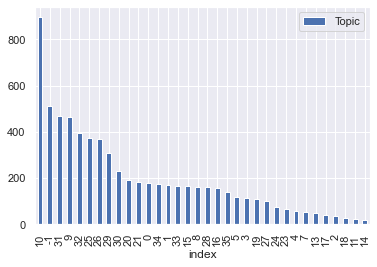

In [434]:
new_topics.plot(x='index', y='Topic', kind="bar")
plt.show()

In [435]:
New_data1.head()

,Date,StockCode,Year,Month,Week,Day,Weekday,is_weekend,Quantity,UnitPrice,Sales,Description,Topic,Roberta
120864,2011-09-01,23376,2011,9,35,1,3,0,48,0.39,18.72,pack of 12 vintage christmas tissue,21,"[0.1195902, -0.23605698, -0.61908984, 0.074357..."
120865,2011-09-01,23378,2011,9,35,1,3,0,48,0.39,18.72,pack of 12 50's christmas tissues,10,"[0.33933693, -0.09333106, -0.2763309, -0.22612..."
120878,2011-09-01,23551,2011,9,35,1,3,0,12,0.39,4.68,pack of 12 paisley park tissues,28,"[-0.07086687, 0.09809864, 0.19068678, 0.695378..."
122173,2011-09-04,23377,2011,9,35,4,6,1,12,0.39,4.68,pack of 12 dolly girl tissues,9,"[0.53562415, 0.066151224, -0.21000576, 0.08583..."
122174,2011-09-04,23393,2011,9,35,4,6,1,10,3.75,37.50,home sweet home cushion cover,25,"[-0.40332574, 1.0793754, -0.3636056, 0.7668577..."


In [510]:
'''
for index, row in New_data1.iterrows():
    if New_data1['Topic'][index] == "roberta_old_data_df_D0":
        New_data1['Topic'][index] = 0
    elif New_data1['Topic'][index] == "roberta_old_data_df_D1":
        New_data1['Topic'][index] = 1
    elif New_data1['Topic'][index] == "roberta_old_data_df_D2":
        New_data1['Topic'][index] = 2
    elif New_data1['Topic'][index] == "roberta_old_data_df_D3":
        New_data1['Topic'][index] = 3
    elif New_data1['Topic'][index] == "roberta_old_data_df_D4":
        New_data1['Topic'][index] = 4
    elif New_data1['Topic'][index] == "roberta_old_data_df_D5":
        New_data1['Topic'][index] = 5
    elif New_data1['Topic'][index] == "roberta_old_data_df_D6":
        New_data1['Topic'][index] = 6
    elif New_data1['Topic'][index] == "roberta_old_data_df_D7":
        New_data1['Topic'][index] = 7
    elif New_data1['Topic'][index] == "roberta_old_data_df_D8":
        New_data1['Topic'][index] = 8
    elif New_data1['Topic'][index] == "roberta_old_data_df_D9":
        New_data1['Topic'][index] = 9
    elif New_data1['Topic'][index] == "roberta_old_data_df_D10":
        New_data1['Topic'][index] = 10
    elif New_data1['Topic'][index] == "roberta_old_data_df_D11":
        New_data1['Topic'][index] = 11
    elif New_data1['Topic'][index] == "roberta_old_data_df_D12":
        New_data1['Topic'][index] = 12
    elif New_data1['Topic'][index] == "roberta_old_data_df_D13":
        New_data1['Topic'][index] = 13
    elif New_data1['Topic'][index] == "roberta_old_data_df_D14":
        New_data1['Topic'][index] = 14
    elif New_data1['Topic'][index] == "roberta_old_data_df_D15":
        New_data1['Topic'][index] = 15
    elif New_data1['Topic'][index] == "roberta_old_data_df_D16":
        New_data1['Topic'][index] = 16
    elif New_data1['Topic'][index] == "roberta_old_data_df_D17":
        New_data1['Topic'][index] = 17
    elif New_data1['Topic'][index] == "roberta_old_data_df_D18":
        New_data1['Topic'][index] = 18
    elif New_data1['Topic'][index] == "roberta_old_data_df_D19":
        New_data1['Topic'][index] = 19
    elif New_data1['Topic'][index] == "roberta_old_data_df_D20":
        New_data1['Topic'][index] = 20
    elif New_data1['Topic'][index] == "roberta_old_data_df_D21":
        New_data1['Topic'][index] = 21
    elif New_data1['Topic'][index] == "roberta_old_data_df_D22":
        New_data1['Topic'][index] = 22
    elif New_data1['Topic'][index] == "roberta_old_data_df_D23":
        New_data1['Topic'][index] = 23
    elif New_data1['Topic'][index] == "roberta_old_data_df_D24":
        New_data1['Topic'][index] = 24
    elif New_data1['Topic'][index] == "roberta_old_data_df_D25":
        New_data1['Topic'][index] = 25
    elif New_data1['Topic'][index] == "roberta_old_data_df_D26":
        New_data1['Topic'][index] = 26
    elif New_data1['Topic'][index] == "roberta_old_data_df_D27":
        New_data1['Topic'][index] = 27
    elif New_data1['Topic'][index] == "roberta_old_data_df_D28":
        New_data1['Topic'][index] = 28
    elif New_data1['Topic'][index] == "roberta_old_data_df_D29":
        New_data1['Topic'][index] = 29
    elif New_data1['Topic'][index] == "roberta_old_data_df_D30":
        New_data1['Topic'][index] = 30
    elif New_data1['Topic'][index] == "roberta_old_data_df_D31":
        New_data1['Topic'][index] = 31
    elif New_data1['Topic'][index] == "roberta_old_data_df_D32":
        New_data1['Topic'][index] = 32
    elif New_data1['Topic'][index] == "roberta_old_data_df_D33":
        New_data1['Topic'][index] = 33
    elif New_data1['Topic'][index] == "roberta_old_data_df_D34":
        New_data1['Topic'][index] = 34
    elif New_data1['Topic'][index] == "roberta_old_data_df_D35":
        New_data1['Topic'][index] = 35
    elif New_data1['Topic'][index] == "roberta_old_data_df_D_1":
        New_data1['Topic'][index] = -1
'''

'\nfor index, row in New_data1.iterrows():\n    if New_data1[\'Topic\'][index] == "roberta_old_data_df_D0":\n        New_data1[\'Topic\'][index] = 0\n    elif New_data1[\'Topic\'][index] == "roberta_old_data_df_D1":\n        New_data1[\'Topic\'][index] = 1\n    elif New_data1[\'Topic\'][index] == "roberta_old_data_df_D2":\n        New_data1[\'Topic\'][index] = 2\n    elif New_data1[\'Topic\'][index] == "roberta_old_data_df_D3":\n        New_data1[\'Topic\'][index] = 3\n    elif New_data1[\'Topic\'][index] == "roberta_old_data_df_D4":\n        New_data1[\'Topic\'][index] = 4\n    elif New_data1[\'Topic\'][index] == "roberta_old_data_df_D5":\n        New_data1[\'Topic\'][index] = 5\n    elif New_data1[\'Topic\'][index] == "roberta_old_data_df_D6":\n        New_data1[\'Topic\'][index] = 6\n    elif New_data1[\'Topic\'][index] == "roberta_old_data_df_D7":\n        New_data1[\'Topic\'][index] = 7\n    elif New_data1[\'Topic\'][index] == "roberta_old_data_df_D8":\n        New_data1[\'Topic\'

In [557]:
New_data1

,Date,StockCode,Year,Month,Week,Day,Weekday,is_weekend,Quantity,UnitPrice,Sales,Description,Topic,Roberta
120864,2011-09-01,23376,2011,9,35,1,3,0,48,0.390,18.72,pack of 12 vintage christmas tissue,21,"[0.1195902, -0.23605698, -0.61908984, 0.074357..."
120865,2011-09-01,23378,2011,9,35,1,3,0,48,0.390,18.72,pack of 12 50's christmas tissues,10,"[0.33933693, -0.09333106, -0.2763309, -0.22612..."
120878,2011-09-01,23551,2011,9,35,1,3,0,12,0.390,4.68,pack of 12 paisley park tissues,28,"[-0.07086687, 0.09809864, 0.19068678, 0.695378..."
122173,2011-09-04,23377,2011,9,35,4,6,1,12,0.390,4.68,pack of 12 dolly girl tissues,9,"[0.53562415, 0.066151224, -0.21000576, 0.08583..."
122174,2011-09-04,23393,2011,9,35,4,6,1,10,3.750,37.50,home sweet home cushion cover,25,"[-0.40332574, 1.0793754, -0.3636056, 0.7668577..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196160,2011-12-09,23570,2011,12,49,9,4,0,24,1.250,30.00,traditional pick up sticks game,32,"[-0.36970547, -0.24336004, 0.94245136, 0.58942..."
196161,2011-12-09,23571,2011,12,49,9,4,0,12,1.650,19.80,traditional naughts & crosses,1,"[0.53560066, 1.0924453, -0.42377457, 0.4970222..."
196162,2011-12-09,23581,2011,12,49,9,4,0,50,1.935,92.40,jumbo bag paisley park,28,"[-0.44290894, 0.23070298, -0.26067546, 1.23004..."
196163,2011-12-09,23598,2011,12,49,9,4,0,6,2.950,17.70,paper bunting vintage party,26,"[-0.28610197, 0.26283798, -0.57556075, 0.51279..."


#### Run LGBM on all new product, without topic clusters: 

In [448]:
x_tr_df = New_data1[New_data1['Date'] <= '2011-11-01'].drop(['Date','Description','Topic','Quantity','Roberta','Sales','UnitPrice'],axis = 1)

In [449]:
y_tr_df = New_data1[New_data1['Date'] <= '2011-11-01']['Quantity']

In [450]:
x_val_df = New_data1[(New_data1['Date'] > '2011-11-01') & (New_data1['Date'] <= '2011-12-01')].drop(['Date','Description','Topic','Quantity','Roberta','Sales','UnitPrice'],axis = 1)

In [451]:
y_val_df = New_data1[(New_data1['Date'] > '2011-11-01') & (New_data1['Date'] <= '2011-12-01')]['Quantity']

In [452]:
x_te_df = New_data1[ (New_data1['Date'] > '2011-12-01')].drop(['Date','Description','Topic','Quantity','Roberta','Sales','UnitPrice'],axis = 1)

In [453]:
y_te_df = New_data1[ (New_data1['Date'] > '2011-12-01')]['Quantity']

In [454]:
New_data1["StockCode"] = New_data1["StockCode"].astype('category')

#### LGBM Model on all NEW products:

In [455]:
import optuna
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error

#optimization:
def objective(trial):



        param = {
            'metric': 'rmse', 
            'random_state': 48,
            'n_estimators': 20000,
            'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
            'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
            'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
            'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
            'learning_rate': trial.suggest_categorical('learning_rate', [0.006,0.008,0.01,0.014,0.017,0.02]),
            'max_depth': trial.suggest_categorical('max_depth', [10,20,100]),
            'num_leaves' : trial.suggest_int('num_leaves', 10, 1000),# 32,64,.... descrite 
            'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
            'cat_smooth' : trial.suggest_int('min_data_per_groups', 1, 100)
        }


        model_new_df = LGBMRegressor(**param)
        model_new_df.fit(x_tr_df,y_tr_df,
                                        eval_set=[(x_val_df,y_val_df)],early_stopping_rounds=100,verbose=False)
        pred_new_df = model_new_df.predict(x_te_df)
        rmse_new_df = mean_squared_error(y_te_df, model_new_df.predict(x_te_df), squared=False)

        return rmse_new_df    
    
    
    
    

In [456]:
# the objective of our fuction is to minimize the RMSE that's why direction='minimize':
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
params=study.best_params   


model_new_df= LGBMRegressor(**params)
model_new_df.fit(x_tr_df,y_tr_df, eval_set=[(x_val_df,y_val_df)],early_stopping_rounds=100,verbose=False)
pred_new_df = model_new_df.predict(x_te_df)
rmse_new_df = mean_squared_error(y_te_df, model_new_df.predict(x_te_df), squared=False)
rmseVal_new_df = mean_squared_error(y_val_df, model_new_df.predict(x_val_df), squared=False)



[I 2021-09-23 12:49:01,874] A new study created in memory with name: no-name-a33460de-6e82-4e9d-81fc-20f3e44fa293
[I 2021-09-23 12:49:01,958] Trial 0 finished with value: 16.64252230587389 and parameters: {'reg_alpha': 0.00194914305311642, 'reg_lambda': 0.36216405209211155, 'colsample_bytree': 0.3, 'subsample': 1.0, 'learning_rate': 0.02, 'max_depth': 10, 'num_leaves': 60, 'min_child_samples': 247, 'min_data_per_groups': 72}. Best is trial 0 with value: 16.64252230587389.
[I 2021-09-23 12:49:02,068] Trial 1 finished with value: 16.672795635113278 and parameters: {'reg_alpha': 0.10613809901726028, 'reg_lambda': 0.019601281497731434, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.008, 'max_depth': 10, 'num_leaves': 420, 'min_child_samples': 268, 'min_data_per_groups': 94}. Best is trial 0 with value: 16.64252230587389.
[I 2021-09-23 12:49:02,174] Trial 2 finished with value: 16.686564537634762 and parameters: {'reg_alpha': 0.441808880815051, 'reg_lambda': 0.242333848227957

[I 2021-09-23 12:49:17,947] Trial 22 finished with value: 15.727196428910357 and parameters: {'reg_alpha': 3.0157035133612493, 'reg_lambda': 0.00172638720670446, 'colsample_bytree': 0.5, 'subsample': 0.5, 'learning_rate': 0.014, 'max_depth': 20, 'num_leaves': 765, 'min_child_samples': 70, 'min_data_per_groups': 1}. Best is trial 22 with value: 15.727196428910357.
[I 2021-09-23 12:49:18,428] Trial 23 finished with value: 16.41147576316346 and parameters: {'reg_alpha': 0.34254711360978085, 'reg_lambda': 0.007854818025890884, 'colsample_bytree': 0.5, 'subsample': 0.5, 'learning_rate': 0.014, 'max_depth': 20, 'num_leaves': 762, 'min_child_samples': 72, 'min_data_per_groups': 13}. Best is trial 22 with value: 15.727196428910357.
[I 2021-09-23 12:49:19,025] Trial 24 finished with value: 16.476223706712197 and parameters: {'reg_alpha': 3.5603805686169534, 'reg_lambda': 0.0018379812412546237, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.006, 'max_depth': 20, 'num_leaves': 808,

[I 2021-09-23 12:49:33,786] Trial 44 finished with value: 15.79342396241179 and parameters: {'reg_alpha': 0.12579016624068068, 'reg_lambda': 1.8413913565893452, 'colsample_bytree': 0.3, 'subsample': 0.8, 'learning_rate': 0.017, 'max_depth': 20, 'num_leaves': 730, 'min_child_samples': 78, 'min_data_per_groups': 2}. Best is trial 22 with value: 15.727196428910357.
[I 2021-09-23 12:49:35,358] Trial 45 finished with value: 15.771087115692591 and parameters: {'reg_alpha': 0.11310495020388572, 'reg_lambda': 3.1089105878122743, 'colsample_bytree': 0.3, 'subsample': 1.0, 'learning_rate': 0.014, 'max_depth': 20, 'num_leaves': 834, 'min_child_samples': 78, 'min_data_per_groups': 1}. Best is trial 22 with value: 15.727196428910357.
[I 2021-09-23 12:49:35,517] Trial 46 finished with value: 16.674234551801597 and parameters: {'reg_alpha': 0.0012341145386788339, 'reg_lambda': 3.275870355826153, 'colsample_bytree': 0.3, 'subsample': 1.0, 'learning_rate': 0.014, 'max_depth': 20, 'num_leaves': 837, 'mi

Number of finished trials: 50
Best trial: {'reg_alpha': 3.0157035133612493, 'reg_lambda': 0.00172638720670446, 'colsample_bytree': 0.5, 'subsample': 0.5, 'learning_rate': 0.014, 'max_depth': 20, 'num_leaves': 765, 'min_child_samples': 70, 'min_data_per_groups': 1}
[LightGBM] [Warning] Unknown parameter: min_data_per_groups


In [457]:
rmse_new_df

16.24236014524381

#### Run LGBM on new product, for each topic clusters: 

In [397]:
#creat df for each topic:

In [461]:
New_data = New_data1.drop(['Roberta','UnitPrice','Sales'],axis = 1)
New_data

,Date,StockCode,Year,Month,Week,Day,Weekday,is_weekend,Quantity,Description,Topic
120864,2011-09-01,23376,2011,9,35,1,3,0,48,pack of 12 vintage christmas tissue,21
120865,2011-09-01,23378,2011,9,35,1,3,0,48,pack of 12 50's christmas tissues,10
120878,2011-09-01,23551,2011,9,35,1,3,0,12,pack of 12 paisley park tissues,28
122173,2011-09-04,23377,2011,9,35,4,6,1,12,pack of 12 dolly girl tissues,9
122174,2011-09-04,23393,2011,9,35,4,6,1,10,home sweet home cushion cover,25
...,...,...,...,...,...,...,...,...,...,...,...
196160,2011-12-09,23570,2011,12,49,9,4,0,24,traditional pick up sticks game,32
196161,2011-12-09,23571,2011,12,49,9,4,0,12,traditional naughts & crosses,1
196162,2011-12-09,23581,2011,12,49,9,4,0,50,jumbo bag paisley park,28
196163,2011-12-09,23598,2011,12,49,9,4,0,6,paper bunting vintage party,26


In [561]:
# change Topic type to category:
New_data["Topic"] = New_data["Topic"].astype('category')

In [562]:
New_data.dtypes

Date           datetime64[ns]
StockCode            category
Year                    int64
Month                   int64
Week                    int64
Day                     int64
Weekday                 int64
is_weekend               int8
Quantity                int64
Description            object
Topic                category
dtype: object

In [463]:
topics_new_df = {}
for i in set(New_data["Topic"]):
    topics_new_df["New_data_D{0}".format(i)] = New_data[New_data["Topic"]== i]

In [503]:
topics_new_df['New_data_D-1']

,Date,StockCode,Year,Month,Week,Day,Weekday,is_weekend,Quantity,Description,Topic
122183,2011-09-04,23427,2011,9,35,4,6,1,2,stool home sweet home,-1
122878,2011-09-05,23402,2011,9,36,5,0,0,1,home sweeet home 3 peg hanger,-1
123503,2011-09-06,23427,2011,9,36,6,1,0,2,stool home sweet home,-1
124093,2011-09-07,23402,2011,9,36,7,2,0,2,home sweet home 3 peg hanger,-1
124105,2011-09-07,23427,2011,9,36,7,2,0,2,stool home sweet home,-1
...,...,...,...,...,...,...,...,...,...,...,...
195652,2011-12-08,23507,2011,12,49,8,3,0,24,mini playing cards buffalo bill,-1
195659,2011-12-08,23523,2011,12,49,8,3,0,6,wall art treasure ahoy,-1
195681,2011-12-08,23556,2011,12,49,8,3,0,3,landmark frame covent garden,-1
195691,2011-12-08,23576,2011,12,49,8,3,0,33,snack tray red vintage doily,-1


In [506]:
data_df_D_1

,Date,StockCode,Year,Month,Week,Day,Weekday,is_weekend,Quantity,Description,Topic
0,2010-12-01,10002,2010,12,48,1,2,0,60,inflatable political globe,-1
1,2010-12-01,10125,2010,12,48,1,2,0,2,mini funky design tapes,-1
3,2010-12-01,16014,2010,12,48,1,2,0,10,small chinese style scissor,-1
4,2010-12-01,16016,2010,12,48,1,2,0,10,large chinese style scissor,-1
8,2010-12-01,20616,2010,12,48,1,2,0,2,cherry blossom passport cover,-1
...,...,...,...,...,...,...,...,...,...,...,...
196104,2011-12-09,23301,2011,12,49,9,4,0,24,gardeners kneeling pad keep calm,-1
196172,2011-12-09,82486,2011,12,49,9,4,0,4,3 drawer antique white wood cabinet,-1
196178,2011-12-09,84380,2011,12,49,9,4,0,5,set of 3 butterfly cookie cutters,-1
196180,2011-12-09,84819,2011,12,49,9,4,0,16,danish rose round sewing box,-1


#### Merge new product's clusters with old:

In [495]:
D = {}
for i in set(New_data["Topic"]):
    if i != -1:
        D["Merged_D{0}".format(i)] = pd.concat([topics_df["data_df_D{0}".format(i)],topics_new_df["New_data_D{0}".format(i)]])


In [578]:
D["Merged_D_1"] = pd.concat([data_df_D_1,topics_new_df['New_data_D-1']])
D["Merged_D_1"]

,Date,StockCode,Year,Month,Week,Day,Weekday,is_weekend,Quantity,Description,Topic
0,2010-12-01,10002,2010,12,48,1,2,0,60,inflatable political globe,-1
1,2010-12-01,10125,2010,12,48,1,2,0,2,mini funky design tapes,-1
3,2010-12-01,16014,2010,12,48,1,2,0,10,small chinese style scissor,-1
4,2010-12-01,16016,2010,12,48,1,2,0,10,large chinese style scissor,-1
8,2010-12-01,20616,2010,12,48,1,2,0,2,cherry blossom passport cover,-1
...,...,...,...,...,...,...,...,...,...,...,...
195652,2011-12-08,23507,2011,12,49,8,3,0,24,mini playing cards buffalo bill,-1
195659,2011-12-08,23523,2011,12,49,8,3,0,6,wall art treasure ahoy,-1
195681,2011-12-08,23556,2011,12,49,8,3,0,3,landmark frame covent garden,-1
195691,2011-12-08,23576,2011,12,49,8,3,0,33,snack tray red vintage doily,-1


In [508]:
D.keys()

dict_keys(['Merged_D0', 'Merged_D1', 'Merged_D2', 'Merged_D3', 'Merged_D4', 'Merged_D5', 'Merged_D7', 'Merged_D8', 'Merged_D9', 'Merged_D10', 'Merged_D11', 'Merged_D13', 'Merged_D14', 'Merged_D15', 'Merged_D16', 'Merged_D17', 'Merged_D18', 'Merged_D19', 'Merged_D20', 'Merged_D21', 'Merged_D23', 'Merged_D24', 'Merged_D25', 'Merged_D26', 'Merged_D27', 'Merged_D28', 'Merged_D29', 'Merged_D30', 'Merged_D31', 'Merged_D32', 'Merged_D33', 'Merged_D34', 'Merged_D35', 'Merged_D_1'])

#### Train-test  split ech df, for all topics:

In [577]:
x_tr_merg_df = {}
for i in D.keys():
    x_tr_merg_df[i] =  D[i][(D[i]['Date'] <= '2011-08-01')].drop(['Date','Description','Topic','Quantity'],axis = 1)
    x_tr_merg_df[i]["StockCode"] =  x_tr_merg_df[i]["StockCode"].astype('category')

In [531]:
y_tr_merg_df = {}
for i in D.keys():
    y_tr_merg_df[i] = D[i][(D[i]['Date'] <= '2011-08-01')]['Quantity']

In [579]:
x_val_merg_df = {}
for i in D.keys():
    x_val_merg_df[i] =  D[i][(D[i]['Date'] > '2011-08-01') & (D[i]['Date'] <= '2011-10-01')].drop(['Date','Description','Topic','Quantity'],axis = 1)
    x_val_merg_df[i]["StockCode"] =  x_val_merg_df[i]["StockCode"].astype('category')

In [537]:
y_val_merg_df = {}
for i in D.keys():
    y_val_merg_df[i] =  D[i][(D[i]['Date'] > '2011-08-01') & (D[i]['Date'] <= '2011-10-01')]['Quantity']

In [580]:
x_te_merg_df = {}
for i in D.keys():
    x_te_merg_df[i] =  D[i][(D[i]['Date']> '2011-10-01')].drop(['Date','Description','Topic','Quantity'],axis = 1)
    x_te_merg_df[i]["StockCode"] = x_te_merg_df[i]["StockCode"].astype('category')

In [540]:
y_te_merg_df = {}
for i in D.keys():
    y_te_merg_df[i] = D[i][(D[i]['Date'] > '2011-10-01')]['Quantity']

In [549]:
x_tr_merg_df['Merged_D0']

,StockCode,Year,Month,Week,Day,Weekday,is_weekend
75,21115,2010,12,48,1,2,0
76,21116,2010,12,48,1,2,0
88,21166,2010,12,48,1,2,0
89,21169,2010,12,48,1,2,0
90,21175,2010,12,48,1,2,0
...,...,...,...,...,...,...,...
105990,82567,2011,8,31,1,0,0
105992,82580,2011,8,31,1,0,0
105994,82582,2011,8,31,1,0,0
105995,82600,2011,8,31,1,0,0


#### LGBM Model on merged products (new + old):

In [582]:
import optuna
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
model_merg_df = {}
pred_merg_df = {}
rmse_merg_df = {}
rmseVal_merg_df = {}

for i in D.keys():
    #optimization:
    params = {}
    def objective(trial):


        param = {
            'metric': 'rmse', 
            'random_state': 48,
            'n_estimators': 20000,
            'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
            'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
            'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
            'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
            'learning_rate': trial.suggest_categorical('learning_rate', [0.006,0.008,0.01,0.014,0.017,0.02]),
            'max_depth': trial.suggest_categorical('max_depth', [10,20,100]),
            'num_leaves' : trial.suggest_int('num_leaves', 10, 1000),# 32,64,.... descrite 
            'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
            'cat_smooth' : trial.suggest_int('min_data_per_groups', 1, 100)
        }


        model_merg_df[i] = LGBMRegressor(**param)
        model_merg_df[i].fit(x_tr_merg_df[i],y_tr_merg_df[i],
                                        eval_set=[(x_val_merg_df[i],y_val_merg_df[i])],early_stopping_rounds=100,verbose=False)
        pred_merg_df[i] = model_merg_df[i].predict(x_te_merg_df[i])
        rmse_merg_df[i] = mean_squared_error(y_te_merg_df[i], 
                                                       model_merg_df[i].predict(x_te_merg_df[i]), squared=False)

        return rmse_merg_df[i]
    
    
    
    # the objective of our fuction is to minimize the RMSE that's why direction='minimize':
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=50)
    print('Number of finished trials:', len(study.trials))
    print('Best trial:', study.best_trial.params)
    params=study.best_params   


    model_merg_df[i] = LGBMRegressor(**params)
    model_merg_df[i].fit(x_tr_merg_df[i],y_tr_merg_df[i],
                                        eval_set=[(x_val_merg_df[i],y_val_merg_df[i])],early_stopping_rounds=100,verbose=False)
    pred_merg_df[i] = model_merg_df[i].predict(x_te_merg_df[i])
    rmse_merg_df[i] = mean_squared_error(y_te_merg_df[i], model_merg_df[i].predict(x_te_merg_df[i]), squared=False)
    rmseVal_merg_df[i] = mean_squared_error(y_val_merg_df[i],model_merg_df[i].predict(x_val_merg_df[i]), squared=False)


[I 2021-09-23 17:25:21,321] A new study created in memory with name: no-name-f846b420-454a-4f79-bfa1-d656b2ce3d53
[I 2021-09-23 17:25:24,459] Trial 0 finished with value: 12.32493450644007 and parameters: {'reg_alpha': 0.694452766660474, 'reg_lambda': 0.009316276816232384, 'colsample_bytree': 0.4, 'subsample': 0.4, 'learning_rate': 0.008, 'max_depth': 100, 'num_leaves': 845, 'min_child_samples': 300, 'min_data_per_groups': 70}. Best is trial 0 with value: 12.32493450644007.
[I 2021-09-23 17:25:25,098] Trial 1 finished with value: 12.304749001126444 and parameters: {'reg_alpha': 0.011719220517517902, 'reg_lambda': 0.8558295364538073, 'colsample_bytree': 1.0, 'subsample': 0.4, 'learning_rate': 0.014, 'max_depth': 100, 'num_leaves': 838, 'min_child_samples': 290, 'min_data_per_groups': 49}. Best is trial 1 with value: 12.304749001126444.
[I 2021-09-23 17:25:25,755] Trial 2 finished with value: 12.250839440077893 and parameters: {'reg_alpha': 0.030653903060056463, 'reg_lambda': 0.005504297

[I 2021-09-23 17:25:46,954] Trial 22 finished with value: 12.235749045630357 and parameters: {'reg_alpha': 3.0423806793517114, 'reg_lambda': 0.0027583605913936706, 'colsample_bytree': 0.6, 'subsample': 0.5, 'learning_rate': 0.017, 'max_depth': 10, 'num_leaves': 684, 'min_child_samples': 86, 'min_data_per_groups': 56}. Best is trial 17 with value: 12.203568106112515.
[I 2021-09-23 17:25:47,664] Trial 23 finished with value: 12.313217030221292 and parameters: {'reg_alpha': 3.7259208351160433, 'reg_lambda': 0.014310098373004324, 'colsample_bytree': 0.6, 'subsample': 0.5, 'learning_rate': 0.02, 'max_depth': 10, 'num_leaves': 575, 'min_child_samples': 49, 'min_data_per_groups': 88}. Best is trial 17 with value: 12.203568106112515.
[I 2021-09-23 17:25:48,280] Trial 24 finished with value: 12.32411580676914 and parameters: {'reg_alpha': 1.3170507639229756, 'reg_lambda': 0.0022125465787547816, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.017, 'max_depth': 10, 'num_leaves': 735

[I 2021-09-23 17:26:14,707] Trial 44 finished with value: 12.37945685990737 and parameters: {'reg_alpha': 0.0773716836093425, 'reg_lambda': 0.26547457647770634, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.006, 'max_depth': 100, 'num_leaves': 193, 'min_child_samples': 3, 'min_data_per_groups': 15}. Best is trial 37 with value: 12.052769322578401.
[I 2021-09-23 17:26:15,312] Trial 45 finished with value: 12.282048775969358 and parameters: {'reg_alpha': 0.7343590448540788, 'reg_lambda': 0.047374753897316886, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.014, 'max_depth': 100, 'num_leaves': 259, 'min_child_samples': 264, 'min_data_per_groups': 45}. Best is trial 37 with value: 12.052769322578401.
[I 2021-09-23 17:26:17,370] Trial 46 finished with value: 12.353095820673818 and parameters: {'reg_alpha': 0.26136254700718536, 'reg_lambda': 1.3923304079959635, 'colsample_bytree': 0.3, 'subsample': 0.6, 'learning_rate': 0.006, 'max_depth': 100, 'num_leaves': 20,

Number of finished trials: 50
Best trial: {'reg_alpha': 0.057578113764070134, 'reg_lambda': 0.10887884854570236, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.006, 'max_depth': 100, 'num_leaves': 10, 'min_child_samples': 50, 'min_data_per_groups': 30}
[LightGBM] [Warning] Unknown parameter: min_data_per_groups


[I 2021-09-23 17:26:22,805] Trial 0 finished with value: 16.060728340312355 and parameters: {'reg_alpha': 0.06383758881157268, 'reg_lambda': 0.015282698310977673, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.017, 'max_depth': 20, 'num_leaves': 221, 'min_child_samples': 231, 'min_data_per_groups': 64}. Best is trial 0 with value: 16.060728340312355.
[I 2021-09-23 17:26:22,967] Trial 1 finished with value: 16.070958896854727 and parameters: {'reg_alpha': 0.005189346827808513, 'reg_lambda': 0.42044342072252144, 'colsample_bytree': 0.5, 'subsample': 0.5, 'learning_rate': 0.01, 'max_depth': 10, 'num_leaves': 213, 'min_child_samples': 260, 'min_data_per_groups': 67}. Best is trial 0 with value: 16.060728340312355.
[I 2021-09-23 17:26:23,190] Trial 2 finished with value: 15.986154025732587 and parameters: {'reg_alpha': 0.05774495124792875, 'reg_lambda': 0.0010813647748326482, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.017, 'max_depth': 100, 'num_leaves': 82

[I 2021-09-23 17:26:28,405] Trial 22 finished with value: 15.771888852214955 and parameters: {'reg_alpha': 0.33578835557100767, 'reg_lambda': 0.05370836754245994, 'colsample_bytree': 0.6, 'subsample': 0.4, 'learning_rate': 0.02, 'max_depth': 100, 'num_leaves': 505, 'min_child_samples': 65, 'min_data_per_groups': 22}. Best is trial 20 with value: 15.77152994580738.
[I 2021-09-23 17:26:28,617] Trial 23 finished with value: 16.05560201326495 and parameters: {'reg_alpha': 0.24674937939108116, 'reg_lambda': 0.05437996579302481, 'colsample_bytree': 0.6, 'subsample': 0.4, 'learning_rate': 0.02, 'max_depth': 100, 'num_leaves': 309, 'min_child_samples': 78, 'min_data_per_groups': 1}. Best is trial 20 with value: 15.77152994580738.
[I 2021-09-23 17:26:28,914] Trial 24 finished with value: 16.09986037005791 and parameters: {'reg_alpha': 0.08153666111543068, 'reg_lambda': 0.21564570303704955, 'colsample_bytree': 0.6, 'subsample': 0.4, 'learning_rate': 0.02, 'max_depth': 100, 'num_leaves': 480, 'mi

[I 2021-09-23 17:26:34,750] Trial 44 finished with value: 15.702258067546808 and parameters: {'reg_alpha': 0.8443255585295861, 'reg_lambda': 0.027318641003229036, 'colsample_bytree': 0.6, 'subsample': 0.5, 'learning_rate': 0.01, 'max_depth': 10, 'num_leaves': 457, 'min_child_samples': 36, 'min_data_per_groups': 19}. Best is trial 41 with value: 15.700448992266894.
[I 2021-09-23 17:26:35,148] Trial 45 finished with value: 15.823868235587307 and parameters: {'reg_alpha': 0.0023704109679265357, 'reg_lambda': 0.026037986796357913, 'colsample_bytree': 0.6, 'subsample': 0.5, 'learning_rate': 0.01, 'max_depth': 10, 'num_leaves': 410, 'min_child_samples': 19, 'min_data_per_groups': 35}. Best is trial 41 with value: 15.700448992266894.
[I 2021-09-23 17:26:35,439] Trial 46 finished with value: 16.113362656933976 and parameters: {'reg_alpha': 0.986895259015999, 'reg_lambda': 0.16979393395700648, 'colsample_bytree': 0.6, 'subsample': 0.5, 'learning_rate': 0.01, 'max_depth': 10, 'num_leaves': 247, 

Number of finished trials: 50
Best trial: {'reg_alpha': 0.46560172311263115, 'reg_lambda': 0.003237376426001866, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.008, 'max_depth': 10, 'num_leaves': 390, 'min_child_samples': 90, 'min_data_per_groups': 17}
[LightGBM] [Warning] Unknown parameter: min_data_per_groups


[I 2021-09-23 17:26:36,524] Trial 1 finished with value: 7.256028930804014 and parameters: {'reg_alpha': 0.003041453301610488, 'reg_lambda': 0.14665000793452884, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.017, 'max_depth': 20, 'num_leaves': 993, 'min_child_samples': 194, 'min_data_per_groups': 95}. Best is trial 0 with value: 7.256028930804014.
[I 2021-09-23 17:26:36,579] Trial 2 finished with value: 7.256028930804014 and parameters: {'reg_alpha': 0.010997822996468891, 'reg_lambda': 0.0024030431397830633, 'colsample_bytree': 0.6, 'subsample': 0.4, 'learning_rate': 0.01, 'max_depth': 10, 'num_leaves': 501, 'min_child_samples': 261, 'min_data_per_groups': 37}. Best is trial 0 with value: 7.256028930804014.
[I 2021-09-23 17:26:36,636] Trial 3 finished with value: 7.256028930804014 and parameters: {'reg_alpha': 0.002703798836273052, 'reg_lambda': 0.47250792344553655, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.006, 'max_depth': 100, 'num_leaves': 870, '

[I 2021-09-23 17:26:38,645] Trial 23 finished with value: 7.256028930804014 and parameters: {'reg_alpha': 1.3855156268202764, 'reg_lambda': 0.010802532969552773, 'colsample_bytree': 0.4, 'subsample': 0.5, 'learning_rate': 0.01, 'max_depth': 100, 'num_leaves': 148, 'min_child_samples': 143, 'min_data_per_groups': 46}. Best is trial 15 with value: 7.009953906349454.
[I 2021-09-23 17:26:38,849] Trial 24 finished with value: 6.7581312380952765 and parameters: {'reg_alpha': 0.3027156760011383, 'reg_lambda': 0.07656644014316914, 'colsample_bytree': 1.0, 'subsample': 0.5, 'learning_rate': 0.006, 'max_depth': 100, 'num_leaves': 161, 'min_child_samples': 21, 'min_data_per_groups': 11}. Best is trial 24 with value: 6.7581312380952765.
[I 2021-09-23 17:26:39,059] Trial 25 finished with value: 6.7632615421755675 and parameters: {'reg_alpha': 0.047811154008891264, 'reg_lambda': 0.07769730756744926, 'colsample_bytree': 1.0, 'subsample': 0.5, 'learning_rate': 0.006, 'max_depth': 100, 'num_leaves': 17

[I 2021-09-23 17:26:42,286] Trial 45 finished with value: 6.953140329137788 and parameters: {'reg_alpha': 0.0014625393788696534, 'reg_lambda': 0.7412280740882118, 'colsample_bytree': 0.5, 'subsample': 0.5, 'learning_rate': 0.017, 'max_depth': 100, 'num_leaves': 354, 'min_child_samples': 16, 'min_data_per_groups': 82}. Best is trial 42 with value: 6.704015575446373.
[I 2021-09-23 17:26:42,386] Trial 46 finished with value: 7.167122224762765 and parameters: {'reg_alpha': 0.008533638379080168, 'reg_lambda': 0.30547514843187523, 'colsample_bytree': 0.5, 'subsample': 0.5, 'learning_rate': 0.017, 'max_depth': 100, 'num_leaves': 119, 'min_child_samples': 63, 'min_data_per_groups': 72}. Best is trial 42 with value: 6.704015575446373.
[I 2021-09-23 17:26:42,469] Trial 47 finished with value: 7.256028930804014 and parameters: {'reg_alpha': 0.03849278310936928, 'reg_lambda': 0.5330119091556753, 'colsample_bytree': 0.7, 'subsample': 0.5, 'learning_rate': 0.02, 'max_depth': 100, 'num_leaves': 240, 

Number of finished trials: 50
Best trial: {'reg_alpha': 0.005260886883065129, 'reg_lambda': 0.5151444607186927, 'colsample_bytree': 0.5, 'subsample': 0.5, 'learning_rate': 0.017, 'max_depth': 100, 'num_leaves': 286, 'min_child_samples': 1, 'min_data_per_groups': 65}
[LightGBM] [Warning] Unknown parameter: min_data_per_groups


[I 2021-09-23 17:26:43,115] Trial 0 finished with value: 14.720492158490936 and parameters: {'reg_alpha': 0.04696243219598962, 'reg_lambda': 1.047257792014284, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.008, 'max_depth': 20, 'num_leaves': 164, 'min_child_samples': 53, 'min_data_per_groups': 28}. Best is trial 0 with value: 14.720492158490936.
[I 2021-09-23 17:26:43,347] Trial 1 finished with value: 15.074904053053691 and parameters: {'reg_alpha': 4.462283921225655, 'reg_lambda': 0.6582920647189141, 'colsample_bytree': 0.5, 'subsample': 0.4, 'learning_rate': 0.006, 'max_depth': 20, 'num_leaves': 637, 'min_child_samples': 228, 'min_data_per_groups': 88}. Best is trial 0 with value: 14.720492158490936.
[I 2021-09-23 17:26:43,653] Trial 2 finished with value: 14.514825560288214 and parameters: {'reg_alpha': 0.18927927648249218, 'reg_lambda': 0.003615767834056833, 'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 100, 'num_leaves': 591, 'min_c

[I 2021-09-23 17:26:49,260] Trial 22 finished with value: 15.081348206053 and parameters: {'reg_alpha': 1.3273713330259556, 'reg_lambda': 0.22844236081311733, 'colsample_bytree': 0.3, 'subsample': 0.6, 'learning_rate': 0.017, 'max_depth': 100, 'num_leaves': 996, 'min_child_samples': 196, 'min_data_per_groups': 10}. Best is trial 2 with value: 14.514825560288214.
[I 2021-09-23 17:26:49,439] Trial 23 finished with value: 15.150407108471441 and parameters: {'reg_alpha': 0.7780313653062555, 'reg_lambda': 0.20288772349476156, 'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.017, 'max_depth': 100, 'num_leaves': 897, 'min_child_samples': 214, 'min_data_per_groups': 1}. Best is trial 2 with value: 14.514825560288214.
[I 2021-09-23 17:26:49,980] Trial 24 finished with value: 15.02254114586014 and parameters: {'reg_alpha': 2.5280767337109054, 'reg_lambda': 0.06583100834094974, 'colsample_bytree': 0.3, 'subsample': 0.6, 'learning_rate': 0.017, 'max_depth': 100, 'num_leaves': 902, 'mi

[I 2021-09-23 17:26:55,378] Trial 44 finished with value: 14.501533419498667 and parameters: {'reg_alpha': 1.9795508796333483, 'reg_lambda': 5.95048456411837, 'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.014, 'max_depth': 10, 'num_leaves': 702, 'min_child_samples': 144, 'min_data_per_groups': 24}. Best is trial 36 with value: 14.401514383704704.
[I 2021-09-23 17:26:55,670] Trial 45 finished with value: 14.648583826348519 and parameters: {'reg_alpha': 0.008199940184335163, 'reg_lambda': 3.181884859669497, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.02, 'max_depth': 10, 'num_leaves': 951, 'min_child_samples': 182, 'min_data_per_groups': 30}. Best is trial 36 with value: 14.401514383704704.
[I 2021-09-23 17:26:55,861] Trial 46 finished with value: 15.172070379805827 and parameters: {'reg_alpha': 0.32252515332503134, 'reg_lambda': 9.568433131302898, 'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.006, 'max_depth': 20, 'num_leaves': 766, 'min

Number of finished trials: 50
Best trial: {'reg_alpha': 0.05450425196458923, 'reg_lambda': 5.263312427497233, 'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.02, 'max_depth': 10, 'num_leaves': 645, 'min_child_samples': 154, 'min_data_per_groups': 26}
[LightGBM] [Warning] Unknown parameter: min_data_per_groups


[I 2021-09-23 17:26:56,882] Trial 0 finished with value: 13.08022721254437 and parameters: {'reg_alpha': 8.278346988402223, 'reg_lambda': 7.404828238052409, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.017, 'max_depth': 20, 'num_leaves': 716, 'min_child_samples': 38, 'min_data_per_groups': 3}. Best is trial 0 with value: 13.08022721254437.
[I 2021-09-23 17:26:56,978] Trial 1 finished with value: 14.086018342696676 and parameters: {'reg_alpha': 7.999078866381077, 'reg_lambda': 0.08516215551185945, 'colsample_bytree': 0.3, 'subsample': 0.6, 'learning_rate': 0.02, 'max_depth': 20, 'num_leaves': 192, 'min_child_samples': 192, 'min_data_per_groups': 41}. Best is trial 0 with value: 13.08022721254437.
[I 2021-09-23 17:26:57,169] Trial 2 finished with value: 13.762229551867014 and parameters: {'reg_alpha': 0.017052928986239346, 'reg_lambda': 0.0644777026936255, 'colsample_bytree': 0.6, 'subsample': 0.5, 'learning_rate': 0.008, 'max_depth': 20, 'num_leaves': 768, 'min_child_sa

[I 2021-09-23 17:27:01,751] Trial 22 finished with value: 13.1437954808402 and parameters: {'reg_alpha': 2.6634398804550687, 'reg_lambda': 4.0203147976469005, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.02, 'max_depth': 10, 'num_leaves': 611, 'min_child_samples': 172, 'min_data_per_groups': 13}. Best is trial 0 with value: 13.08022721254437.
[I 2021-09-23 17:27:01,902] Trial 23 finished with value: 13.215803527318727 and parameters: {'reg_alpha': 0.29230008905108135, 'reg_lambda': 3.507641501861261, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.02, 'max_depth': 10, 'num_leaves': 474, 'min_child_samples': 152, 'min_data_per_groups': 9}. Best is trial 0 with value: 13.08022721254437.
[I 2021-09-23 17:27:02,020] Trial 24 finished with value: 13.969599655864567 and parameters: {'reg_alpha': 1.7592713472661294, 'reg_lambda': 5.197552220441256, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.02, 'max_depth': 10, 'num_leaves': 594, 'min_child_sa

[I 2021-09-23 17:27:05,564] Trial 44 finished with value: 13.468585463592806 and parameters: {'reg_alpha': 0.06283633773088727, 'reg_lambda': 7.416265861423456, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.02, 'max_depth': 10, 'num_leaves': 806, 'min_child_samples': 134, 'min_data_per_groups': 15}. Best is trial 0 with value: 13.08022721254437.
[I 2021-09-23 17:27:05,705] Trial 45 finished with value: 14.336137927410421 and parameters: {'reg_alpha': 2.8935790085934405, 'reg_lambda': 0.1454967448304805, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.02, 'max_depth': 10, 'num_leaves': 939, 'min_child_samples': 207, 'min_data_per_groups': 99}. Best is trial 0 with value: 13.08022721254437.
[I 2021-09-23 17:27:05,896] Trial 46 finished with value: 13.70836984470972 and parameters: {'reg_alpha': 0.41783644001937353, 'reg_lambda': 0.8029235912074184, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.014, 'max_depth': 10, 'num_leaves': 863, 'min_chi

Number of finished trials: 50
Best trial: {'reg_alpha': 8.278346988402223, 'reg_lambda': 7.404828238052409, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.017, 'max_depth': 20, 'num_leaves': 716, 'min_child_samples': 38, 'min_data_per_groups': 3}
[LightGBM] [Warning] Unknown parameter: min_data_per_groups


[I 2021-09-23 17:27:07,928] Trial 0 finished with value: 4.175430826701184 and parameters: {'reg_alpha': 0.9962916713331889, 'reg_lambda': 0.143840908654195, 'colsample_bytree': 0.4, 'subsample': 0.8, 'learning_rate': 0.006, 'max_depth': 100, 'num_leaves': 740, 'min_child_samples': 239, 'min_data_per_groups': 73}. Best is trial 0 with value: 4.175430826701184.
[I 2021-09-23 17:27:08,180] Trial 1 finished with value: 4.1602408680272625 and parameters: {'reg_alpha': 0.007415016460461387, 'reg_lambda': 0.0036785494933309535, 'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.008, 'max_depth': 20, 'num_leaves': 423, 'min_child_samples': 202, 'min_data_per_groups': 80}. Best is trial 1 with value: 4.1602408680272625.
[I 2021-09-23 17:27:08,391] Trial 2 finished with value: 4.160955975784505 and parameters: {'reg_alpha': 0.05569823039623735, 'reg_lambda': 0.24003538487161125, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.017, 'max_depth': 20, 'num_leaves': 155, 'mi

[I 2021-09-23 17:27:15,182] Trial 22 finished with value: 4.107452001580558 and parameters: {'reg_alpha': 4.193420511737255, 'reg_lambda': 0.0853226500968749, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.017, 'max_depth': 100, 'num_leaves': 560, 'min_child_samples': 214, 'min_data_per_groups': 3}. Best is trial 20 with value: 4.10213204373961.
[I 2021-09-23 17:27:15,337] Trial 23 finished with value: 4.105452662089518 and parameters: {'reg_alpha': 1.3397040206948916, 'reg_lambda': 0.06444755269208925, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.017, 'max_depth': 100, 'num_leaves': 543, 'min_child_samples': 225, 'min_data_per_groups': 3}. Best is trial 20 with value: 4.10213204373961.
[I 2021-09-23 17:27:15,488] Trial 24 finished with value: 4.102283476659587 and parameters: {'reg_alpha': 0.37364611872169784, 'reg_lambda': 0.007735321899595245, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.017, 'max_depth': 100, 'num_leaves': 366, 'min_

[I 2021-09-23 17:27:19,929] Trial 44 finished with value: 4.131481734853504 and parameters: {'reg_alpha': 1.255378449302443, 'reg_lambda': 0.061516326738701395, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.017, 'max_depth': 100, 'num_leaves': 668, 'min_child_samples': 264, 'min_data_per_groups': 13}. Best is trial 42 with value: 4.10042350884188.
[I 2021-09-23 17:27:20,177] Trial 45 finished with value: 4.142196966410481 and parameters: {'reg_alpha': 0.2867112615519502, 'reg_lambda': 0.273767608404058, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 100, 'num_leaves': 512, 'min_child_samples': 164, 'min_data_per_groups': 6}. Best is trial 42 with value: 4.10042350884188.
[I 2021-09-23 17:27:20,814] Trial 46 finished with value: 4.142888007453646 and parameters: {'reg_alpha': 0.10416794299575519, 'reg_lambda': 0.0010584180256260466, 'colsample_bytree': 0.4, 'subsample': 0.4, 'learning_rate': 0.006, 'max_depth': 100, 'num_leaves': 462, 'min

Number of finished trials: 50
Best trial: {'reg_alpha': 5.101815065734109, 'reg_lambda': 0.15235507972917534, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.017, 'max_depth': 100, 'num_leaves': 469, 'min_child_samples': 224, 'min_data_per_groups': 5}
[LightGBM] [Warning] Unknown parameter: min_data_per_groups


[I 2021-09-23 17:27:21,782] Trial 1 finished with value: 14.40145961352055 and parameters: {'reg_alpha': 0.0013347515909860222, 'reg_lambda': 0.0038844988185055113, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.017, 'max_depth': 100, 'num_leaves': 270, 'min_child_samples': 5, 'min_data_per_groups': 48}. Best is trial 1 with value: 14.40145961352055.
[I 2021-09-23 17:27:21,914] Trial 2 finished with value: 14.2080237359014 and parameters: {'reg_alpha': 0.04128214793060061, 'reg_lambda': 0.03009031716237794, 'colsample_bytree': 0.9, 'subsample': 0.4, 'learning_rate': 0.01, 'max_depth': 10, 'num_leaves': 788, 'min_child_samples': 173, 'min_data_per_groups': 34}. Best is trial 2 with value: 14.2080237359014.
[I 2021-09-23 17:27:21,968] Trial 3 finished with value: 14.746094275818955 and parameters: {'reg_alpha': 5.3599139162940705, 'reg_lambda': 0.06469347749433445, 'colsample_bytree': 0.3, 'subsample': 0.5, 'learning_rate': 0.017, 'max_depth': 100, 'num_leaves': 186, 'min_

[I 2021-09-23 17:27:25,877] Trial 23 finished with value: 14.089674545306057 and parameters: {'reg_alpha': 0.03193274784076002, 'reg_lambda': 0.14373011501976102, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.014, 'max_depth': 20, 'num_leaves': 512, 'min_child_samples': 70, 'min_data_per_groups': 20}. Best is trial 12 with value: 13.77903789890924.
[I 2021-09-23 17:27:26,011] Trial 24 finished with value: 14.477855822402205 and parameters: {'reg_alpha': 0.14836468204088304, 'reg_lambda': 0.7300905118524651, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.014, 'max_depth': 20, 'num_leaves': 621, 'min_child_samples': 38, 'min_data_per_groups': 32}. Best is trial 12 with value: 13.77903789890924.
[I 2021-09-23 17:27:26,160] Trial 25 finished with value: 14.052549119602576 and parameters: {'reg_alpha': 1.3178168455933752, 'reg_lambda': 0.016284162924951117, 'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.014, 'max_depth': 20, 'num_leaves': 469, '

[I 2021-09-23 17:27:34,106] Trial 45 finished with value: 14.746094275818955 and parameters: {'reg_alpha': 0.01580528255405931, 'reg_lambda': 0.00614460355420077, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.006, 'max_depth': 100, 'num_leaves': 357, 'min_child_samples': 269, 'min_data_per_groups': 11}. Best is trial 37 with value: 13.70296502048107.
[I 2021-09-23 17:27:34,257] Trial 46 finished with value: 13.585537587405588 and parameters: {'reg_alpha': 0.09874611203976719, 'reg_lambda': 0.0021024583884124187, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.017, 'max_depth': 100, 'num_leaves': 180, 'min_child_samples': 132, 'min_data_per_groups': 1}. Best is trial 46 with value: 13.585537587405588.
[I 2021-09-23 17:27:34,420] Trial 47 finished with value: 13.580688706667749 and parameters: {'reg_alpha': 0.09159129485431795, 'reg_lambda': 0.004785396563972928, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.017, 'max_depth': 100, 'num_leaves

Number of finished trials: 50
Best trial: {'reg_alpha': 0.09159129485431795, 'reg_lambda': 0.004785396563972928, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.017, 'max_depth': 100, 'num_leaves': 160, 'min_child_samples': 138, 'min_data_per_groups': 1}
[LightGBM] [Warning] Unknown parameter: min_data_per_groups


[I 2021-09-23 17:27:34,929] Trial 2 finished with value: 21.708582548459546 and parameters: {'reg_alpha': 0.04281640893202149, 'reg_lambda': 0.13380368843287793, 'colsample_bytree': 0.3, 'subsample': 1.0, 'learning_rate': 0.014, 'max_depth': 20, 'num_leaves': 420, 'min_child_samples': 40, 'min_data_per_groups': 23}. Best is trial 2 with value: 21.708582548459546.
[I 2021-09-23 17:27:34,994] Trial 3 finished with value: 21.7954297667899 and parameters: {'reg_alpha': 0.0016418457042097095, 'reg_lambda': 0.42587903042330233, 'colsample_bytree': 0.7, 'subsample': 0.5, 'learning_rate': 0.017, 'max_depth': 20, 'num_leaves': 165, 'min_child_samples': 61, 'min_data_per_groups': 12}. Best is trial 2 with value: 21.708582548459546.
[I 2021-09-23 17:27:35,048] Trial 4 finished with value: 21.80435713178223 and parameters: {'reg_alpha': 0.16900364421740935, 'reg_lambda': 0.005670694707213509, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.02, 'max_depth': 100, 'num_leaves': 62, 'min

[I 2021-09-23 17:27:37,359] Trial 24 finished with value: 21.80435713178223 and parameters: {'reg_alpha': 1.411270447747459, 'reg_lambda': 0.05293268982398255, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.006, 'max_depth': 10, 'num_leaves': 317, 'min_child_samples': 298, 'min_data_per_groups': 53}. Best is trial 12 with value: 21.58088726403187.
[I 2021-09-23 17:27:37,485] Trial 25 finished with value: 21.60315943085699 and parameters: {'reg_alpha': 0.07522332866728218, 'reg_lambda': 0.011305831985007873, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.006, 'max_depth': 10, 'num_leaves': 394, 'min_child_samples': 68, 'min_data_per_groups': 42}. Best is trial 12 with value: 21.58088726403187.
[I 2021-09-23 17:27:37,633] Trial 26 finished with value: 21.76693097048777 and parameters: {'reg_alpha': 0.08591895142891832, 'reg_lambda': 0.011916237641585819, 'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.006, 'max_depth': 10, 'num_leaves': 145, 'm

[I 2021-09-23 17:27:40,210] Trial 46 finished with value: 21.697654432721595 and parameters: {'reg_alpha': 0.15945423698882302, 'reg_lambda': 0.005073797541025032, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.01, 'max_depth': 20, 'num_leaves': 460, 'min_child_samples': 43, 'min_data_per_groups': 37}. Best is trial 42 with value: 21.531707880344797.
[I 2021-09-23 17:27:40,316] Trial 47 finished with value: 21.782760907981974 and parameters: {'reg_alpha': 0.004362144305758775, 'reg_lambda': 0.022834474943817153, 'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.008, 'max_depth': 20, 'num_leaves': 693, 'min_child_samples': 114, 'min_data_per_groups': 25}. Best is trial 42 with value: 21.531707880344797.
[I 2021-09-23 17:27:40,551] Trial 48 finished with value: 21.586348693049654 and parameters: {'reg_alpha': 0.007172005666382129, 'reg_lambda': 0.0019259069784339662, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.02, 'max_depth': 20, 'num_leaves'

Number of finished trials: 50
Best trial: {'reg_alpha': 0.12712384302153146, 'reg_lambda': 0.005499203354014522, 'colsample_bytree': 0.5, 'subsample': 0.5, 'learning_rate': 0.017, 'max_depth': 20, 'num_leaves': 591, 'min_child_samples': 12, 'min_data_per_groups': 22}
[LightGBM] [Warning] Unknown parameter: min_data_per_groups


[I 2021-09-23 17:27:42,785] Trial 0 finished with value: 12.013757831332676 and parameters: {'reg_alpha': 0.06839337995771493, 'reg_lambda': 0.010419208738782427, 'colsample_bytree': 0.4, 'subsample': 0.4, 'learning_rate': 0.008, 'max_depth': 10, 'num_leaves': 764, 'min_child_samples': 90, 'min_data_per_groups': 33}. Best is trial 0 with value: 12.013757831332676.
[I 2021-09-23 17:27:43,638] Trial 1 finished with value: 12.798954092937532 and parameters: {'reg_alpha': 0.0021198187835907603, 'reg_lambda': 0.02149936953584142, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 100, 'num_leaves': 957, 'min_child_samples': 137, 'min_data_per_groups': 84}. Best is trial 0 with value: 12.013757831332676.
[I 2021-09-23 17:27:44,150] Trial 2 finished with value: 12.84349710021988 and parameters: {'reg_alpha': 1.9284827409979568, 'reg_lambda': 1.0258263094667885, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.014, 'max_depth': 20, 'num_leaves': 730, 'm

[I 2021-09-23 17:28:02,628] Trial 22 finished with value: 11.536675403699673 and parameters: {'reg_alpha': 0.6139064327579482, 'reg_lambda': 0.3875912711794737, 'colsample_bytree': 0.4, 'subsample': 0.4, 'learning_rate': 0.014, 'max_depth': 100, 'num_leaves': 590, 'min_child_samples': 262, 'min_data_per_groups': 14}. Best is trial 9 with value: 11.474457380548357.
[I 2021-09-23 17:28:03,594] Trial 23 finished with value: 11.509041912386278 and parameters: {'reg_alpha': 3.3917843377577275, 'reg_lambda': 0.7580031797659021, 'colsample_bytree': 0.3, 'subsample': 0.4, 'learning_rate': 0.014, 'max_depth': 100, 'num_leaves': 829, 'min_child_samples': 216, 'min_data_per_groups': 1}. Best is trial 9 with value: 11.474457380548357.
[I 2021-09-23 17:28:04,409] Trial 24 finished with value: 11.499894516945869 and parameters: {'reg_alpha': 0.2538041075119055, 'reg_lambda': 0.07506763455161905, 'colsample_bytree': 0.4, 'subsample': 0.4, 'learning_rate': 0.014, 'max_depth': 100, 'num_leaves': 696, '

[I 2021-09-23 17:28:26,157] Trial 44 finished with value: 11.464726932777136 and parameters: {'reg_alpha': 0.0010141188968240161, 'reg_lambda': 0.04826720497477232, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.006, 'max_depth': 10, 'num_leaves': 709, 'min_child_samples': 150, 'min_data_per_groups': 25}. Best is trial 31 with value: 11.441240834688791.
[I 2021-09-23 17:28:27,482] Trial 45 finished with value: 11.472483651611 and parameters: {'reg_alpha': 0.0021254620385158978, 'reg_lambda': 0.04795845721206349, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.006, 'max_depth': 10, 'num_leaves': 725, 'min_child_samples': 146, 'min_data_per_groups': 24}. Best is trial 31 with value: 11.441240834688791.
[I 2021-09-23 17:28:28,780] Trial 46 finished with value: 11.485334457246955 and parameters: {'reg_alpha': 0.005793321998210167, 'reg_lambda': 0.049052141267220885, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.006, 'max_depth': 10, 'num_leaves'

Number of finished trials: 50
Best trial: {'reg_alpha': 0.06270711125058354, 'reg_lambda': 0.03921842004732262, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.008, 'max_depth': 10, 'num_leaves': 732, 'min_child_samples': 232, 'min_data_per_groups': 28}
[LightGBM] [Warning] Unknown parameter: min_data_per_groups


[I 2021-09-23 17:28:32,492] Trial 0 finished with value: 16.131388118601823 and parameters: {'reg_alpha': 1.7163644334604642, 'reg_lambda': 0.04617726882980812, 'colsample_bytree': 1.0, 'subsample': 0.4, 'learning_rate': 0.02, 'max_depth': 100, 'num_leaves': 807, 'min_child_samples': 123, 'min_data_per_groups': 6}. Best is trial 0 with value: 16.131388118601823.
[I 2021-09-23 17:28:32,889] Trial 1 finished with value: 16.33515151682053 and parameters: {'reg_alpha': 2.8103641200074496, 'reg_lambda': 0.08516662841679666, 'colsample_bytree': 0.9, 'subsample': 0.4, 'learning_rate': 0.008, 'max_depth': 20, 'num_leaves': 57, 'min_child_samples': 174, 'min_data_per_groups': 4}. Best is trial 0 with value: 16.131388118601823.
[I 2021-09-23 17:28:33,280] Trial 2 finished with value: 17.566139193749834 and parameters: {'reg_alpha': 0.0010265390689211124, 'reg_lambda': 7.44120694919647, 'colsample_bytree': 0.6, 'subsample': 0.4, 'learning_rate': 0.006, 'max_depth': 20, 'num_leaves': 136, 'min_chi

[I 2021-09-23 17:28:44,240] Trial 22 finished with value: 16.491973483641626 and parameters: {'reg_alpha': 0.2359209860289349, 'reg_lambda': 0.0101911822769421, 'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.006, 'max_depth': 10, 'num_leaves': 887, 'min_child_samples': 265, 'min_data_per_groups': 21}. Best is trial 12 with value: 16.027647793053852.
[I 2021-09-23 17:28:44,685] Trial 23 finished with value: 16.290506295267974 and parameters: {'reg_alpha': 1.7335290823046787, 'reg_lambda': 0.05641940089574651, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.006, 'max_depth': 10, 'num_leaves': 729, 'min_child_samples': 227, 'min_data_per_groups': 7}. Best is trial 12 with value: 16.027647793053852.
[I 2021-09-23 17:28:45,192] Trial 24 finished with value: 16.225648375258768 and parameters: {'reg_alpha': 3.6436483178858503, 'reg_lambda': 0.30529242475537477, 'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.014, 'max_depth': 10, 'num_leaves': 598, '

[I 2021-09-23 17:28:54,756] Trial 44 finished with value: 16.13979459661239 and parameters: {'reg_alpha': 0.0018851284996065556, 'reg_lambda': 0.008080593312618786, 'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.008, 'max_depth': 20, 'num_leaves': 947, 'min_child_samples': 240, 'min_data_per_groups': 5}. Best is trial 12 with value: 16.027647793053852.
[I 2021-09-23 17:28:55,199] Trial 45 finished with value: 16.138669211512934 and parameters: {'reg_alpha': 0.0028559635928937423, 'reg_lambda': 0.014875498859667423, 'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.008, 'max_depth': 20, 'num_leaves': 987, 'min_child_samples': 239, 'min_data_per_groups': 5}. Best is trial 12 with value: 16.027647793053852.
[I 2021-09-23 17:28:55,762] Trial 46 finished with value: 16.445451672810297 and parameters: {'reg_alpha': 0.010851653322222888, 'reg_lambda': 0.005019718685124156, 'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.008, 'max_depth': 20, 'num_leave

Number of finished trials: 50
Best trial: {'reg_alpha': 0.044555190314253215, 'reg_lambda': 0.7063200775447367, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.01, 'max_depth': 100, 'num_leaves': 790, 'min_child_samples': 282, 'min_data_per_groups': 5}
[LightGBM] [Warning] Unknown parameter: min_data_per_groups


[I 2021-09-23 17:28:57,773] Trial 0 finished with value: 15.309661399545544 and parameters: {'reg_alpha': 0.0748435200406318, 'reg_lambda': 0.3986699470483375, 'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.017, 'max_depth': 20, 'num_leaves': 608, 'min_child_samples': 61, 'min_data_per_groups': 61}. Best is trial 0 with value: 15.309661399545544.
[I 2021-09-23 17:28:58,216] Trial 1 finished with value: 13.446567943186443 and parameters: {'reg_alpha': 0.08325417678795385, 'reg_lambda': 0.22556461534590197, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.02, 'max_depth': 100, 'num_leaves': 36, 'min_child_samples': 292, 'min_data_per_groups': 3}. Best is trial 1 with value: 13.446567943186443.
[I 2021-09-23 17:28:59,362] Trial 2 finished with value: 13.987240433868692 and parameters: {'reg_alpha': 0.0022006815097491096, 'reg_lambda': 0.0037724767634892188, 'colsample_bytree': 0.3, 'subsample': 0.8, 'learning_rate': 0.008, 'max_depth': 20, 'num_leaves': 464, 'm

[I 2021-09-23 17:29:10,272] Trial 22 finished with value: 13.472587211029586 and parameters: {'reg_alpha': 0.2611055929336193, 'reg_lambda': 4.382243442287679, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.02, 'max_depth': 100, 'num_leaves': 150, 'min_child_samples': 285, 'min_data_per_groups': 1}. Best is trial 11 with value: 13.380037693015218.
[I 2021-09-23 17:29:10,714] Trial 23 finished with value: 13.27694071682335 and parameters: {'reg_alpha': 0.22562742247916626, 'reg_lambda': 0.014236027590845007, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.02, 'max_depth': 100, 'num_leaves': 261, 'min_child_samples': 251, 'min_data_per_groups': 13}. Best is trial 23 with value: 13.27694071682335.
[I 2021-09-23 17:29:11,534] Trial 24 finished with value: 13.38080996455838 and parameters: {'reg_alpha': 0.2532535058157541, 'reg_lambda': 0.01636700966370628, 'colsample_bytree': 0.4, 'subsample': 0.4, 'learning_rate': 0.02, 'max_depth': 100, 'num_leaves': 253, 'mi

[I 2021-09-23 17:29:27,031] Trial 44 finished with value: 13.578043470198285 and parameters: {'reg_alpha': 0.10439501633381394, 'reg_lambda': 0.28473432668697746, 'colsample_bytree': 0.3, 'subsample': 0.8, 'learning_rate': 0.01, 'max_depth': 10, 'num_leaves': 236, 'min_child_samples': 225, 'min_data_per_groups': 20}. Best is trial 23 with value: 13.27694071682335.
[I 2021-09-23 17:29:28,104] Trial 45 finished with value: 13.290305971739597 and parameters: {'reg_alpha': 0.9011193491710587, 'reg_lambda': 0.15796098216639404, 'colsample_bytree': 0.3, 'subsample': 0.8, 'learning_rate': 0.01, 'max_depth': 10, 'num_leaves': 94, 'min_child_samples': 247, 'min_data_per_groups': 15}. Best is trial 23 with value: 13.27694071682335.
[I 2021-09-23 17:29:29,103] Trial 46 finished with value: 13.410017648835572 and parameters: {'reg_alpha': 2.0132225647771413, 'reg_lambda': 0.1427853985277976, 'colsample_bytree': 0.3, 'subsample': 0.8, 'learning_rate': 0.01, 'max_depth': 10, 'num_leaves': 458, 'min_

Number of finished trials: 50
Best trial: {'reg_alpha': 0.22562742247916626, 'reg_lambda': 0.014236027590845007, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.02, 'max_depth': 100, 'num_leaves': 261, 'min_child_samples': 251, 'min_data_per_groups': 13}
[LightGBM] [Warning] Unknown parameter: min_data_per_groups


[I 2021-09-23 17:29:32,995] Trial 0 finished with value: 18.20775269280328 and parameters: {'reg_alpha': 5.611939775784202, 'reg_lambda': 0.04556315130069079, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.006, 'max_depth': 20, 'num_leaves': 962, 'min_child_samples': 223, 'min_data_per_groups': 98}. Best is trial 0 with value: 18.20775269280328.
[I 2021-09-23 17:29:33,788] Trial 1 finished with value: 17.762196254149416 and parameters: {'reg_alpha': 0.3633912481624844, 'reg_lambda': 1.1775924260572008, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 100, 'num_leaves': 629, 'min_child_samples': 198, 'min_data_per_groups': 71}. Best is trial 1 with value: 17.762196254149416.
[I 2021-09-23 17:29:34,081] Trial 2 finished with value: 17.434240605489673 and parameters: {'reg_alpha': 7.201951739333798, 'reg_lambda': 0.03776574656343478, 'colsample_bytree': 0.8, 'subsample': 0.4, 'learning_rate': 0.02, 'max_depth': 100, 'num_leaves': 730, 'min_chil

[I 2021-09-23 17:29:45,865] Trial 22 finished with value: 15.377652326247425 and parameters: {'reg_alpha': 0.003429994338360566, 'reg_lambda': 3.5865251072081663, 'colsample_bytree': 0.3, 'subsample': 0.7, 'learning_rate': 0.006, 'max_depth': 10, 'num_leaves': 27, 'min_child_samples': 133, 'min_data_per_groups': 10}. Best is trial 14 with value: 15.326040385779628.
[I 2021-09-23 17:29:47,145] Trial 23 finished with value: 16.33358250269083 and parameters: {'reg_alpha': 0.011322054047140543, 'reg_lambda': 0.154318925269267, 'colsample_bytree': 0.3, 'subsample': 0.7, 'learning_rate': 0.006, 'max_depth': 10, 'num_leaves': 275, 'min_child_samples': 74, 'min_data_per_groups': 20}. Best is trial 14 with value: 15.326040385779628.
[I 2021-09-23 17:29:47,682] Trial 24 finished with value: 15.498512328499539 and parameters: {'reg_alpha': 0.0021314931602813432, 'reg_lambda': 0.8675712045935641, 'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.006, 'max_depth': 10, 'num_leaves': 443,

[I 2021-09-23 17:29:58,916] Trial 44 finished with value: 15.29681837285693 and parameters: {'reg_alpha': 0.0027795191807140586, 'reg_lambda': 2.3495357908688383, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.006, 'max_depth': 10, 'num_leaves': 181, 'min_child_samples': 116, 'min_data_per_groups': 1}. Best is trial 32 with value: 15.28049865274007.
[I 2021-09-23 17:29:59,141] Trial 45 finished with value: 15.293124607221438 and parameters: {'reg_alpha': 0.005988652262978607, 'reg_lambda': 2.56843815784379, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.017, 'max_depth': 20, 'num_leaves': 178, 'min_child_samples': 113, 'min_data_per_groups': 2}. Best is trial 32 with value: 15.28049865274007.
[I 2021-09-23 17:29:59,339] Trial 46 finished with value: 15.316644247713231 and parameters: {'reg_alpha': 0.008314556602178705, 'reg_lambda': 2.5916212437339112, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.017, 'max_depth': 20, 'num_leaves': 85, 'mi

Number of finished trials: 50
Best trial: {'reg_alpha': 0.001640733776650485, 'reg_lambda': 6.499071860797518, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.006, 'max_depth': 10, 'num_leaves': 255, 'min_child_samples': 128, 'min_data_per_groups': 7}
[LightGBM] [Warning] Unknown parameter: min_data_per_groups


[I 2021-09-23 17:30:00,352] Trial 1 finished with value: 18.755238395750784 and parameters: {'reg_alpha': 0.031087451975903024, 'reg_lambda': 1.3812976729498432, 'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.006, 'max_depth': 20, 'num_leaves': 488, 'min_child_samples': 294, 'min_data_per_groups': 99}. Best is trial 1 with value: 18.755238395750784.
[I 2021-09-23 17:30:00,576] Trial 2 finished with value: 16.558404072883107 and parameters: {'reg_alpha': 1.8825428080068345, 'reg_lambda': 3.094310585840509, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.02, 'max_depth': 20, 'num_leaves': 403, 'min_child_samples': 280, 'min_data_per_groups': 19}. Best is trial 2 with value: 16.558404072883107.
[I 2021-09-23 17:30:00,835] Trial 3 finished with value: 18.5024207875366 and parameters: {'reg_alpha': 0.451095399252129, 'reg_lambda': 0.022808799468880262, 'colsample_bytree': 0.5, 'subsample': 0.5, 'learning_rate': 0.014, 'max_depth': 20, 'num_leaves': 107, 'min_chi

[I 2021-09-23 17:30:10,641] Trial 23 finished with value: 17.837233058240283 and parameters: {'reg_alpha': 0.05377697023018965, 'reg_lambda': 3.507448456029828, 'colsample_bytree': 0.3, 'subsample': 0.6, 'learning_rate': 0.02, 'max_depth': 10, 'num_leaves': 298, 'min_child_samples': 151, 'min_data_per_groups': 25}. Best is trial 14 with value: 15.5998171645647.
[I 2021-09-23 17:30:11,033] Trial 24 finished with value: 15.451811072103638 and parameters: {'reg_alpha': 0.18879826177400516, 'reg_lambda': 1.2298597489150835, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.008, 'max_depth': 10, 'num_leaves': 180, 'min_child_samples': 30, 'min_data_per_groups': 12}. Best is trial 24 with value: 15.451811072103638.
[I 2021-09-23 17:30:11,333] Trial 25 finished with value: 16.140705608964545 and parameters: {'reg_alpha': 0.1356362677290464, 'reg_lambda': 0.2557221902349099, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.008, 'max_depth': 100, 'num_leaves': 175, 'min

[I 2021-09-23 17:30:20,296] Trial 45 finished with value: 15.46249894861951 and parameters: {'reg_alpha': 8.05670702078167, 'reg_lambda': 5.082579584219641, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.02, 'max_depth': 20, 'num_leaves': 111, 'min_child_samples': 33, 'min_data_per_groups': 6}. Best is trial 44 with value: 15.384334466443757.
[I 2021-09-23 17:30:20,489] Trial 46 finished with value: 15.7430622210085 and parameters: {'reg_alpha': 3.2443549080285594, 'reg_lambda': 0.48220809117698044, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.02, 'max_depth': 20, 'num_leaves': 82, 'min_child_samples': 50, 'min_data_per_groups': 1}. Best is trial 44 with value: 15.384334466443757.
[I 2021-09-23 17:30:20,709] Trial 47 finished with value: 15.208007275217769 and parameters: {'reg_alpha': 9.43030677494078, 'reg_lambda': 1.072187019122961, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.02, 'max_depth': 20, 'num_leaves': 21, 'min_child_samples'

Number of finished trials: 50
Best trial: {'reg_alpha': 9.43030677494078, 'reg_lambda': 1.072187019122961, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.02, 'max_depth': 20, 'num_leaves': 21, 'min_child_samples': 30, 'min_data_per_groups': 7}
[LightGBM] [Warning] Unknown parameter: min_data_per_groups


[I 2021-09-23 17:30:21,541] Trial 0 finished with value: 11.05611439756628 and parameters: {'reg_alpha': 0.08228067254413393, 'reg_lambda': 0.0267581225669897, 'colsample_bytree': 0.4, 'subsample': 0.8, 'learning_rate': 0.008, 'max_depth': 20, 'num_leaves': 187, 'min_child_samples': 120, 'min_data_per_groups': 75}. Best is trial 0 with value: 11.05611439756628.
[I 2021-09-23 17:30:22,093] Trial 1 finished with value: 11.347462462733093 and parameters: {'reg_alpha': 0.0011968937572149996, 'reg_lambda': 5.848683879785507, 'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.006, 'max_depth': 20, 'num_leaves': 935, 'min_child_samples': 39, 'min_data_per_groups': 68}. Best is trial 0 with value: 11.05611439756628.
[I 2021-09-23 17:30:22,286] Trial 2 finished with value: 11.116351867887323 and parameters: {'reg_alpha': 1.1750919715691286, 'reg_lambda': 0.0017439828757334897, 'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rate': 0.017, 'max_depth': 10, 'num_leaves': 914, 'min_

[I 2021-09-23 17:30:25,247] Trial 22 finished with value: 10.944586951309805 and parameters: {'reg_alpha': 0.18741016341386169, 'reg_lambda': 0.002434592274551785, 'colsample_bytree': 0.7, 'subsample': 0.5, 'learning_rate': 0.01, 'max_depth': 10, 'num_leaves': 656, 'min_child_samples': 227, 'min_data_per_groups': 20}. Best is trial 5 with value: 10.925059628821687.
[I 2021-09-23 17:30:25,370] Trial 23 finished with value: 11.08918194457934 and parameters: {'reg_alpha': 0.20281765594687867, 'reg_lambda': 0.0010281536833190157, 'colsample_bytree': 0.7, 'subsample': 0.5, 'learning_rate': 0.01, 'max_depth': 10, 'num_leaves': 773, 'min_child_samples': 228, 'min_data_per_groups': 1}. Best is trial 5 with value: 10.925059628821687.
[I 2021-09-23 17:30:25,494] Trial 24 finished with value: 10.956158218666085 and parameters: {'reg_alpha': 0.25249241785785587, 'reg_lambda': 0.002393996993025372, 'colsample_bytree': 0.7, 'subsample': 0.5, 'learning_rate': 0.01, 'max_depth': 10, 'num_leaves': 639,

[I 2021-09-23 17:30:29,459] Trial 44 finished with value: 10.824332676658042 and parameters: {'reg_alpha': 0.0011258776725104958, 'reg_lambda': 0.13747106767253922, 'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.014, 'max_depth': 100, 'num_leaves': 238, 'min_child_samples': 175, 'min_data_per_groups': 15}. Best is trial 44 with value: 10.824332676658042.
[I 2021-09-23 17:30:29,687] Trial 45 finished with value: 11.080840992198233 and parameters: {'reg_alpha': 0.0014295932750821383, 'reg_lambda': 0.21927182082974972, 'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.017, 'max_depth': 100, 'num_leaves': 223, 'min_child_samples': 175, 'min_data_per_groups': 33}. Best is trial 44 with value: 10.824332676658042.
[I 2021-09-23 17:30:29,983] Trial 46 finished with value: 10.925841630997494 and parameters: {'reg_alpha': 2.4045649373434914, 'reg_lambda': 0.1035993730819812, 'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.008, 'max_depth': 20, 'num_leaves

Number of finished trials: 50
Best trial: {'reg_alpha': 0.0011258776725104958, 'reg_lambda': 0.13747106767253922, 'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.014, 'max_depth': 100, 'num_leaves': 238, 'min_child_samples': 175, 'min_data_per_groups': 15}
[LightGBM] [Warning] Unknown parameter: min_data_per_groups


[I 2021-09-23 17:30:30,827] Trial 0 finished with value: 13.70257060531995 and parameters: {'reg_alpha': 0.002503021815229803, 'reg_lambda': 0.010272818081258604, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.006, 'max_depth': 20, 'num_leaves': 84, 'min_child_samples': 74, 'min_data_per_groups': 30}. Best is trial 0 with value: 13.70257060531995.
[I 2021-09-23 17:30:31,009] Trial 1 finished with value: 13.743403371418855 and parameters: {'reg_alpha': 0.011280736004828758, 'reg_lambda': 0.0035387143801572656, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 100, 'num_leaves': 444, 'min_child_samples': 106, 'min_data_per_groups': 55}. Best is trial 0 with value: 13.70257060531995.
[I 2021-09-23 17:30:31,162] Trial 2 finished with value: 13.675877018986911 and parameters: {'reg_alpha': 0.020486077544609814, 'reg_lambda': 0.004453955910083482, 'colsample_bytree': 0.7, 'subsample': 0.4, 'learning_rate': 0.02, 'max_depth': 100, 'num_leaves': 464,

[I 2021-09-23 17:30:37,647] Trial 22 finished with value: 13.435178635413159 and parameters: {'reg_alpha': 0.1420619808270973, 'reg_lambda': 8.09951294667434, 'colsample_bytree': 0.3, 'subsample': 1.0, 'learning_rate': 0.014, 'max_depth': 100, 'num_leaves': 797, 'min_child_samples': 260, 'min_data_per_groups': 1}. Best is trial 7 with value: 13.422190011114502.
[I 2021-09-23 17:30:38,069] Trial 23 finished with value: 13.756513306100544 and parameters: {'reg_alpha': 0.21625254580010103, 'reg_lambda': 3.19038010563073, 'colsample_bytree': 0.3, 'subsample': 1.0, 'learning_rate': 0.014, 'max_depth': 100, 'num_leaves': 814, 'min_child_samples': 255, 'min_data_per_groups': 17}. Best is trial 7 with value: 13.422190011114502.
[I 2021-09-23 17:30:38,424] Trial 24 finished with value: 13.557880452112164 and parameters: {'reg_alpha': 1.1416441018176695, 'reg_lambda': 1.2018658834858045, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.014, 'max_depth': 100, 'num_leaves': 927, 'min_

[I 2021-09-23 17:30:44,886] Trial 44 finished with value: 13.421863355338354 and parameters: {'reg_alpha': 0.05789805443840665, 'reg_lambda': 0.20986621010202747, 'colsample_bytree': 0.3, 'subsample': 0.8, 'learning_rate': 0.02, 'max_depth': 100, 'num_leaves': 62, 'min_child_samples': 261, 'min_data_per_groups': 3}. Best is trial 32 with value: 13.412359914356818.
[I 2021-09-23 17:30:45,160] Trial 45 finished with value: 13.570512852891548 and parameters: {'reg_alpha': 0.06207078619157339, 'reg_lambda': 0.16371881521662918, 'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.02, 'max_depth': 10, 'num_leaves': 78, 'min_child_samples': 235, 'min_data_per_groups': 6}. Best is trial 32 with value: 13.412359914356818.
[I 2021-09-23 17:30:45,433] Trial 46 finished with value: 13.792813358197748 and parameters: {'reg_alpha': 0.018125697461461643, 'reg_lambda': 0.04477813416195659, 'colsample_bytree': 0.3, 'subsample': 0.8, 'learning_rate': 0.02, 'max_depth': 20, 'num_leaves': 128, '

Number of finished trials: 50
Best trial: {'reg_alpha': 0.023841607591755517, 'reg_lambda': 0.28659486911952314, 'colsample_bytree': 0.3, 'subsample': 0.5, 'learning_rate': 0.02, 'max_depth': 100, 'num_leaves': 104, 'min_child_samples': 245, 'min_data_per_groups': 6}
[LightGBM] [Warning] Unknown parameter: min_data_per_groups


[I 2021-09-23 17:30:46,474] Trial 0 finished with value: 15.620546297626467 and parameters: {'reg_alpha': 0.0011523902538745584, 'reg_lambda': 0.014169329399905926, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.02, 'max_depth': 100, 'num_leaves': 647, 'min_child_samples': 31, 'min_data_per_groups': 53}. Best is trial 0 with value: 15.620546297626467.
[I 2021-09-23 17:30:46,649] Trial 1 finished with value: 15.593908498637692 and parameters: {'reg_alpha': 0.004863274681316007, 'reg_lambda': 0.001174120382311677, 'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.017, 'max_depth': 100, 'num_leaves': 828, 'min_child_samples': 122, 'min_data_per_groups': 87}. Best is trial 1 with value: 15.593908498637692.
[I 2021-09-23 17:30:46,892] Trial 2 finished with value: 15.512645730677406 and parameters: {'reg_alpha': 4.313631715500841, 'reg_lambda': 5.500206617371046, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.008, 'max_depth': 10, 'num_leaves': 754, 

[I 2021-09-23 17:30:55,064] Trial 22 finished with value: 15.21737283639887 and parameters: {'reg_alpha': 0.1055685032916513, 'reg_lambda': 2.2748214023648035, 'colsample_bytree': 0.9, 'subsample': 0.4, 'learning_rate': 0.01, 'max_depth': 100, 'num_leaves': 558, 'min_child_samples': 236, 'min_data_per_groups': 11}. Best is trial 22 with value: 15.21737283639887.
[I 2021-09-23 17:30:55,415] Trial 23 finished with value: 15.303613709703694 and parameters: {'reg_alpha': 0.161450100641873, 'reg_lambda': 2.6202586124008223, 'colsample_bytree': 0.9, 'subsample': 0.4, 'learning_rate': 0.01, 'max_depth': 100, 'num_leaves': 540, 'min_child_samples': 250, 'min_data_per_groups': 15}. Best is trial 22 with value: 15.21737283639887.
[I 2021-09-23 17:30:55,789] Trial 24 finished with value: 15.337331670919196 and parameters: {'reg_alpha': 0.021485320632409596, 'reg_lambda': 2.1590141594322945, 'colsample_bytree': 0.3, 'subsample': 0.4, 'learning_rate': 0.01, 'max_depth': 100, 'num_leaves': 507, 'min

[I 2021-09-23 17:31:02,486] Trial 44 finished with value: 15.321325456986449 and parameters: {'reg_alpha': 0.07041879187521327, 'reg_lambda': 1.5826055925470672, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.01, 'max_depth': 100, 'num_leaves': 266, 'min_child_samples': 216, 'min_data_per_groups': 18}. Best is trial 22 with value: 15.21737283639887.
[I 2021-09-23 17:31:02,977] Trial 45 finished with value: 15.262754731589657 and parameters: {'reg_alpha': 2.172522166634388, 'reg_lambda': 0.2848295884709653, 'colsample_bytree': 0.9, 'subsample': 0.4, 'learning_rate': 0.008, 'max_depth': 100, 'num_leaves': 552, 'min_child_samples': 201, 'min_data_per_groups': 5}. Best is trial 22 with value: 15.21737283639887.
[I 2021-09-23 17:31:03,532] Trial 46 finished with value: 15.332906414640295 and parameters: {'reg_alpha': 0.1436399291487164, 'reg_lambda': 7.689439582874149, 'colsample_bytree': 0.3, 'subsample': 0.8, 'learning_rate': 0.006, 'max_depth': 20, 'num_leaves': 357, 'min_

Number of finished trials: 50
Best trial: {'reg_alpha': 0.1055685032916513, 'reg_lambda': 2.2748214023648035, 'colsample_bytree': 0.9, 'subsample': 0.4, 'learning_rate': 0.01, 'max_depth': 100, 'num_leaves': 558, 'min_child_samples': 236, 'min_data_per_groups': 11}
[LightGBM] [Warning] Unknown parameter: min_data_per_groups


[I 2021-09-23 17:31:04,729] Trial 0 finished with value: 13.426676680535365 and parameters: {'reg_alpha': 0.019767437489077725, 'reg_lambda': 0.004545898832942407, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.017, 'max_depth': 20, 'num_leaves': 459, 'min_child_samples': 137, 'min_data_per_groups': 38}. Best is trial 0 with value: 13.426676680535365.
[I 2021-09-23 17:31:04,882] Trial 1 finished with value: 13.400179797210743 and parameters: {'reg_alpha': 0.006518929701214883, 'reg_lambda': 0.08730243225997654, 'colsample_bytree': 0.3, 'subsample': 0.6, 'learning_rate': 0.017, 'max_depth': 100, 'num_leaves': 121, 'min_child_samples': 43, 'min_data_per_groups': 23}. Best is trial 1 with value: 13.400179797210743.
[I 2021-09-23 17:31:04,950] Trial 2 finished with value: 16.237586595200728 and parameters: {'reg_alpha': 5.653422508972942, 'reg_lambda': 0.02179856911766457, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.017, 'max_depth': 20, 'num_leaves': 732, 

[I 2021-09-23 17:31:10,232] Trial 22 finished with value: 13.300401812971064 and parameters: {'reg_alpha': 0.1791174184657393, 'reg_lambda': 3.128747049969686, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.008, 'max_depth': 100, 'num_leaves': 483, 'min_child_samples': 28, 'min_data_per_groups': 11}. Best is trial 12 with value: 13.148994876247302.
[I 2021-09-23 17:31:10,451] Trial 23 finished with value: 13.434218687053498 and parameters: {'reg_alpha': 0.6721569890257857, 'reg_lambda': 4.483895250795663, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.008, 'max_depth': 100, 'num_leaves': 389, 'min_child_samples': 113, 'min_data_per_groups': 7}. Best is trial 12 with value: 13.148994876247302.
[I 2021-09-23 17:31:10,633] Trial 24 finished with value: 13.243032482023361 and parameters: {'reg_alpha': 2.9405649416771458, 'reg_lambda': 1.3625304351268313, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.008, 'max_depth': 100, 'num_leaves': 154, 'mi

[I 2021-09-23 17:31:15,098] Trial 44 finished with value: 13.344080281588791 and parameters: {'reg_alpha': 2.6929732090600527, 'reg_lambda': 0.3035721622223837, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.017, 'max_depth': 100, 'num_leaves': 988, 'min_child_samples': 82, 'min_data_per_groups': 22}. Best is trial 12 with value: 13.148994876247302.
[I 2021-09-23 17:31:15,548] Trial 45 finished with value: 14.383097164338722 and parameters: {'reg_alpha': 0.2338662606656714, 'reg_lambda': 0.5227795320883022, 'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.008, 'max_depth': 10, 'num_leaves': 70, 'min_child_samples': 14, 'min_data_per_groups': 41}. Best is trial 12 with value: 13.148994876247302.
[I 2021-09-23 17:31:15,691] Trial 46 finished with value: 13.208128794431376 and parameters: {'reg_alpha': 0.4468954116200347, 'reg_lambda': 2.577442251337341, 'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.02, 'max_depth': 100, 'num_leaves': 321, 'min_

Number of finished trials: 50
Best trial: {'reg_alpha': 0.22843096872584678, 'reg_lambda': 2.16095688129884, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.008, 'max_depth': 100, 'num_leaves': 405, 'min_child_samples': 52, 'min_data_per_groups': 28}
[LightGBM] [Warning] Unknown parameter: min_data_per_groups


[I 2021-09-23 17:31:16,659] Trial 0 finished with value: 15.70460569271364 and parameters: {'reg_alpha': 7.88902645570438, 'reg_lambda': 0.25607194619388507, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.017, 'max_depth': 100, 'num_leaves': 255, 'min_child_samples': 158, 'min_data_per_groups': 80}. Best is trial 0 with value: 15.70460569271364.
[I 2021-09-23 17:31:16,788] Trial 1 finished with value: 16.445366476563954 and parameters: {'reg_alpha': 1.477590235210388, 'reg_lambda': 1.2437193698431401, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.014, 'max_depth': 20, 'num_leaves': 388, 'min_child_samples': 187, 'min_data_per_groups': 95}. Best is trial 0 with value: 15.70460569271364.
[I 2021-09-23 17:31:17,147] Trial 2 finished with value: 15.142348766041732 and parameters: {'reg_alpha': 3.5199649542474996, 'reg_lambda': 0.026460865463777385, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.02, 'max_depth': 100, 'num_leaves': 744, 'min_chil

[I 2021-09-23 17:31:24,881] Trial 22 finished with value: 15.21806071967395 and parameters: {'reg_alpha': 0.028829484024394447, 'reg_lambda': 0.005956591683848868, 'colsample_bytree': 0.4, 'subsample': 0.4, 'learning_rate': 0.02, 'max_depth': 100, 'num_leaves': 879, 'min_child_samples': 57, 'min_data_per_groups': 28}. Best is trial 20 with value: 14.877980325255281.
[I 2021-09-23 17:31:25,129] Trial 23 finished with value: 14.894447161623772 and parameters: {'reg_alpha': 0.23255581559358712, 'reg_lambda': 0.002250278877607123, 'colsample_bytree': 0.4, 'subsample': 0.4, 'learning_rate': 0.02, 'max_depth': 100, 'num_leaves': 668, 'min_child_samples': 134, 'min_data_per_groups': 15}. Best is trial 20 with value: 14.877980325255281.
[I 2021-09-23 17:31:25,407] Trial 24 finished with value: 14.937890476817659 and parameters: {'reg_alpha': 0.7088378199738321, 'reg_lambda': 0.0010446240472452631, 'colsample_bytree': 0.4, 'subsample': 0.4, 'learning_rate': 0.02, 'max_depth': 100, 'num_leaves':

[I 2021-09-23 17:31:33,610] Trial 44 finished with value: 14.967599591233354 and parameters: {'reg_alpha': 0.0025199314537725395, 'reg_lambda': 0.2017013864704693, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.017, 'max_depth': 100, 'num_leaves': 703, 'min_child_samples': 63, 'min_data_per_groups': 1}. Best is trial 42 with value: 14.81262989788477.
[I 2021-09-23 17:31:34,044] Trial 45 finished with value: 14.949109782568394 and parameters: {'reg_alpha': 0.004088543649172111, 'reg_lambda': 0.40481117024679136, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.017, 'max_depth': 10, 'num_leaves': 543, 'min_child_samples': 41, 'min_data_per_groups': 20}. Best is trial 42 with value: 14.81262989788477.
[I 2021-09-23 17:31:34,274] Trial 46 finished with value: 15.657531220932372 and parameters: {'reg_alpha': 0.002885629616059937, 'reg_lambda': 0.14838730371501202, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.017, 'max_depth': 100, 'num_leaves': 6

Number of finished trials: 50
Best trial: {'reg_alpha': 0.0023907887740070768, 'reg_lambda': 0.1609205825030111, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.017, 'max_depth': 100, 'num_leaves': 693, 'min_child_samples': 68, 'min_data_per_groups': 13}
[LightGBM] [Warning] Unknown parameter: min_data_per_groups


[I 2021-09-23 17:31:37,757] Trial 0 finished with value: 11.669003170791502 and parameters: {'reg_alpha': 2.3582970292521024, 'reg_lambda': 0.0027062869374276646, 'colsample_bytree': 0.3, 'subsample': 1.0, 'learning_rate': 0.008, 'max_depth': 100, 'num_leaves': 190, 'min_child_samples': 219, 'min_data_per_groups': 26}. Best is trial 0 with value: 11.669003170791502.
[I 2021-09-23 17:31:38,049] Trial 1 finished with value: 11.682027049282249 and parameters: {'reg_alpha': 0.007984016992244188, 'reg_lambda': 0.015051323302313733, 'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.017, 'max_depth': 10, 'num_leaves': 700, 'min_child_samples': 108, 'min_data_per_groups': 73}. Best is trial 0 with value: 11.669003170791502.
[I 2021-09-23 17:31:38,440] Trial 2 finished with value: 10.739565718879998 and parameters: {'reg_alpha': 8.813661216874964, 'reg_lambda': 0.0023500775020917504, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.008, 'max_depth': 10, 'num_leaves': 85

[I 2021-09-23 17:31:49,820] Trial 22 finished with value: 11.391005106456085 and parameters: {'reg_alpha': 4.3577961430630525, 'reg_lambda': 0.05871101785605987, 'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.008, 'max_depth': 10, 'num_leaves': 21, 'min_child_samples': 146, 'min_data_per_groups': 14}. Best is trial 2 with value: 10.739565718879998.
[I 2021-09-23 17:31:50,328] Trial 23 finished with value: 10.78651522728125 and parameters: {'reg_alpha': 1.7003176515495473, 'reg_lambda': 0.6032097942894, 'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 10, 'num_leaves': 133, 'min_child_samples': 173, 'min_data_per_groups': 1}. Best is trial 2 with value: 10.739565718879998.
[I 2021-09-23 17:31:51,055] Trial 24 finished with value: 11.364894954496775 and parameters: {'reg_alpha': 0.38023710745325584, 'reg_lambda': 2.2839161313828584, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.008, 'max_depth': 100, 'num_leaves': 267, 'min_chi

[I 2021-09-23 17:32:02,818] Trial 44 finished with value: 10.716703346272654 and parameters: {'reg_alpha': 0.13392930424742255, 'reg_lambda': 0.11128149032340771, 'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rate': 0.017, 'max_depth': 10, 'num_leaves': 293, 'min_child_samples': 110, 'min_data_per_groups': 4}. Best is trial 35 with value: 10.706208060892784.
[I 2021-09-23 17:32:03,211] Trial 45 finished with value: 11.414335882357317 and parameters: {'reg_alpha': 0.12387302506313212, 'reg_lambda': 0.04252699274171406, 'colsample_bytree': 0.6, 'subsample': 0.5, 'learning_rate': 0.017, 'max_depth': 10, 'num_leaves': 288, 'min_child_samples': 139, 'min_data_per_groups': 12}. Best is trial 35 with value: 10.706208060892784.
[I 2021-09-23 17:32:03,649] Trial 46 finished with value: 11.374145162073583 and parameters: {'reg_alpha': 0.14963732573139543, 'reg_lambda': 0.023823847895708364, 'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rate': 0.017, 'max_depth': 20, 'num_leaves': 3

Number of finished trials: 50
Best trial: {'reg_alpha': 0.03599114808663797, 'reg_lambda': 0.07837463492295398, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.017, 'max_depth': 10, 'num_leaves': 278, 'min_child_samples': 102, 'min_data_per_groups': 5}
[LightGBM] [Warning] Unknown parameter: min_data_per_groups


[I 2021-09-23 17:32:05,827] Trial 0 finished with value: 20.09772643254238 and parameters: {'reg_alpha': 0.015826722068730575, 'reg_lambda': 0.10026365258761727, 'colsample_bytree': 0.3, 'subsample': 0.7, 'learning_rate': 0.014, 'max_depth': 10, 'num_leaves': 191, 'min_child_samples': 84, 'min_data_per_groups': 45}. Best is trial 0 with value: 20.09772643254238.
[I 2021-09-23 17:32:05,977] Trial 1 finished with value: 20.216300006694954 and parameters: {'reg_alpha': 0.006541725933523469, 'reg_lambda': 0.14108870858327624, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.006, 'max_depth': 10, 'num_leaves': 287, 'min_child_samples': 256, 'min_data_per_groups': 24}. Best is trial 0 with value: 20.09772643254238.
[I 2021-09-23 17:32:06,140] Trial 2 finished with value: 20.13281272237188 and parameters: {'reg_alpha': 0.004021065853512016, 'reg_lambda': 0.01836570761913671, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.01, 'max_depth': 20, 'num_leaves': 20, 'min_

[I 2021-09-23 17:32:10,297] Trial 22 finished with value: 19.910053996906836 and parameters: {'reg_alpha': 0.1431594765548854, 'reg_lambda': 0.0063808295081116675, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.02, 'max_depth': 20, 'num_leaves': 436, 'min_child_samples': 253, 'min_data_per_groups': 31}. Best is trial 14 with value: 19.773716122000117.
[I 2021-09-23 17:32:10,418] Trial 23 finished with value: 20.51054818758443 and parameters: {'reg_alpha': 0.0044475782114059585, 'reg_lambda': 0.04355996961986222, 'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.02, 'max_depth': 20, 'num_leaves': 604, 'min_child_samples': 198, 'min_data_per_groups': 80}. Best is trial 14 with value: 19.773716122000117.
[I 2021-09-23 17:32:10,569] Trial 24 finished with value: 19.82892225049127 and parameters: {'reg_alpha': 0.371872577729722, 'reg_lambda': 0.0031488219869226968, 'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.02, 'max_depth': 100, 'num_leaves': 46

[I 2021-09-23 17:32:14,172] Trial 44 finished with value: 20.011852034662184 and parameters: {'reg_alpha': 1.865453881905906, 'reg_lambda': 3.968705204597045, 'colsample_bytree': 0.3, 'subsample': 0.6, 'learning_rate': 0.02, 'max_depth': 100, 'num_leaves': 386, 'min_child_samples': 281, 'min_data_per_groups': 39}. Best is trial 32 with value: 19.76836115236852.
[I 2021-09-23 17:32:14,351] Trial 45 finished with value: 19.886956790939454 and parameters: {'reg_alpha': 4.032295393176549, 'reg_lambda': 5.44011318342387, 'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 20, 'num_leaves': 281, 'min_child_samples': 300, 'min_data_per_groups': 34}. Best is trial 32 with value: 19.76836115236852.
[I 2021-09-23 17:32:14,510] Trial 46 finished with value: 20.093066508535166 and parameters: {'reg_alpha': 0.046292164006709775, 'reg_lambda': 2.529067001919388, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.02, 'max_depth': 100, 'num_leaves': 680, 'min_chil

Number of finished trials: 50
Best trial: {'reg_alpha': 3.312384318345687, 'reg_lambda': 0.002046151824331774, 'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.02, 'max_depth': 100, 'num_leaves': 475, 'min_child_samples': 268, 'min_data_per_groups': 46}
[LightGBM] [Warning] Unknown parameter: min_data_per_groups


[I 2021-09-23 17:32:15,414] Trial 0 finished with value: 11.127478819661896 and parameters: {'reg_alpha': 0.003236052772974916, 'reg_lambda': 0.8970765093122882, 'colsample_bytree': 0.3, 'subsample': 0.4, 'learning_rate': 0.008, 'max_depth': 100, 'num_leaves': 194, 'min_child_samples': 14, 'min_data_per_groups': 88}. Best is trial 0 with value: 11.127478819661896.
[I 2021-09-23 17:32:15,547] Trial 1 finished with value: 11.195010411745749 and parameters: {'reg_alpha': 0.0033685140900288255, 'reg_lambda': 0.04997848480318284, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.01, 'max_depth': 20, 'num_leaves': 37, 'min_child_samples': 142, 'min_data_per_groups': 59}. Best is trial 0 with value: 11.127478819661896.
[I 2021-09-23 17:32:16,040] Trial 2 finished with value: 11.16293564227715 and parameters: {'reg_alpha': 0.17355449152992905, 'reg_lambda': 0.012331054916641783, 'colsample_bytree': 0.5, 'subsample': 0.4, 'learning_rate': 0.02, 'max_depth': 100, 'num_leaves': 910, '

[I 2021-09-23 17:32:22,485] Trial 22 finished with value: 11.153063222629319 and parameters: {'reg_alpha': 0.3120025439963481, 'reg_lambda': 0.6682086393642914, 'colsample_bytree': 0.7, 'subsample': 0.5, 'learning_rate': 0.014, 'max_depth': 10, 'num_leaves': 419, 'min_child_samples': 178, 'min_data_per_groups': 60}. Best is trial 15 with value: 11.090617367259549.
[I 2021-09-23 17:32:22,665] Trial 23 finished with value: 11.035440076264255 and parameters: {'reg_alpha': 0.09502160826079105, 'reg_lambda': 3.474653366731399, 'colsample_bytree': 0.7, 'subsample': 0.5, 'learning_rate': 0.008, 'max_depth': 10, 'num_leaves': 618, 'min_child_samples': 221, 'min_data_per_groups': 40}. Best is trial 23 with value: 11.035440076264255.
[I 2021-09-23 17:32:22,853] Trial 24 finished with value: 11.106840990198656 and parameters: {'reg_alpha': 0.07447615485764593, 'reg_lambda': 9.519678988834468, 'colsample_bytree': 1.0, 'subsample': 0.5, 'learning_rate': 0.008, 'max_depth': 10, 'num_leaves': 574, 'm

[I 2021-09-23 17:32:27,437] Trial 44 finished with value: 11.087783429907168 and parameters: {'reg_alpha': 0.9490255907301686, 'reg_lambda': 4.005145521125985, 'colsample_bytree': 0.6, 'subsample': 0.4, 'learning_rate': 0.02, 'max_depth': 20, 'num_leaves': 669, 'min_child_samples': 245, 'min_data_per_groups': 68}. Best is trial 23 with value: 11.035440076264255.
[I 2021-09-23 17:32:27,580] Trial 45 finished with value: 11.160912753114644 and parameters: {'reg_alpha': 1.6750193074212272, 'reg_lambda': 1.4894138721528942, 'colsample_bytree': 0.6, 'subsample': 0.4, 'learning_rate': 0.02, 'max_depth': 20, 'num_leaves': 692, 'min_child_samples': 248, 'min_data_per_groups': 84}. Best is trial 23 with value: 11.035440076264255.
[I 2021-09-23 17:32:27,744] Trial 46 finished with value: 11.15016261638307 and parameters: {'reg_alpha': 1.0113458824502184, 'reg_lambda': 0.878273288193267, 'colsample_bytree': 0.6, 'subsample': 0.4, 'learning_rate': 0.02, 'max_depth': 20, 'num_leaves': 632, 'min_chi

Number of finished trials: 50
Best trial: {'reg_alpha': 0.09502160826079105, 'reg_lambda': 3.474653366731399, 'colsample_bytree': 0.7, 'subsample': 0.5, 'learning_rate': 0.008, 'max_depth': 10, 'num_leaves': 618, 'min_child_samples': 221, 'min_data_per_groups': 40}
[LightGBM] [Warning] Unknown parameter: min_data_per_groups


[I 2021-09-23 17:32:29,272] Trial 0 finished with value: 13.942668476106327 and parameters: {'reg_alpha': 0.038741908208989095, 'reg_lambda': 0.00133208153150808, 'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.017, 'max_depth': 20, 'num_leaves': 468, 'min_child_samples': 6, 'min_data_per_groups': 37}. Best is trial 0 with value: 13.942668476106327.
[I 2021-09-23 17:32:29,440] Trial 1 finished with value: 14.198580332465207 and parameters: {'reg_alpha': 0.008306680191886602, 'reg_lambda': 0.6208094617764738, 'colsample_bytree': 0.9, 'subsample': 0.4, 'learning_rate': 0.02, 'max_depth': 20, 'num_leaves': 160, 'min_child_samples': 128, 'min_data_per_groups': 61}. Best is trial 0 with value: 13.942668476106327.
[I 2021-09-23 17:32:29,694] Trial 2 finished with value: 14.997102662384235 and parameters: {'reg_alpha': 0.01082027502911095, 'reg_lambda': 0.0018943084021060313, 'colsample_bytree': 0.3, 'subsample': 0.4, 'learning_rate': 0.02, 'max_depth': 10, 'num_leaves': 301, 'm

[I 2021-09-23 17:32:36,298] Trial 22 finished with value: 13.86466452468478 and parameters: {'reg_alpha': 0.12079076081793105, 'reg_lambda': 0.026589829813897167, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.017, 'max_depth': 100, 'num_leaves': 877, 'min_child_samples': 272, 'min_data_per_groups': 19}. Best is trial 17 with value: 13.516261626348923.
[I 2021-09-23 17:32:36,491] Trial 23 finished with value: 13.91628888038044 and parameters: {'reg_alpha': 0.6654054493238792, 'reg_lambda': 0.0028663971219467462, 'colsample_bytree': 0.6, 'subsample': 0.5, 'learning_rate': 0.017, 'max_depth': 100, 'num_leaves': 672, 'min_child_samples': 217, 'min_data_per_groups': 13}. Best is trial 17 with value: 13.516261626348923.
[I 2021-09-23 17:32:36,708] Trial 24 finished with value: 13.533263700389465 and parameters: {'reg_alpha': 0.14921054457659585, 'reg_lambda': 0.04871253298731897, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.017, 'max_depth': 100, 'num_leaves'

[I 2021-09-23 17:32:42,843] Trial 44 finished with value: 13.483663402909622 and parameters: {'reg_alpha': 0.009768375599296695, 'reg_lambda': 0.29083038647880605, 'colsample_bytree': 0.3, 'subsample': 0.8, 'learning_rate': 0.014, 'max_depth': 20, 'num_leaves': 513, 'min_child_samples': 200, 'min_data_per_groups': 7}. Best is trial 33 with value: 13.440238378691017.
[I 2021-09-23 17:32:43,051] Trial 45 finished with value: 13.485924265789496 and parameters: {'reg_alpha': 0.0026248013975515333, 'reg_lambda': 0.11985198354772046, 'colsample_bytree': 0.3, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 20, 'num_leaves': 255, 'min_child_samples': 283, 'min_data_per_groups': 12}. Best is trial 33 with value: 13.440238378691017.
[I 2021-09-23 17:32:43,342] Trial 46 finished with value: 13.864961187013218 and parameters: {'reg_alpha': 0.0014263302709536163, 'reg_lambda': 0.23022615452355735, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.006, 'max_depth': 20, 'num_leaves'

Number of finished trials: 50
Best trial: {'reg_alpha': 0.0027424318439672143, 'reg_lambda': 1.5139232877629965, 'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.014, 'max_depth': 20, 'num_leaves': 118, 'min_child_samples': 299, 'min_data_per_groups': 4}
[LightGBM] [Warning] Unknown parameter: min_data_per_groups


[I 2021-09-23 17:32:44,683] Trial 0 finished with value: 9.870247062685323 and parameters: {'reg_alpha': 0.19239930521671694, 'reg_lambda': 0.004206709290533768, 'colsample_bytree': 0.3, 'subsample': 0.4, 'learning_rate': 0.006, 'max_depth': 20, 'num_leaves': 789, 'min_child_samples': 55, 'min_data_per_groups': 80}. Best is trial 0 with value: 9.870247062685323.
[I 2021-09-23 17:32:44,847] Trial 1 finished with value: 9.861587259633751 and parameters: {'reg_alpha': 0.04017091661085976, 'reg_lambda': 0.0041572486928932095, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.017, 'max_depth': 10, 'num_leaves': 678, 'min_child_samples': 69, 'min_data_per_groups': 69}. Best is trial 1 with value: 9.861587259633751.
[I 2021-09-23 17:32:45,443] Trial 2 finished with value: 9.182366187638504 and parameters: {'reg_alpha': 1.2228882121376727, 'reg_lambda': 0.04670096197473314, 'colsample_bytree': 0.4, 'subsample': 0.5, 'learning_rate': 0.014, 'max_depth': 20, 'num_leaves': 921, 'min_c

[I 2021-09-23 17:33:01,375] Trial 22 finished with value: 8.80380938063598 and parameters: {'reg_alpha': 0.3357108467555158, 'reg_lambda': 9.687598267554488, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.01, 'max_depth': 10, 'num_leaves': 519, 'min_child_samples': 127, 'min_data_per_groups': 50}. Best is trial 21 with value: 8.753051218374228.
[I 2021-09-23 17:33:01,546] Trial 23 finished with value: 9.864192822041513 and parameters: {'reg_alpha': 0.077063396595409, 'reg_lambda': 3.6142168601949045, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.01, 'max_depth': 10, 'num_leaves': 443, 'min_child_samples': 95, 'min_data_per_groups': 60}. Best is trial 21 with value: 8.753051218374228.
[I 2021-09-23 17:33:02,059] Trial 24 finished with value: 8.79444724295171 and parameters: {'reg_alpha': 0.8776887622542517, 'reg_lambda': 0.6222779059244687, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.014, 'max_depth': 10, 'num_leaves': 599, 'min_child_sam

[I 2021-09-23 17:33:24,026] Trial 44 finished with value: 8.737317254053844 and parameters: {'reg_alpha': 2.1995501060951983, 'reg_lambda': 3.2102330964243606, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.014, 'max_depth': 10, 'num_leaves': 901, 'min_child_samples': 161, 'min_data_per_groups': 21}. Best is trial 44 with value: 8.737317254053844.
[I 2021-09-23 17:33:24,912] Trial 45 finished with value: 8.780604497577913 and parameters: {'reg_alpha': 8.393362857591136, 'reg_lambda': 0.827526296227621, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.014, 'max_depth': 20, 'num_leaves': 960, 'min_child_samples': 177, 'min_data_per_groups': 20}. Best is trial 44 with value: 8.737317254053844.
[I 2021-09-23 17:33:25,818] Trial 46 finished with value: 8.726896603073897 and parameters: {'reg_alpha': 5.136803466699611, 'reg_lambda': 0.2988646328315941, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.014, 'max_depth': 10, 'num_leaves': 880, 'min_child

Number of finished trials: 50
Best trial: {'reg_alpha': 5.136803466699611, 'reg_lambda': 0.2988646328315941, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.014, 'max_depth': 10, 'num_leaves': 880, 'min_child_samples': 158, 'min_data_per_groups': 21}
[LightGBM] [Warning] Unknown parameter: min_data_per_groups


[I 2021-09-23 17:33:28,206] Trial 0 finished with value: 14.788625350000554 and parameters: {'reg_alpha': 0.07715071221110117, 'reg_lambda': 2.535959677210621, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.006, 'max_depth': 10, 'num_leaves': 38, 'min_child_samples': 196, 'min_data_per_groups': 9}. Best is trial 0 with value: 14.788625350000554.
[I 2021-09-23 17:33:28,404] Trial 1 finished with value: 15.524947643337404 and parameters: {'reg_alpha': 1.0198244066449105, 'reg_lambda': 0.013660273668010167, 'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.01, 'max_depth': 10, 'num_leaves': 103, 'min_child_samples': 270, 'min_data_per_groups': 85}. Best is trial 0 with value: 14.788625350000554.
[I 2021-09-23 17:33:28,697] Trial 2 finished with value: 14.903128697967993 and parameters: {'reg_alpha': 1.1241230501861588, 'reg_lambda': 1.6839542460799395, 'colsample_bytree': 0.3, 'subsample': 0.8, 'learning_rate': 0.014, 'max_depth': 10, 'num_leaves': 228, 'min_chi

[I 2021-09-23 17:33:37,788] Trial 22 finished with value: 14.803770523836123 and parameters: {'reg_alpha': 0.31702162543404283, 'reg_lambda': 0.09399747095920491, 'colsample_bytree': 0.4, 'subsample': 0.5, 'learning_rate': 0.006, 'max_depth': 100, 'num_leaves': 623, 'min_child_samples': 200, 'min_data_per_groups': 19}. Best is trial 21 with value: 13.91918192131402.
[I 2021-09-23 17:33:38,851] Trial 23 finished with value: 15.14468934716 and parameters: {'reg_alpha': 0.23884962179186947, 'reg_lambda': 0.0010446395304559064, 'colsample_bytree': 0.4, 'subsample': 0.5, 'learning_rate': 0.006, 'max_depth': 100, 'num_leaves': 672, 'min_child_samples': 240, 'min_data_per_groups': 14}. Best is trial 21 with value: 13.91918192131402.
[I 2021-09-23 17:33:39,420] Trial 24 finished with value: 14.934718767777309 and parameters: {'reg_alpha': 0.5880001970125063, 'reg_lambda': 0.042275266832627396, 'colsample_bytree': 0.4, 'subsample': 0.5, 'learning_rate': 0.006, 'max_depth': 100, 'num_leaves': 42

[I 2021-09-23 17:33:56,098] Trial 44 finished with value: 15.069771748388048 and parameters: {'reg_alpha': 2.4497320877593296, 'reg_lambda': 0.016502780924853487, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.006, 'max_depth': 100, 'num_leaves': 930, 'min_child_samples': 2, 'min_data_per_groups': 6}. Best is trial 21 with value: 13.91918192131402.
[I 2021-09-23 17:33:56,772] Trial 45 finished with value: 14.911645044677403 and parameters: {'reg_alpha': 1.5159345874062928, 'reg_lambda': 0.00717609500692672, 'colsample_bytree': 0.3, 'subsample': 1.0, 'learning_rate': 0.006, 'max_depth': 100, 'num_leaves': 768, 'min_child_samples': 166, 'min_data_per_groups': 23}. Best is trial 21 with value: 13.91918192131402.
[I 2021-09-23 17:33:57,004] Trial 46 finished with value: 13.953604695442893 and parameters: {'reg_alpha': 0.8211953463703264, 'reg_lambda': 0.2328288678038688, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.02, 'max_depth': 100, 'num_leaves': 940, 'm

Number of finished trials: 50
Best trial: {'reg_alpha': 0.20991169139875562, 'reg_lambda': 0.12490000622659903, 'colsample_bytree': 0.4, 'subsample': 0.5, 'learning_rate': 0.006, 'max_depth': 100, 'num_leaves': 651, 'min_child_samples': 196, 'min_data_per_groups': 2}
[LightGBM] [Warning] Unknown parameter: min_data_per_groups


[I 2021-09-23 17:33:59,317] Trial 0 finished with value: 13.854753057211841 and parameters: {'reg_alpha': 0.06888674896106592, 'reg_lambda': 0.5880080314160557, 'colsample_bytree': 1.0, 'subsample': 0.4, 'learning_rate': 0.008, 'max_depth': 10, 'num_leaves': 709, 'min_child_samples': 292, 'min_data_per_groups': 22}. Best is trial 0 with value: 13.854753057211841.
[I 2021-09-23 17:33:59,416] Trial 1 finished with value: 17.286778727879444 and parameters: {'reg_alpha': 0.03185816965465144, 'reg_lambda': 0.42476316823363114, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.014, 'max_depth': 100, 'num_leaves': 698, 'min_child_samples': 257, 'min_data_per_groups': 76}. Best is trial 0 with value: 13.854753057211841.
[I 2021-09-23 17:33:59,697] Trial 2 finished with value: 13.772901032821297 and parameters: {'reg_alpha': 0.15579414927149715, 'reg_lambda': 0.0043977128358162285, 'colsample_bytree': 1.0, 'subsample': 0.4, 'learning_rate': 0.017, 'max_depth': 100, 'num_leaves': 479

[I 2021-09-23 17:34:19,237] Trial 22 finished with value: 13.463841354291155 and parameters: {'reg_alpha': 0.002422453713214768, 'reg_lambda': 1.546428418835605, 'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.006, 'max_depth': 20, 'num_leaves': 71, 'min_child_samples': 177, 'min_data_per_groups': 47}. Best is trial 13 with value: 13.312475112639852.
[I 2021-09-23 17:34:20,061] Trial 23 finished with value: 13.742680657954168 and parameters: {'reg_alpha': 0.004351780340542956, 'reg_lambda': 1.9511444442308916, 'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.006, 'max_depth': 20, 'num_leaves': 95, 'min_child_samples': 227, 'min_data_per_groups': 46}. Best is trial 13 with value: 13.312475112639852.
[I 2021-09-23 17:34:21,031] Trial 24 finished with value: 13.612012667102828 and parameters: {'reg_alpha': 0.009438701828594648, 'reg_lambda': 4.73783802333295, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.006, 'max_depth': 20, 'num_leaves': 96, 'm

[I 2021-09-23 17:34:38,551] Trial 44 finished with value: 13.786255576643986 and parameters: {'reg_alpha': 0.048361023315042224, 'reg_lambda': 1.5517041978241288, 'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.008, 'max_depth': 10, 'num_leaves': 764, 'min_child_samples': 234, 'min_data_per_groups': 51}. Best is trial 13 with value: 13.312475112639852.
[I 2021-09-23 17:34:39,033] Trial 45 finished with value: 13.57572661831674 and parameters: {'reg_alpha': 0.0023641637626120697, 'reg_lambda': 6.378961141963532, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.014, 'max_depth': 100, 'num_leaves': 798, 'min_child_samples': 176, 'min_data_per_groups': 36}. Best is trial 13 with value: 13.312475112639852.
[I 2021-09-23 17:34:39,409] Trial 46 finished with value: 13.541981631530213 and parameters: {'reg_alpha': 0.02959462892208402, 'reg_lambda': 2.3659438258598295, 'colsample_bytree': 0.4, 'subsample': 0.5, 'learning_rate': 0.008, 'max_depth': 10, 'num_leaves': 64

Number of finished trials: 50
Best trial: {'reg_alpha': 1.3818278050848327, 'reg_lambda': 8.524712296179981, 'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.006, 'max_depth': 20, 'num_leaves': 19, 'min_child_samples': 207, 'min_data_per_groups': 34}
[LightGBM] [Warning] Unknown parameter: min_data_per_groups


[I 2021-09-23 17:34:41,190] Trial 0 finished with value: 19.81951147717265 and parameters: {'reg_alpha': 0.008501993471136273, 'reg_lambda': 0.0491132650921057, 'colsample_bytree': 0.7, 'subsample': 0.5, 'learning_rate': 0.01, 'max_depth': 10, 'num_leaves': 382, 'min_child_samples': 6, 'min_data_per_groups': 63}. Best is trial 0 with value: 19.81951147717265.
[I 2021-09-23 17:34:42,147] Trial 1 finished with value: 19.66798056368918 and parameters: {'reg_alpha': 0.0014070163729329114, 'reg_lambda': 0.26948346100154247, 'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.014, 'max_depth': 100, 'num_leaves': 35, 'min_child_samples': 281, 'min_data_per_groups': 1}. Best is trial 1 with value: 19.66798056368918.
[I 2021-09-23 17:34:42,265] Trial 2 finished with value: 19.858291705046277 and parameters: {'reg_alpha': 0.004381984382071909, 'reg_lambda': 2.321956954290483, 'colsample_bytree': 0.4, 'subsample': 0.5, 'learning_rate': 0.014, 'max_depth': 100, 'num_leaves': 29, 'min_chi

[I 2021-09-23 17:34:51,558] Trial 22 finished with value: 18.138181214498054 and parameters: {'reg_alpha': 3.841498798215373, 'reg_lambda': 0.0018895823504900698, 'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.017, 'max_depth': 20, 'num_leaves': 342, 'min_child_samples': 220, 'min_data_per_groups': 13}. Best is trial 11 with value: 17.93144569130978.
[I 2021-09-23 17:34:52,027] Trial 23 finished with value: 19.294277472411473 and parameters: {'reg_alpha': 2.163706003609823, 'reg_lambda': 0.006032449069816801, 'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.006, 'max_depth': 20, 'num_leaves': 186, 'min_child_samples': 125, 'min_data_per_groups': 26}. Best is trial 11 with value: 17.93144569130978.
[I 2021-09-23 17:34:52,285] Trial 24 finished with value: 18.376618352817452 and parameters: {'reg_alpha': 9.893506763909558, 'reg_lambda': 0.0010126030343605625, 'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.017, 'max_depth': 20, 'num_leaves': 456,

[I 2021-09-23 17:35:03,000] Trial 44 finished with value: 18.246584601163573 and parameters: {'reg_alpha': 1.3260247556321207, 'reg_lambda': 8.139958003754636, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.01, 'max_depth': 20, 'num_leaves': 353, 'min_child_samples': 281, 'min_data_per_groups': 17}. Best is trial 11 with value: 17.93144569130978.
[I 2021-09-23 17:35:03,349] Trial 45 finished with value: 18.233369562569536 and parameters: {'reg_alpha': 0.14577143179389598, 'reg_lambda': 0.006615364374281811, 'colsample_bytree': 0.5, 'subsample': 0.5, 'learning_rate': 0.017, 'max_depth': 20, 'num_leaves': 415, 'min_child_samples': 151, 'min_data_per_groups': 12}. Best is trial 11 with value: 17.93144569130978.
[I 2021-09-23 17:35:03,584] Trial 46 finished with value: 18.960001150249237 and parameters: {'reg_alpha': 0.9437966299530101, 'reg_lambda': 0.0021568109043313207, 'colsample_bytree': 0.3, 'subsample': 1.0, 'learning_rate': 0.02, 'max_depth': 20, 'num_leaves': 581, '

Number of finished trials: 50
Best trial: {'reg_alpha': 9.284960901862064, 'reg_lambda': 0.0012138471588243607, 'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.017, 'max_depth': 20, 'num_leaves': 354, 'min_child_samples': 199, 'min_data_per_groups': 12}
[LightGBM] [Warning] Unknown parameter: min_data_per_groups


[I 2021-09-23 17:35:05,124] Trial 0 finished with value: 17.464910021941392 and parameters: {'reg_alpha': 4.737653043423833, 'reg_lambda': 0.0022931409934814195, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.02, 'max_depth': 10, 'num_leaves': 200, 'min_child_samples': 142, 'min_data_per_groups': 55}. Best is trial 0 with value: 17.464910021941392.
[I 2021-09-23 17:35:05,698] Trial 1 finished with value: 18.416704478195815 and parameters: {'reg_alpha': 0.009562644140897724, 'reg_lambda': 8.190037004611021, 'colsample_bytree': 0.3, 'subsample': 0.5, 'learning_rate': 0.01, 'max_depth': 100, 'num_leaves': 675, 'min_child_samples': 282, 'min_data_per_groups': 85}. Best is trial 0 with value: 17.464910021941392.
[I 2021-09-23 17:35:06,090] Trial 2 finished with value: 17.994949517081736 and parameters: {'reg_alpha': 6.295807772285864, 'reg_lambda': 0.0022429266893269845, 'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.02, 'max_depth': 10, 'num_leaves': 318, 'min

[I 2021-09-23 17:35:17,651] Trial 22 finished with value: 17.549154606313312 and parameters: {'reg_alpha': 1.2446038281491476, 'reg_lambda': 0.014158967059252974, 'colsample_bytree': 1.0, 'subsample': 0.4, 'learning_rate': 0.017, 'max_depth': 100, 'num_leaves': 855, 'min_child_samples': 127, 'min_data_per_groups': 17}. Best is trial 12 with value: 17.178922242586516.
[I 2021-09-23 17:35:18,479] Trial 23 finished with value: 17.224663380916716 and parameters: {'reg_alpha': 0.297760854326734, 'reg_lambda': 0.11304140872223038, 'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.008, 'max_depth': 100, 'num_leaves': 748, 'min_child_samples': 173, 'min_data_per_groups': 42}. Best is trial 12 with value: 17.178922242586516.
[I 2021-09-23 17:35:19,092] Trial 24 finished with value: 17.23018112100266 and parameters: {'reg_alpha': 0.048021231961109724, 'reg_lambda': 0.005965454954573789, 'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.017, 'max_depth': 100, 'num_leaves':

[I 2021-09-23 17:35:30,526] Trial 44 finished with value: 17.203072221311597 and parameters: {'reg_alpha': 0.017027582577558632, 'reg_lambda': 1.012484343600508, 'colsample_bytree': 0.4, 'subsample': 0.4, 'learning_rate': 0.008, 'max_depth': 20, 'num_leaves': 838, 'min_child_samples': 137, 'min_data_per_groups': 37}. Best is trial 12 with value: 17.178922242586516.
[I 2021-09-23 17:35:30,955] Trial 45 finished with value: 17.279048656137878 and parameters: {'reg_alpha': 0.028831760077869306, 'reg_lambda': 3.7051724449292576, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.014, 'max_depth': 20, 'num_leaves': 652, 'min_child_samples': 102, 'min_data_per_groups': 27}. Best is trial 12 with value: 17.178922242586516.
[I 2021-09-23 17:35:31,613] Trial 46 finished with value: 17.49251240573526 and parameters: {'reg_alpha': 0.008864500680085239, 'reg_lambda': 0.7718379864121464, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.01, 'max_depth': 100, 'num_leaves': 891

Number of finished trials: 50
Best trial: {'reg_alpha': 0.08201603549553706, 'reg_lambda': 0.23229738375855874, 'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.017, 'max_depth': 100, 'num_leaves': 57, 'min_child_samples': 84, 'min_data_per_groups': 41}
[LightGBM] [Warning] Unknown parameter: min_data_per_groups


[I 2021-09-23 17:35:34,702] Trial 0 finished with value: 14.520026502323262 and parameters: {'reg_alpha': 0.0014321596989809735, 'reg_lambda': 0.019287369538566152, 'colsample_bytree': 1.0, 'subsample': 0.4, 'learning_rate': 0.014, 'max_depth': 20, 'num_leaves': 593, 'min_child_samples': 63, 'min_data_per_groups': 88}. Best is trial 0 with value: 14.520026502323262.
[I 2021-09-23 17:35:36,627] Trial 1 finished with value: 14.453120600114993 and parameters: {'reg_alpha': 0.004564271635211924, 'reg_lambda': 0.2848758565691745, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.008, 'max_depth': 10, 'num_leaves': 778, 'min_child_samples': 164, 'min_data_per_groups': 57}. Best is trial 1 with value: 14.453120600114993.
[I 2021-09-23 17:35:37,856] Trial 2 finished with value: 14.572973395322556 and parameters: {'reg_alpha': 4.756726808155463, 'reg_lambda': 0.3917703131356946, 'colsample_bytree': 0.3, 'subsample': 0.6, 'learning_rate': 0.02, 'max_depth': 100, 'num_leaves': 221, 'm

[I 2021-09-23 17:36:03,905] Trial 22 finished with value: 14.3178193662486 and parameters: {'reg_alpha': 9.595892896250994, 'reg_lambda': 0.3484831861756787, 'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.02, 'max_depth': 10, 'num_leaves': 249, 'min_child_samples': 105, 'min_data_per_groups': 16}. Best is trial 20 with value: 13.65568864835671.
[I 2021-09-23 17:36:04,951] Trial 23 finished with value: 14.479438622631308 and parameters: {'reg_alpha': 1.3050179025017914, 'reg_lambda': 0.12443067206337188, 'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.02, 'max_depth': 10, 'num_leaves': 86, 'min_child_samples': 95, 'min_data_per_groups': 100}. Best is trial 20 with value: 13.65568864835671.
[I 2021-09-23 17:36:05,393] Trial 24 finished with value: 14.079189111415813 and parameters: {'reg_alpha': 9.207158281002748, 'reg_lambda': 0.04358255407146116, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.02, 'max_depth': 10, 'num_leaves': 281, 'min_child

[I 2021-09-23 17:36:16,662] Trial 44 finished with value: 14.128779269698716 and parameters: {'reg_alpha': 0.011132432221226948, 'reg_lambda': 0.5263352644896853, 'colsample_bytree': 0.9, 'subsample': 0.4, 'learning_rate': 0.008, 'max_depth': 10, 'num_leaves': 154, 'min_child_samples': 84, 'min_data_per_groups': 6}. Best is trial 41 with value: 13.473501339016396.
[I 2021-09-23 17:36:17,180] Trial 45 finished with value: 14.408773888467953 and parameters: {'reg_alpha': 3.5285848566447386, 'reg_lambda': 5.573182716951978, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.02, 'max_depth': 10, 'num_leaves': 202, 'min_child_samples': 62, 'min_data_per_groups': 15}. Best is trial 41 with value: 13.473501339016396.
[I 2021-09-23 17:36:18,220] Trial 46 finished with value: 14.09230752659752 and parameters: {'reg_alpha': 2.168706218012876, 'reg_lambda': 0.9206593493434483, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.017, 'max_depth': 100, 'num_leaves': 390, 'min_c

Number of finished trials: 50
Best trial: {'reg_alpha': 3.577703418150354, 'reg_lambda': 0.19657065326810072, 'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.02, 'max_depth': 10, 'num_leaves': 259, 'min_child_samples': 129, 'min_data_per_groups': 1}
[LightGBM] [Warning] Unknown parameter: min_data_per_groups


[I 2021-09-23 17:36:20,065] Trial 0 finished with value: 13.935081327003427 and parameters: {'reg_alpha': 2.347832574134435, 'reg_lambda': 0.05300513263312463, 'colsample_bytree': 0.9, 'subsample': 0.4, 'learning_rate': 0.006, 'max_depth': 100, 'num_leaves': 667, 'min_child_samples': 82, 'min_data_per_groups': 82}. Best is trial 0 with value: 13.935081327003427.
[I 2021-09-23 17:36:20,613] Trial 1 finished with value: 13.282915380284841 and parameters: {'reg_alpha': 0.0012764448149839938, 'reg_lambda': 0.0024110365049477608, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.006, 'max_depth': 20, 'num_leaves': 755, 'min_child_samples': 137, 'min_data_per_groups': 37}. Best is trial 1 with value: 13.282915380284841.
[I 2021-09-23 17:36:20,804] Trial 2 finished with value: 13.529150180943384 and parameters: {'reg_alpha': 0.00490492331956217, 'reg_lambda': 0.010427152927235481, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.014, 'max_depth': 20, 'num_leaves': 446

[I 2021-09-23 17:36:29,605] Trial 22 finished with value: 13.248556667298034 and parameters: {'reg_alpha': 0.08980830756033722, 'reg_lambda': 3.863722545349, 'colsample_bytree': 0.6, 'subsample': 0.5, 'learning_rate': 0.02, 'max_depth': 10, 'num_leaves': 984, 'min_child_samples': 191, 'min_data_per_groups': 27}. Best is trial 14 with value: 13.00565281522242.
[I 2021-09-23 17:36:29,786] Trial 23 finished with value: 13.482759402728927 and parameters: {'reg_alpha': 0.23593362161718218, 'reg_lambda': 0.5469834183909431, 'colsample_bytree': 0.5, 'subsample': 0.5, 'learning_rate': 0.02, 'max_depth': 10, 'num_leaves': 868, 'min_child_samples': 210, 'min_data_per_groups': 14}. Best is trial 14 with value: 13.00565281522242.
[I 2021-09-23 17:36:30,016] Trial 24 finished with value: 13.604756173646726 and parameters: {'reg_alpha': 1.21834534283007, 'reg_lambda': 7.510818700850312, 'colsample_bytree': 0.4, 'subsample': 0.5, 'learning_rate': 0.02, 'max_depth': 10, 'num_leaves': 728, 'min_child_s

[I 2021-09-23 17:36:41,466] Trial 44 finished with value: 13.380095473562081 and parameters: {'reg_alpha': 0.9443645922825911, 'reg_lambda': 9.037081378047146, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.02, 'max_depth': 10, 'num_leaves': 711, 'min_child_samples': 155, 'min_data_per_groups': 9}. Best is trial 14 with value: 13.00565281522242.
[I 2021-09-23 17:36:41,649] Trial 45 finished with value: 13.31513067590952 and parameters: {'reg_alpha': 0.3045974125595065, 'reg_lambda': 0.9581701576407715, 'colsample_bytree': 0.6, 'subsample': 0.5, 'learning_rate': 0.02, 'max_depth': 10, 'num_leaves': 529, 'min_child_samples': 214, 'min_data_per_groups': 16}. Best is trial 14 with value: 13.00565281522242.
[I 2021-09-23 17:36:42,689] Trial 46 finished with value: 13.266492437559616 and parameters: {'reg_alpha': 0.09614349008975039, 'reg_lambda': 2.646148384943288, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.006, 'max_depth': 10, 'num_leaves': 934, 'min_chil

Number of finished trials: 50
Best trial: {'reg_alpha': 0.1298690859244177, 'reg_lambda': 7.179457709309348, 'colsample_bytree': 0.3, 'subsample': 0.5, 'learning_rate': 0.02, 'max_depth': 10, 'num_leaves': 523, 'min_child_samples': 200, 'min_data_per_groups': 22}
[LightGBM] [Warning] Unknown parameter: min_data_per_groups


[I 2021-09-23 17:36:43,977] Trial 0 finished with value: 13.27509282144459 and parameters: {'reg_alpha': 0.14598313882802616, 'reg_lambda': 0.003801685782476485, 'colsample_bytree': 1.0, 'subsample': 0.5, 'learning_rate': 0.01, 'max_depth': 20, 'num_leaves': 352, 'min_child_samples': 247, 'min_data_per_groups': 35}. Best is trial 0 with value: 13.27509282144459.
[I 2021-09-23 17:36:45,485] Trial 1 finished with value: 13.3329884143963 and parameters: {'reg_alpha': 0.036629070142801576, 'reg_lambda': 1.2039697920632535, 'colsample_bytree': 0.3, 'subsample': 0.8, 'learning_rate': 0.006, 'max_depth': 20, 'num_leaves': 928, 'min_child_samples': 256, 'min_data_per_groups': 83}. Best is trial 0 with value: 13.27509282144459.
[I 2021-09-23 17:36:45,899] Trial 2 finished with value: 13.28144590535521 and parameters: {'reg_alpha': 0.09543275047167914, 'reg_lambda': 0.07577318314581322, 'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.008, 'max_depth': 20, 'num_leaves': 860, 'min_ch

[I 2021-09-23 17:36:55,523] Trial 22 finished with value: 13.039847535592926 and parameters: {'reg_alpha': 8.22848668854287, 'reg_lambda': 0.007871561669580205, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.02, 'max_depth': 100, 'num_leaves': 555, 'min_child_samples': 208, 'min_data_per_groups': 30}. Best is trial 18 with value: 12.958322202490706.
[I 2021-09-23 17:36:55,807] Trial 23 finished with value: 13.608089783777723 and parameters: {'reg_alpha': 2.1850681895979496, 'reg_lambda': 0.009908096530764573, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.02, 'max_depth': 100, 'num_leaves': 700, 'min_child_samples': 78, 'min_data_per_groups': 7}. Best is trial 18 with value: 12.958322202490706.
[I 2021-09-23 17:36:56,159] Trial 24 finished with value: 13.05852025759 and parameters: {'reg_alpha': 0.3225801606252459, 'reg_lambda': 0.06470568867291615, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.014, 'max_depth': 100, 'num_leaves': 379, 'min

[I 2021-09-23 17:37:11,290] Trial 44 finished with value: 13.393974116595208 and parameters: {'reg_alpha': 0.1454456666452887, 'reg_lambda': 0.0032753203664099002, 'colsample_bytree': 0.3, 'subsample': 0.5, 'learning_rate': 0.01, 'max_depth': 100, 'num_leaves': 789, 'min_child_samples': 45, 'min_data_per_groups': 22}. Best is trial 18 with value: 12.958322202490706.
[I 2021-09-23 17:37:11,783] Trial 45 finished with value: 13.281027519085354 and parameters: {'reg_alpha': 0.011985894641460033, 'reg_lambda': 0.002411965122614423, 'colsample_bytree': 0.9, 'subsample': 0.4, 'learning_rate': 0.006, 'max_depth': 100, 'num_leaves': 964, 'min_child_samples': 59, 'min_data_per_groups': 51}. Best is trial 18 with value: 12.958322202490706.
[I 2021-09-23 17:37:15,197] Trial 46 finished with value: 13.082494606822 and parameters: {'reg_alpha': 0.04279369229176633, 'reg_lambda': 0.004647605027952091, 'colsample_bytree': 0.3, 'subsample': 1.0, 'learning_rate': 0.006, 'max_depth': 20, 'num_leaves': 8

Number of finished trials: 50
Best trial: {'reg_alpha': 0.05891210508935347, 'reg_lambda': 0.007089283763542556, 'colsample_bytree': 0.3, 'subsample': 0.6, 'learning_rate': 0.017, 'max_depth': 10, 'num_leaves': 937, 'min_child_samples': 23, 'min_data_per_groups': 33}
[LightGBM] [Warning] Unknown parameter: min_data_per_groups


[I 2021-09-23 17:37:17,669] Trial 0 finished with value: 9.82850894344863 and parameters: {'reg_alpha': 3.8805397282750844, 'reg_lambda': 0.021504884421895902, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.017, 'max_depth': 10, 'num_leaves': 240, 'min_child_samples': 239, 'min_data_per_groups': 57}. Best is trial 0 with value: 9.82850894344863.
[I 2021-09-23 17:37:18,356] Trial 1 finished with value: 9.770326864265524 and parameters: {'reg_alpha': 0.003675450470320929, 'reg_lambda': 1.7522236334658894, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.006, 'max_depth': 10, 'num_leaves': 401, 'min_child_samples': 22, 'min_data_per_groups': 15}. Best is trial 1 with value: 9.770326864265524.
[I 2021-09-23 17:37:18,522] Trial 2 finished with value: 9.868479008269473 and parameters: {'reg_alpha': 5.131282617284566, 'reg_lambda': 0.1742806374248604, 'colsample_bytree': 0.9, 'subsample': 0.4, 'learning_rate': 0.006, 'max_depth': 10, 'num_leaves': 586, 'min_child_s

[I 2021-09-23 17:37:25,173] Trial 22 finished with value: 9.416604387574239 and parameters: {'reg_alpha': 0.01620502360188743, 'reg_lambda': 0.0025362953537125922, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.014, 'max_depth': 100, 'num_leaves': 877, 'min_child_samples': 272, 'min_data_per_groups': 20}. Best is trial 22 with value: 9.416604387574239.
[I 2021-09-23 17:37:25,737] Trial 23 finished with value: 9.461942627014796 and parameters: {'reg_alpha': 0.018648550511559767, 'reg_lambda': 0.002687693752719993, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.014, 'max_depth': 100, 'num_leaves': 831, 'min_child_samples': 227, 'min_data_per_groups': 16}. Best is trial 22 with value: 9.416604387574239.
[I 2021-09-23 17:37:26,264] Trial 24 finished with value: 9.451545236482568 and parameters: {'reg_alpha': 0.02687468203354847, 'reg_lambda': 0.002943034346274756, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.014, 'max_depth': 100, 'num_leaves'

[I 2021-09-23 17:37:36,896] Trial 44 finished with value: 9.547976708741517 and parameters: {'reg_alpha': 0.40300913932692145, 'reg_lambda': 1.0549087902002088, 'colsample_bytree': 0.8, 'subsample': 0.4, 'learning_rate': 0.017, 'max_depth': 10, 'num_leaves': 617, 'min_child_samples': 263, 'min_data_per_groups': 12}. Best is trial 22 with value: 9.416604387574239.
[I 2021-09-23 17:37:37,092] Trial 45 finished with value: 9.64362641548549 and parameters: {'reg_alpha': 0.0543023077854806, 'reg_lambda': 0.913474414502833, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.006, 'max_depth': 10, 'num_leaves': 718, 'min_child_samples': 283, 'min_data_per_groups': 1}. Best is trial 22 with value: 9.416604387574239.
[I 2021-09-23 17:37:37,729] Trial 46 finished with value: 9.629579327184931 and parameters: {'reg_alpha': 0.0022337123535227975, 'reg_lambda': 7.876038695261765, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.01, 'max_depth': 10, 'num_leaves': 799, 'min_chi

Number of finished trials: 50
Best trial: {'reg_alpha': 0.01620502360188743, 'reg_lambda': 0.0025362953537125922, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.014, 'max_depth': 100, 'num_leaves': 877, 'min_child_samples': 272, 'min_data_per_groups': 20}
[LightGBM] [Warning] Unknown parameter: min_data_per_groups


[I 2021-09-23 17:37:39,273] Trial 2 finished with value: 8.006261763290503 and parameters: {'reg_alpha': 0.002116860452074672, 'reg_lambda': 0.4376392260895372, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.017, 'max_depth': 100, 'num_leaves': 896, 'min_child_samples': 249, 'min_data_per_groups': 95}. Best is trial 0 with value: 8.006261763290503.
[I 2021-09-23 17:37:39,343] Trial 3 finished with value: 8.017416560029265 and parameters: {'reg_alpha': 0.319449377051427, 'reg_lambda': 1.8457302347724027, 'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.014, 'max_depth': 20, 'num_leaves': 836, 'min_child_samples': 37, 'min_data_per_groups': 5}. Best is trial 0 with value: 8.006261763290503.
[I 2021-09-23 17:37:39,401] Trial 4 finished with value: 8.006261763290503 and parameters: {'reg_alpha': 9.710097593626996, 'reg_lambda': 0.0034843811966949315, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.017, 'max_depth': 20, 'num_leaves': 496, 'min_child

[I 2021-09-23 17:37:41,224] Trial 24 finished with value: 8.006261763290503 and parameters: {'reg_alpha': 0.9511003421220924, 'reg_lambda': 0.005572208518534695, 'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.02, 'max_depth': 20, 'num_leaves': 583, 'min_child_samples': 125, 'min_data_per_groups': 41}. Best is trial 16 with value: 7.99335049749632.
[I 2021-09-23 17:37:41,308] Trial 25 finished with value: 8.006261763290503 and parameters: {'reg_alpha': 0.01150437738453146, 'reg_lambda': 0.07085904852006766, 'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.006, 'max_depth': 20, 'num_leaves': 426, 'min_child_samples': 66, 'min_data_per_groups': 31}. Best is trial 16 with value: 7.99335049749632.
[I 2021-09-23 17:37:41,405] Trial 26 finished with value: 8.02143925769869 and parameters: {'reg_alpha': 5.7784275649818655, 'reg_lambda': 0.02393870387308266, 'colsample_bytree': 0.3, 'subsample': 1.0, 'learning_rate': 0.02, 'max_depth': 20, 'num_leaves': 585, 'min_chi

[I 2021-09-23 17:37:43,638] Trial 46 finished with value: 8.006261763290503 and parameters: {'reg_alpha': 0.6287939294468632, 'reg_lambda': 2.682488426990752, 'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rate': 0.017, 'max_depth': 100, 'num_leaves': 946, 'min_child_samples': 18, 'min_data_per_groups': 91}. Best is trial 16 with value: 7.99335049749632.
[I 2021-09-23 17:37:43,741] Trial 47 finished with value: 8.005796053129359 and parameters: {'reg_alpha': 1.2556280874419112, 'reg_lambda': 4.585208146609976, 'colsample_bytree': 0.5, 'subsample': 0.4, 'learning_rate': 0.017, 'max_depth': 100, 'num_leaves': 811, 'min_child_samples': 19, 'min_data_per_groups': 100}. Best is trial 16 with value: 7.99335049749632.
[I 2021-09-23 17:37:43,828] Trial 48 finished with value: 8.006261763290503 and parameters: {'reg_alpha': 5.026315574521196, 'reg_lambda': 1.4493789469502927, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.017, 'max_depth': 100, 'num_leaves': 937, 'min_child

Number of finished trials: 50
Best trial: {'reg_alpha': 1.805321870472741, 'reg_lambda': 1.7939166969796767, 'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.014, 'max_depth': 20, 'num_leaves': 369, 'min_child_samples': 12, 'min_data_per_groups': 40}
[LightGBM] [Warning] Unknown parameter: min_data_per_groups


[I 2021-09-23 17:37:44,157] Trial 1 finished with value: 7.840333760366319 and parameters: {'reg_alpha': 0.00162490723499081, 'reg_lambda': 0.23990884741807114, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.017, 'max_depth': 20, 'num_leaves': 268, 'min_child_samples': 111, 'min_data_per_groups': 73}. Best is trial 1 with value: 7.840333760366319.
[I 2021-09-23 17:37:44,209] Trial 2 finished with value: 7.826969626788286 and parameters: {'reg_alpha': 0.5657501451419655, 'reg_lambda': 0.699898807420507, 'colsample_bytree': 0.3, 'subsample': 0.4, 'learning_rate': 0.01, 'max_depth': 20, 'num_leaves': 378, 'min_child_samples': 120, 'min_data_per_groups': 99}. Best is trial 2 with value: 7.826969626788286.
[I 2021-09-23 17:37:44,327] Trial 3 finished with value: 8.070344921025331 and parameters: {'reg_alpha': 0.003831921392968413, 'reg_lambda': 1.0703211030601105, 'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rate': 0.02, 'max_depth': 100, 'num_leaves': 559, 'min_child

[I 2021-09-23 17:37:46,231] Trial 23 finished with value: 7.826969626788286 and parameters: {'reg_alpha': 0.051401672133183425, 'reg_lambda': 0.03459265365239579, 'colsample_bytree': 1.0, 'subsample': 0.4, 'learning_rate': 0.006, 'max_depth': 20, 'num_leaves': 849, 'min_child_samples': 164, 'min_data_per_groups': 70}. Best is trial 6 with value: 7.826479873324823.
[I 2021-09-23 17:37:46,315] Trial 24 finished with value: 7.826969626788286 and parameters: {'reg_alpha': 2.339856974736154, 'reg_lambda': 0.015714283161405194, 'colsample_bytree': 0.3, 'subsample': 0.4, 'learning_rate': 0.01, 'max_depth': 10, 'num_leaves': 500, 'min_child_samples': 179, 'min_data_per_groups': 80}. Best is trial 6 with value: 7.826479873324823.
[I 2021-09-23 17:37:46,399] Trial 25 finished with value: 7.826969626788286 and parameters: {'reg_alpha': 0.2051756567520905, 'reg_lambda': 0.06580192712381379, 'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.01, 'max_depth': 100, 'num_leaves': 130, 'min_

[I 2021-09-23 17:37:48,875] Trial 45 finished with value: 7.826563007968331 and parameters: {'reg_alpha': 1.491049507580887, 'reg_lambda': 0.0399957447249513, 'colsample_bytree': 0.4, 'subsample': 0.5, 'learning_rate': 0.008, 'max_depth': 10, 'num_leaves': 323, 'min_child_samples': 51, 'min_data_per_groups': 75}. Best is trial 29 with value: 7.826446738420791.
[I 2021-09-23 17:37:48,994] Trial 46 finished with value: 7.930980792486949 and parameters: {'reg_alpha': 2.786791562745688, 'reg_lambda': 0.011151026163209366, 'colsample_bytree': 0.4, 'subsample': 0.5, 'learning_rate': 0.01, 'max_depth': 10, 'num_leaves': 222, 'min_child_samples': 103, 'min_data_per_groups': 68}. Best is trial 29 with value: 7.826446738420791.
[I 2021-09-23 17:37:49,089] Trial 47 finished with value: 7.861413594177252 and parameters: {'reg_alpha': 0.9371178257349834, 'reg_lambda': 0.022432605494177978, 'colsample_bytree': 0.4, 'subsample': 0.5, 'learning_rate': 0.02, 'max_depth': 10, 'num_leaves': 348, 'min_chi

Number of finished trials: 50
Best trial: {'reg_alpha': 0.015180844479521583, 'reg_lambda': 0.012403665071822396, 'colsample_bytree': 0.4, 'subsample': 0.5, 'learning_rate': 0.01, 'max_depth': 10, 'num_leaves': 427, 'min_child_samples': 53, 'min_data_per_groups': 52}
[LightGBM] [Warning] Unknown parameter: min_data_per_groups


[I 2021-09-23 17:37:50,747] Trial 0 finished with value: 13.822024015877622 and parameters: {'reg_alpha': 1.0431868036878547, 'reg_lambda': 3.0490484728680443, 'colsample_bytree': 0.9, 'subsample': 0.4, 'learning_rate': 0.02, 'max_depth': 10, 'num_leaves': 765, 'min_child_samples': 116, 'min_data_per_groups': 36}. Best is trial 0 with value: 13.822024015877622.
[I 2021-09-23 17:37:56,330] Trial 1 finished with value: 13.734704536098764 and parameters: {'reg_alpha': 0.006945917013078264, 'reg_lambda': 0.04039319621156659, 'colsample_bytree': 0.5, 'subsample': 0.5, 'learning_rate': 0.006, 'max_depth': 100, 'num_leaves': 642, 'min_child_samples': 274, 'min_data_per_groups': 42}. Best is trial 1 with value: 13.734704536098764.
[I 2021-09-23 17:37:59,950] Trial 2 finished with value: 13.487556284896531 and parameters: {'reg_alpha': 0.10542756353917958, 'reg_lambda': 0.13396422028970761, 'colsample_bytree': 0.3, 'subsample': 0.4, 'learning_rate': 0.02, 'max_depth': 100, 'num_leaves': 577, 'm

[I 2021-09-23 17:39:07,512] Trial 22 finished with value: 13.234790299936803 and parameters: {'reg_alpha': 1.1703405013376027, 'reg_lambda': 0.44012962684388063, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.014, 'max_depth': 20, 'num_leaves': 138, 'min_child_samples': 198, 'min_data_per_groups': 9}. Best is trial 11 with value: 13.149098796478535.
[I 2021-09-23 17:39:09,754] Trial 23 finished with value: 13.388029829528678 and parameters: {'reg_alpha': 8.604937027588864, 'reg_lambda': 3.234158877314128, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.014, 'max_depth': 20, 'num_leaves': 491, 'min_child_samples': 238, 'min_data_per_groups': 15}. Best is trial 11 with value: 13.149098796478535.
[I 2021-09-23 17:39:12,400] Trial 24 finished with value: 13.138671067311025 and parameters: {'reg_alpha': 0.946613378543228, 'reg_lambda': 0.0012642030742680188, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.014, 'max_depth': 20, 'num_leaves': 118, 'm

[I 2021-09-23 17:40:11,454] Trial 44 finished with value: 14.107335022476645 and parameters: {'reg_alpha': 3.196711104503602, 'reg_lambda': 0.002569140209460843, 'colsample_bytree': 0.3, 'subsample': 0.4, 'learning_rate': 0.017, 'max_depth': 20, 'num_leaves': 715, 'min_child_samples': 155, 'min_data_per_groups': 79}. Best is trial 31 with value: 13.136167585293721.
[I 2021-09-23 17:40:13,968] Trial 45 finished with value: 13.207452979451785 and parameters: {'reg_alpha': 0.6322613554293494, 'reg_lambda': 0.001668408560739866, 'colsample_bytree': 0.8, 'subsample': 0.4, 'learning_rate': 0.008, 'max_depth': 10, 'num_leaves': 518, 'min_child_samples': 180, 'min_data_per_groups': 5}. Best is trial 31 with value: 13.136167585293721.
[I 2021-09-23 17:40:16,634] Trial 46 finished with value: 13.414996978624503 and parameters: {'reg_alpha': 1.9892930422245332, 'reg_lambda': 0.0038679521547991505, 'colsample_bytree': 0.5, 'subsample': 0.4, 'learning_rate': 0.017, 'max_depth': 20, 'num_leaves': 73

Number of finished trials: 50
Best trial: {'reg_alpha': 1.1258353701397856, 'reg_lambda': 0.14969181276032317, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.017, 'max_depth': 20, 'num_leaves': 204, 'min_child_samples': 125, 'min_data_per_groups': 5}
[LightGBM] [Warning] Unknown parameter: min_data_per_groups


In [583]:
rmse_merg_df

{'Merged_D0': 12.773456259407766,
 'Merged_D1': 16.08037971542021,
 'Merged_D2': 6.7018518056518195,
 'Merged_D3': 14.952782251168438,
 'Merged_D4': 13.254671307442866,
 'Merged_D5': 4.095619760465394,
 'Merged_D7': 14.43524461526066,
 'Merged_D8': 21.756804058292786,
 'Merged_D9': 11.974770412085629,
 'Merged_D10': 16.60105275685578,
 'Merged_D11': 13.94194089739637,
 'Merged_D13': 17.502852799016708,
 'Merged_D14': 16.308714885429616,
 'Merged_D15': 10.977587243794675,
 'Merged_D16': 13.567223405467479,
 'Merged_D17': 15.34934842034153,
 'Merged_D18': 14.063465937806543,
 'Merged_D19': 15.350493365623445,
 'Merged_D20': 11.336189062189792,
 'Merged_D21': 20.130828964780065,
 'Merged_D23': 11.038780199869707,
 'Merged_D24': 13.819319963863592,
 'Merged_D25': 9.2429743072031,
 'Merged_D26': 16.080903678129715,
 'Merged_D27': 15.630955968855988,
 'Merged_D28': 19.83227356016784,
 'Merged_D29': 16.92772430258628,
 'Merged_D30': 14.715331558583022,
 'Merged_D31': 13.475715148518685,
 'Mer

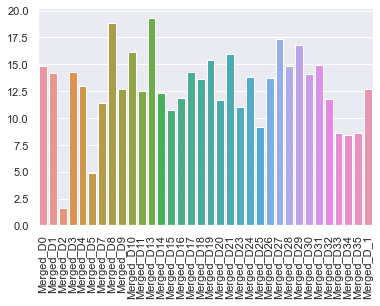

In [585]:
ax = sns.barplot(x=list(rmseVal_merg_df.keys()), y=list(rmseVal_merg_df.values()))

plt.xticks(rotation=90)
plt.show()

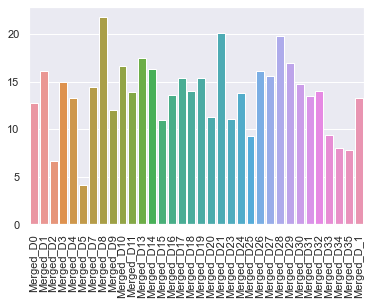

In [586]:
ax = sns.barplot(x=list(rmse_merg_df.keys()), y=list(rmse_merg_df.values()) )

plt.xticks(rotation=90)
plt.show()

In [587]:
np.mean(list(rmse_merg_df.values()))

13.661138903598244

In [588]:
np.mean(list(rmseVal_merg_df.values()))

12.803411028223486

In [509]:
#KNN:
#https://machinelearningmastery.com/tutorial-to-implement-k-nearest-neighbors-in-python-from-scratch/